In [1]:
import os
import sys
import glob
import datetime

import gzip
import pickle

import numpy as np
import pandas as pd
import scipy 

# skew,kutosis
import padasip as pa
# https://matousc89.github.io/padasip/sources/filters/lms.html 

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import biosppy
from biosppy.signals import ecg
from scipy import signal
import pyhrv
import pyhrv.tools as tools
import pyhrv.time_domain as td

import heartpy as hp
from scipy.signal import resample
import mne
from sklearn.decomposition import FastICA

# import matplotlib as mpl
# # %matplotlib
# mpl.use('TkAgg')

In [2]:
# current work directory
path = os.path.abspath(os.getcwd())
print('경로:',path)
# directory file list
# file_list = glob.glob(path+ '/**/*.csv')
#Log 데이터 이름
RESEARCH_LOG = '당일 현장조사 기록지(통합).csv'

# research condition constants
DEVICES = ['H10', 'Verity']
PROTOCOL = ['RESTING', 'MAST']

# time constant(s)
TIME_FORMAT = "%Y%m%d%H%M%S%f"
RESTING_TIME = [420]
MAST_TIME_TABLE = [300, 90, 45, 60, 60, 60, 90, 90, 45, 60]

# protocol constant
# REST = 1, COLD = 2, CACULATE = 3, EMPTY = 0 
MAST_PROTOCOL = [1,2,3,2,3,2,3,2,3,2]
MAST_PROTOCOL_NAME = {0:'EMPTY', 1:'BASELINE', 2: 'HIT', 3:'MA'}
MAST_PROTOCOL_unique = [1,2,3,4,5,6,7,8,9,10]


'''
'CID', = cid
'워치번호', = wid
'심박 실시일자', = resting_date
'조사실(스트랩 넘버)예. 220호(2번)', = resting_room
'키', - height
'몸무게', - weight
'음식 관련', ate_note
'신체/심박 특이사항 (조사 컨디션 상세하게 작성)', = p_note
'MAST실시일자(23-05-06 10:00)', = mast_date
'조사실(스트랩 넘버)예. 220호(4번)', = mast_room
'마지막 음식 섭취 시간', = ate_time
'M0 타액 채취 시간', = m0
'T(실험 시작 시간)##:##:00초 기준', = t
'M1 타액 채취 시간', = m1
'M2 타액 채취 시간', = m2
'MAST 특이사항', = m_note
'M3 타액 채취 시간', = m3
'M4 타액 채취 시간', = m4
'M5 타액 채취 시간', = m5
'M6 타액 채취 시간', = m6
'채취실 특이사항' = etc
'''

RESEARCH_LOG_COLS = ['id', 'wid', 'resting_date', 'resting_room', 'eat_note', 'height', 'weight',
       'p_note', 'mast_date', 'mast_room', 'ate_time', 'M0', 't', 'M1', 'M2', 'm_note', 'M3', 'M4', 'M5', 'M6', 'etc']

# MAST_PROTOCOL = ['REST','COLD','CACUL','COLD','CACUL','COLD','CACUL','COLD','CACUL','COLD']
# MAST_PROTOCOL = [['REST'],['COLD'],['CACUL'],['COLD'],['CACUL'],['COLD'],['CACUL'],['COLD'],['CACUL'],['COLD']]

'''
리서치 note 에러 사항
해당 없음 - 0
연구 중단 -1
움직임 - 2
재조정 - 3
재측정 - 4
측정오류 - 5
착용불량 - 6
큰 거부반응 - 7
기타 -9

'''

# devices constant
# 데이터 시간, 인덱스, ppg 센서 3개, ambient 센서, 수동 입력 marker
VERITY_COL = ['time', 'idx', 'ppg0', 'ppg1', 'ppg2', 'ambient', 'marker', 'proc']
VERITY_FS = 55
# 심박 ecg 센서
H10_COL = ['time', 'idx', 'sensor', 'marker', 'proc']
H10_FS = 130

# time interval caculation을 위한 
Z_list = [0]
today = datetime.date.today()
print('오늘', today)

# analysis instance
fs = VERITY_FS
#cutoff Wn
# cutoff = [fs*0.03,fs/2*0.97]
cutoff = [1.5,3.5]
ts = 1/ fs
Nyq = fs / 2
# 파라미터 계수 N차 - 늘어나면 늘어날 수록 성능은 올라가겠지만 느려지겠지 y= ax1+bx2+cx3+nxN
order = 2

# filter
sos = signal.butter(order, cutoff, btype='bandpass', output = 'sos', fs = fs) #butterworth bandpass 

경로: /home/pilab/workspace/Stress_sensor_data_processing
오늘 2023-06-15


In [3]:
def file_search(path):
    '''
        Mast, Resting csv 파일 찾는 함수
        근데 이거 왜 만듬?
        
        path = 현재 작업 디렉토리 절대 위치
        
        파일 명명 로직:(F)_subject_day_time_sensor

        230501
    '''
    try:
        filenames = os.listdir(path)
        for filename in filenames:
            full_filename = os.path.join(path, filename)
            if filename == 'Mast':
                # mast_path = full_filename
                file_list_mast = sorted([f for f in os.listdir(full_filename) if f.startswith('(M)')])
            elif filename == 'Resting':
                # resting_path = full_filename
                file_list_resting = sorted([f for f in os.listdir(full_filename) if f.startswith('(H)')])
            else:
                pass 
        # return file_list_mast, file_list_resting, resting_path, mast_path
        return file_list_mast, file_list_resting
    
    except PermissionError:
        print('file search fail')
        pass
    
# file_list_mast, file_list_resting, resting_path, mast_path = file_search(path)
file_list_mast, file_list_resting = file_search(path)
# file_search(path)

In [4]:
def device_listing(file_list):
    '''
        기기 별 csv 파일 찾는 함수
        기기 별로 찾아야 할지, 피험자 별로 찾아야할지 아직 모르겠음, 둘다 해야겠지?
        
        파일 명명 로직:(F)_subject_day_time_sensor
    '''
    # polar sensor data list
    try:
        if file_list[0][:3] == ('(H)'):
            print('Resting data')
        elif file_list[0][:3] == ('(M)'):
            print('Mast data')
            
        file_list_H10 = sorted([f for f in file_list if f.endswith('H10.csv')])
        file_list_Verity = sorted([f for f in file_list if f.endswith(('Verity.csv', 'Verity_PPG.csv'))])
        print('Got list')
    except:
        print('wrong list or files')

    return {'H10':file_list_H10, 'Verity': file_list_Verity}
    

resting_device_dict = device_listing(file_list_resting)
mast_device_dict = device_listing(file_list_mast)

Resting data
Got list
Mast data
Got list


In [5]:
def id_listing():
    return
# print('*** Rest H10 데이터:',rest_file_list_H10)
print('H10 데이터 개수',len(mast_device_dict['H10']),'개')
# print('*** Rest Verity 데이터:',rest_file_list_Verity)
print('Verity 데이터 개수',len(mast_device_dict['Verity']),'개')

# 파일 별  분석하려고 대충 보고 있는 for loop
if len(mast_device_dict['H10']) == len(mast_device_dict['Verity']):
    print('Number of Data equl')
    i = 1
    # for H10, Verity in zip(rest_file_list_H10, rest_file_list_Verity):
        
    #     print()
    #     print(f'{i}-1:',H10)
    #     print('ID:',H10[3:6])
    #     print('Date:',H10[7:22])

    #     print(f'{i}-2:',Verity)
    #     print('ID:',Verity[3:6])
    #     print('Date:',Verity[7:22])
        
    #     i += 1
else:
    print('expected data missing')

H10 데이터 개수 117 개
Verity 데이터 개수 117 개
Number of Data equl


In [6]:
def get_date_range(start_date, end_date):
    date_list = []
    current_date = start_date

    while current_date <= end_date:
        date_list.append(current_date)
        current_date += datetime.timedelta(days=1)

    return date_list

def read_file(file_name, task_path, device):
    if device == 'H10':
        names = H10_COL
    elif device == 'Verity':
        names = VERITY_COL
    return pd.read_csv(task_path+ file_name, names= names)

def date_data_load(device_file_dict = {}, start_date = '20230101', end_date = '20240101', task = 'resting'):
    '''
    230501
        기기 별로 date range 안의 데이터 불러와서 nested dict로 만듬
    input
        device_file_dict = 디바이스 별 파일 이름 딕셔너리
        start_date = 검색 시작일
        end_date = 검색 종료일
        task = resting(default) | mast
    return
        nested dict = dict{device dict{date file data}}
    '''
    date_H10_dict = {}
    date_Verity_dict = {}
    
    if task == 'resting':
        print('Resting count')
        task_path = path + '/Resting/'
    else:
        print('Mast count')
        task_path = path + '/Mast/'
    # task_path = f"{path}/{task}/"
    
    start_date  = datetime.datetime.strptime(start_date, "%Y%m%d")
    end_date = datetime.datetime.strptime(end_date, "%Y%m%d")
    date_list = get_date_range(start_date, end_date)
    date_str_list = [datetime_obj.strftime("%Y%m%d") for datetime_obj in date_list]
    # date_str_list = pd.date_range(start_date, end_date)

    # 아래쪽 for 문이랑 합쳐야함 지금 하자
    print('Data Loading...')
    for i in device_file_dict:
        d_list = [data for data in device_file_dict[i] for date in date_str_list if date in data]
        print(d_list)
        if i == 'H10':
            # date_H10_dict = pd.Series(d_list).apply(read_file, args=(task_path, i))
            for df in  d_list:
                date_H10_dict[df] = pd.read_csv(task_path + df, names = H10_COL)
        elif i == 'Verity':
            # date_Verity_dict = pd.Series(d_list).apply(read_file, args=(task_path, i))
            for df in  d_list:
                date_Verity_dict[df] = pd.read_csv(task_path + df, names = VERITY_COL)
        else:
            print('someting is wrong')
    print('Data Load complete')

    print(f'{start_date} ~ {end_date} - H10 데이터: {len(date_H10_dict)} 개')
    print(f'{start_date} ~ {end_date} - Verity 데이터: {len(date_Verity_dict)} 개')
            
    return {'H10': date_H10_dict, 'Verity': date_Verity_dict}


# rest_H10_dict, rest_Verity_dict =  date_listing(rest_file_list_H10, rest_file_list_Verity)
# dir(rest_file_list_H10)
mast_date_dict_list = date_data_load(mast_device_dict, start_date = '20230606', task = 'mast')
resting_date_dict_list = date_data_load(resting_device_dict, start_date = '20230606', task = 'resting')


Mast count
Data Loading...
['(M)065_20230611_115716_H10.csv', '(M)105_20230611_085619_H10.csv', '(M)106_20230611_100111_H10.csv', '(M)107_20230611_100253_H10.csv', '(M)108_20230611_093001_H10.csv', '(M)109_20230611_085626_H10.csv', '(M)110_20230611_085638_H10.csv', '(M)111_20230611_100540_H10.csv', '(M)112_20230611_092859_H10.csv', '(M)113_20230611_093121_H10.csv', '(M)114_20230611_102058_H10.csv', '(M)115_20230611_102458_H10.csv', '(M)116_20230611_102050_H10.csv', '(M)117_20230611_120045_H10.csv', '(M)117_20230611_122007_H10.csv', '(M)118_20230611_104957_H10.csv', '(M)119_20230611_105004_H10.csv', '(M)120_20230611_112633_H10.csv', '(M)121_20230611_105021_H10.csv', '(M)122_20230611_122715_H10.csv', '(M)123_20230611_122627_H10.csv', '(M)124_20230611_112909_H10.csv', '(M)125_20230611_112544_H10.csv']
['(M)065_20230611_115716_Verity_PPG.csv', '(M)105_20230611_085619_Verity_PPG.csv', '(M)106_20230611_100111_Verity_PPG.csv', '(M)107_20230611_100253_Verity_PPG.csv', '(M)108_20230611_093001_V

In [21]:

dd

In [7]:
# !!!!! 이거 안씀~

def close():





    # Data check 1 - 사실 data frame을 알고 있어서 vectorization 해야함... 아 귀찮
    #mast_date_dict_list는 H10와 Verity를 가짐
    for i in mast_date_dict_list:

        #기기 별로 pkl load
        try:
            with gzip.open(f'./pkl/{i}_mast.pickle','rb') as f:
                df = pickle.load(f)
        except:
            with gzip.open(f'./pkl/{i}_mast.pickle','rb') as f:
                df = pickle.load(f)       
            pass

        # load한 데이터가 비어있으면 df 생성
        if len(df) == 0 :
            df = pd.DataFrame(columns = ['id', 'date', 'protocol', 'device', 'start', 'end', 'total', 'avg', 'fs'])

        # # dict 내의 기기별 raw data file 이름 j
        # for j in mast_date_dict_list[i]:
        #     # (!)데이터 shape와 columns 확인 -> 추가 데이터 생기면 수정해야하고 필수 코드
        #     if j.endswith('H10.csv'):
        #         # print('H10 모양 :', mast_date_dict_list[i][j].shape)
        #         H10_rows, H10_columns = mast_date_dict_list[i][j].shape
        #         if H10_columns == 4:
        #             # print('H10 Data columns length is correct')
        #             pass
        #         else:
        #             break
        #             print('H10 Data columns length is Not correct')
        #     elif j.endswith('Verity.csv'):
        #         # print('Verity 모양 :', mast_date_dict_list[i][j].shape)
        #         Verity_rows, VERITY_COLumns = mast_date_dict_list[i][j].shape
        #         if VERITY_COLumns == 7:
        #             # print('Verity sensor Data columns length is correct')
        #             pass
        #         else:
        #             break
        #             print('Verity sensor Data columns length is Not correct')
        # print(i + ' OK!')
        
        # dict 내의 기기별 raw data file 이름 j
        for j in mast_date_dict_list[i]:
            print(j)
            if len(mast_date_dict_list[i][j]) <= 100:
                print('Data is too short')
                print('-'*60)
                continue
            # df time을 datetime으로 캐스팅
            mast_date_dict_list[i][j]['times'] = pd.to_datetime(mast_date_dict_list[i][j]['time'], 
                                                                format = TIME_FORMAT)
            # !! 매우 느림, interval을 구하는 부분임 이게 또 어디에 쓰이던가?  길이가 잘 맞는지 확인하는 파트 필요 없음     
            # mast_date_dict_list[i][j]['interval'] = \
            #     Z_list + [mast_date_dict_list[i][j]['times'].loc[k+1]-mast_date_dict_list[i][j]['times'].loc[k] 
            #               for k in range(len(mast_date_dict_list[i][j])-1)]

            # 첫 행과 마지막 행의 times 
            mast_start_time = mast_date_dict_list[i][j]['times'].iloc[0]
            print(mast_start_time)
            mast_end_time = mast_date_dict_list[i][j]['times'].iloc[-1]
            # 시간 계산
            mast_total_time = mast_end_time-mast_start_time
            mast_time_resolution = (mast_end_time-mast_start_time)/ len(mast_date_dict_list[i][j])
            mast_fs = 1/ mast_time_resolution.total_seconds()
            
            print('Time domain window')
            print('시작 시간:',mast_start_time, '종료 시간:',mast_end_time, '총 측정 시간:', mast_total_time)
            
            # if 20 <= abs(mast_total_time.total_seconds()-MAST_TIME_TABLE[0]):
            #     print('Wrong measurement time')

            print('해상도:', mast_time_resolution, 'fs:', mast_fs)

            row = pd.DataFrame({'id':[int(num) for num in [j[3:6]]], 'date':[j[7:22]], 'protocol':[j[1:2]], 'device':[j[23:-4]], 
                            'start':[mast_start_time], 'end':[mast_end_time], 'total':[mast_total_time],
                            'avg':[mast_time_resolution], 
                            'fs':[mast_fs]
                            })
            
            df = pd.concat([df, row]).drop_duplicates().reset_index(drop=True)
            
    #         if 'H10' in i:

    #             if mast_fs <= 0.07693 and mast_fs >= 0.07692:
    #                 # print("Hz correct.")
    #                 pass
    #             else:
    #                 print("Hz Error!!!!")
    #         else:
    #             print('해상도:', mast_time_resolution, 'fs:', mast_fs)
    #             if rest_H10_fs <= 0.018182 and rest_H10_fs >= 18181:
    #                 # print("Hz correct.")
    #                 pass
    #             else:
    #                 print("Hz Error!!!!")
            # print('interval data...')
            # print(mast_date_dict_list[i][j]['interval'])
                # time col datatype cast to datetime 

            print('----------------------------------------------------------------------')

        if 'H10' in i:
            mast_H10_dict = mast_date_dict_list[i]
        else:
            mast_Verity_dict = mast_date_dict_list[i]
        
        with gzip.open(f'./pkl/{i}_mast.pickle', 'wb') as f:
            pickle.dump(df, f)





    0601
    # Data check 1 - 사실 data frame을 알고 있어서 for문 날려야함... 아
    #mast_date_dict_list는 H10_dict와 Verity_dict를 가짐
    for i in mast_date_dict_list:

        #기기 별로 pkl load
        try:
            with gzip.open(f'./pkl/{i}_mast_{today}.pickle','rb') as f:
                participants_file_df = pickle.load(f)
        except:
            with gzip.open(f'./pkl/{i}_mast_{today}.pickle','wb') as f:
                participants_file_df = pd.DataFrame(columns = ['id', 'date', 'protocol', 'device', 'start', 'end', 'total', 'avg', 'fs'])
            pass

        # load한 데이터가 비어있으면 df 생성
        if len(participants_file_df) == 0 :
            participants_file_df = pd.DataFrame(columns = ['id', 'date', 'protocol', 'device', 'start', 'end', 'total', 'avg', 'fs'])
        print(participants_file_df.keys())
        # dict 내의 기기별 raw data file 이름 j
        for j in mast_date_dict_list[i]:
            print(j)
            if len(mast_date_dict_list[i][j]) <= 100:
                print('Data is too short')
                print('Data drop')
                # mast_date_dict_list[i].pop(j)
                print('-'*60)
                continue
            # df time을 datetime으로 캐스팅
            mast_date_dict_list[i][j]['times'] = pd.to_datetime(mast_date_dict_list[i][j]['time'], 
                                                                format = TIME_FORMAT)

            # 첫 행과 마지막 행의 times - 뒤에서 2번째 열
            mast_start_time = mast_date_dict_list[i][j]['times'].iloc[0]
            mast_end_time = mast_date_dict_list[i][j]['times'].iloc[-1]
            # 시간 계산
            mast_total_time = mast_end_time-mast_start_time
            mast_time_resolution = (mast_end_time-mast_start_time)/ len(mast_date_dict_list[i][j])
            mast_fs = 1/ mast_time_resolution.total_seconds()
            
            print('Time domain window')
            print('시작 시간:',mast_start_time, '종료 시간:',mast_end_time, '총 측정 시간:', mast_total_time)
            

            print('해상도:', mast_time_resolution, 'fs:', mast_fs)

            row = pd.DataFrame({'id':[int(num) for num in [j[3:6]]], 'date':[j[7:22]], 'protocol':[j[1:2]], 'device':[j[23:-4]], 
                            'start':[mast_start_time], 'end':[mast_end_time], 'total':[mast_total_time],
                            'avg':[mast_time_resolution], 
                            'fs':[mast_fs]
                            })
            
            # participants_file_df = pd.merge(participants_file_df, row, how = 'inner', on= ['id', 'date', 'device'])\
            participants_file_df = pd.concat([participants_file_df, row])\
                    .drop_duplicates()\
                    .reset_index(drop=True)
            print('----------------------------------------------------------------------')

        if 'H10' in i:
            mast_H10_dict = mast_date_dict_list[i]
        else:
            mast_Verity_dict = mast_date_dict_list[i]
        
        with gzip.open(f'./pkl/{i}_mast_{today}.pickle', 'wb') as f:
            pickle.dump(participants_file_df, f)


        # 당일 현장조사 기록지에서 mast 시작 시간 받아서 mast 측정 proc 설정
        tmp = pd.DataFrame(columns = ['id', 'mast_start_time'])

        research_log_df = pd.read_csv(path + '/' + RESEARCH_LOG, header = 2, names = RESEARCH_LOG_COLS, index_col= False)

        research_log_df['mast_start_time'] = pd.to_datetime(research_log_df.mast_date +'-'+ research_log_df.t) - datetime.timedelta(minutes = 5)
        # mast 시작에서 baseline time은 시작 시간 - 5분
        for i, v in research_log_df.iterrows():
            if type(v.mast_date) == str:
                tmp_time = v.mast_date +'-'+ v.t
                if len(tmp_time) <= 14:
                    t_time = datetime.datetime.strptime(v.mast_date +'-'+ v.t, '%y-%m-%d-%H:%M')
                else:
                    t_time = datetime.datetime.strptime(v.mast_date +'-'+ v.t, '%y-%m-%d-%H:%M:%S')
                t_start_time = t_time - datetime.timedelta(minutes = 5)
            else:
                t_start_time = None
                pass
            participants_mast_start_time = pd.DataFrame({'id':[v.id], 'mast_start_time':[t_start_time]})
            tmp = pd.concat([tmp, participants_mast_start_time])\
                        .drop_duplicates()\
                        .reset_index(drop=True)
        
        # # tmp 파일에 축적된 데이터를 research_log에 merge....? 이걸 왜 하지 task_time으로 걍 합침
        # research_log_df = pd.merge(research_log_df,tmp, on = 'id')
        # task_time = pd.concat(tmp, research_log_df[['id', 't']])
        # task_time = research_log_df[['id','t', 'mast_start_time']]
        # participants_time_df = pd.merge(participants_file_df, task_time, how = 'outer', on = 'id')
        # participants_time_df = participants_time_df.rename(columns=lambda x: x.replace('_x', '').replace('_y', ''))
        print(participants_file_df)
        participants_time_df = pd.concat([participants_file_df, tmp, research_log_df[['id', 't']]])

        with gzip.open(f'./pkl/{i}_mast_{today}.pickle', 'wb') as f:
            pickle.dump(participants_time_df, f)

SyntaxError: leading zeros in decimal integer literals are not permitted; use an 0o prefix for octal integers (590871969.py, line 121)

In [32]:
def schedule_check():
    '''
    # 수정 230613
    Mast만 전체 프로세스 진행하고 Resting은 전부 필요한 것은 아님
    Data check 1 - 사실 data frame을 알고 있어서 for문 날려야함... 아
    mast_date_dict_list는 H10_dict와 Verity_dict를 가짐
    Const : RESEARCH_LOG_COLS
    Input :

    Output :

    '''
    return

for i in mast_date_dict_list:
    print(i)
    #기기 별로 pkl load
    try:
        with gzip.open(f'./pkl/{i}_mast_{today}.pickle','rb') as f:
            participants_file_df = pickle.load(f)
    except:
        participants_file_df = pd.DataFrame(\
            columns = ['id', 'date', 'protocol', 'device', 'start', 'end', 'total', 'avg', 'fs'])
        pass

    # load한 데이터가 비어있으면 df 생성 ????
    # if len(participants_file_df) == 0 :
    #     participants_file_df = pd.DataFrame(\
    #         columns = ['id', 'date', 'protocol', 'device', 'start', 'end', 'total', 'avg', 'fs'])
    
    # dict 내의 기기별 raw data file 이름 j
    for j in mast_date_dict_list[i]:
        print(j)
        if len(mast_date_dict_list[i][j]) <= 100:
            print('Data is too short')
            print('Data drop')
            # mast_date_dict_list[i].pop(j)
            print('-'*60)
            continue
        # df time을 datetime으로 캐스팅
        mast_date_dict_list[i][j]['times'] = pd.to_datetime(mast_date_dict_list[i][j]['time'], 
                                                               format = TIME_FORMAT)

        # 첫 행과 마지막 행의 times - 뒤에서 2번째 열
        mast_start_time = mast_date_dict_list[i][j]['times'].iloc[0]
        mast_end_time = mast_date_dict_list[i][j]['times'].iloc[-1]
        # 시간 계산
        mast_total_time = mast_end_time-mast_start_time
        mast_time_resolution = (mast_end_time-mast_start_time)/ len(mast_date_dict_list[i][j])
        mast_fs = 1/ mast_time_resolution.total_seconds()
        
        print('Time domain window')
        print('시작 시간:',mast_start_time, '종료 시간:',mast_end_time, '총 측정 시간:', mast_total_time)
        

        print('해상도:', mast_time_resolution, 'fs:', mast_fs)

        row = pd.DataFrame({'id':[int(num) for num in [j[3:6]]], 'date':[j[7:22]], 'protocol':[j[1:2]], 'device':[j[23:-4]], 
                        'start':[mast_start_time], 'end':[mast_end_time], 'total':[mast_total_time],
                        'avg':[mast_time_resolution], 
                        'fs':[mast_fs]
                        })
        
        # participants_file_df = pd.merge(participants_file_df, row, how = 'inner', on= ['id', 'date', 'device'])\
        participants_file_df = pd.concat([participants_file_df, row])\
                .drop_duplicates()\
                .reset_index(drop=True)
        print('----------------------------------------------------------------------')

    # 없어도 됨 ㅋ
    # if 'H10' in i:
    #     mast_H10_dict = mast_date_dict_list[i]
    # else:
    #     mast_Verity_dict = mast_date_dict_list[i]
    
    with gzip.open(f'./pkl/{i}_mast_{today}.pickle', 'wb') as f:
        pickle.dump(participants_file_df, f)


    # 당일 현장조사 기록지에서 mast 시작 시간 받아서 mast 측정 proc 설정
    tmp = pd.DataFrame(columns = ['id', 'mast_start_time'])

    research_log_df = pd.read_csv(path + '/' + RESEARCH_LOG, header = 2, names = RESEARCH_LOG_COLS, index_col= False)
    research_log_df['mast_start_time'] = pd.to_datetime(research_log_df.mast_date +'-'+ research_log_df.t) - datetime.timedelta(minutes = 5)
    
    # mast 시작에서 baseline time은 시작 시간 - 5분
    for k, v in research_log_df.iterrows():
        if type(v.mast_date) == str:
            tmp_time = v.mast_date +'-'+ v.t
            if len(tmp_time) <= 14:
                t_time = datetime.datetime.strptime(v.mast_date +'-'+ v.t, '%y-%m-%d-%H:%M')
            else:
                t_time = datetime.datetime.strptime(v.mast_date +'-'+ v.t, '%y-%m-%d-%H:%M:%S')
            t_start_time = t_time - datetime.timedelta(minutes = 5)
        else:
            t_start_time = None
            pass

        participants_mast_start_time = pd.DataFrame({'id':[v.id], 'mast_start_time':[t_start_time]})
        tmp = pd.concat([tmp, participants_mast_start_time])\
                    .drop_duplicates()\
                    .reset_index(drop=True)
    id_time_df = pd.merge( tmp, research_log_df[['id', 't']], how='outer')
    participants_time_df = pd.merge(participants_file_df[participants_file_df.keys()[0:9]], id_time_df, how='outer')
        
    # participants_time_df = pd.concat([participants_file_df[participants_file_df.keys()[0:9]], tmp, research_log_df[['id', 't']]])\
    #                     .drop_duplicates()\
    #                     .reset_index(drop=True)
    print(participants_time_df)

    with gzip.open(f'./pkl/{i}_mast_{today}.pickle', 'wb') as f:
        pickle.dump(participants_time_df, f)

H10
(M)065_20230611_115716_H10.csv
Time domain window
시작 시간: 2023-06-11 11:57:16.583509 종료 시간: 2023-06-11 12:18:32.322382 총 측정 시간: 0 days 00:21:15.738873
해상도: 0 days 00:00:00.007695233 fs: 129.95451591942822
----------------------------------------------------------------------
(M)105_20230611_085619_H10.csv
Time domain window
시작 시간: 2023-06-11 08:56:19.700754 종료 시간: 2023-06-11 09:16:02.267542 총 측정 시간: 0 days 00:19:42.566788
해상도: 0 days 00:00:00.007695745 fs: 129.95451591942822
----------------------------------------------------------------------
(M)106_20230611_100111_H10.csv
Time domain window
시작 시간: 2023-06-11 10:01:11.473328 종료 시간: 2023-06-11 10:15:45.065157 총 측정 시간: 0 days 00:14:33.591829
해상도: 0 days 00:00:00.007695827 fs: 129.95451591942822
----------------------------------------------------------------------
(M)107_20230611_100253_H10.csv
Time domain window
시작 시간: 2023-06-11 10:02:53.794966 종료 시간: 2023-06-11 10:15:11.430463 총 측정 시간: 0 days 00:12:17.635497
해상도: 0 days 00:00:00.

/tmp/ipykernel_36589/1456111911.py:82: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  research_log_df = pd.read_csv(path + '/' + RESEARCH_LOG, header = 2, names = RESEARCH_LOG_COLS, index_col= False)
/tmp/ipykernel_36589/1456111911.py:83: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  research_log_df['mast_start_time'] = pd.to_datetime(research_log_df.mast_date +'-'+ research_log_df.t) - datetime.timedelta(minutes = 5)


Time domain window
시작 시간: 2023-06-11 11:57:16.590299 종료 시간: 2023-06-11 12:18:32.447423 총 측정 시간: 0 days 00:21:15.857124
해상도: 0 days 00:00:00.018328383 fs: 54.56132693147097
----------------------------------------------------------------------
(M)105_20230611_085619_Verity_PPG.csv
Time domain window
시작 시간: 2023-06-11 08:56:19.707637 종료 시간: 2023-06-11 09:16:02.631456 총 측정 시간: 0 days 00:19:42.923819
해상도: 0 days 00:00:00.018184839 fs: 54.993400791904975
----------------------------------------------------------------------
(M)106_20230611_100111_Verity_PPG.csv
Time domain window
시작 시간: 2023-06-11 10:01:11.480186 종료 시간: 2023-06-11 10:15:44.493937 총 측정 시간: 0 days 00:14:33.013751
해상도: 0 days 00:00:00.018183240 fs: 54.99642523235989
----------------------------------------------------------------------
(M)107_20230611_100253_Verity_PPG.csv
Time domain window
시작 시간: 2023-06-11 10:02:53.801681 종료 시간: 2023-06-11 10:15:11.204094 총 측정 시간: 0 days 00:12:17.402413
해상도: 0 days 00:00:00.018196234 fs: 54

/tmp/ipykernel_36589/1456111911.py:82: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  research_log_df = pd.read_csv(path + '/' + RESEARCH_LOG, header = 2, names = RESEARCH_LOG_COLS, index_col= False)
/tmp/ipykernel_36589/1456111911.py:83: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  research_log_df['mast_start_time'] = pd.to_datetime(research_log_df.mast_date +'-'+ research_log_df.t) - datetime.timedelta(minutes = 5)


H10
파일명: (M)065_20230611_115716_H10.csv
전체길이: 165783
   id             date protocol device                      start   
0  65  20230611_115716        M    H10 2023-06-11 11:57:16.583509  \

                         end                  total                       avg   
0 2023-06-11 12:18:32.322382 0 days 00:21:15.738873 0 days 00:00:00.007695233  \

           fs     mast_start_time      t  
0  129.954516 2023-06-11 12:03:00  12:08  
raw data:                         time     idx  sensor  marker  proc   
0       20230611115716583509       0    -343       0   NaN  \
1       20230611115716591201       1    -343       0   NaN   
2       20230611115716598893       2    -364       0   NaN   
3       20230611115716606586       3    -373       0   NaN   
4       20230611115716614278       4    -369       0   NaN   
...                      ...     ...     ...     ...   ...   
165778  20230611121832291613  165778     -25       0   NaN   
165779  20230611121832299305  165779     -18       0 

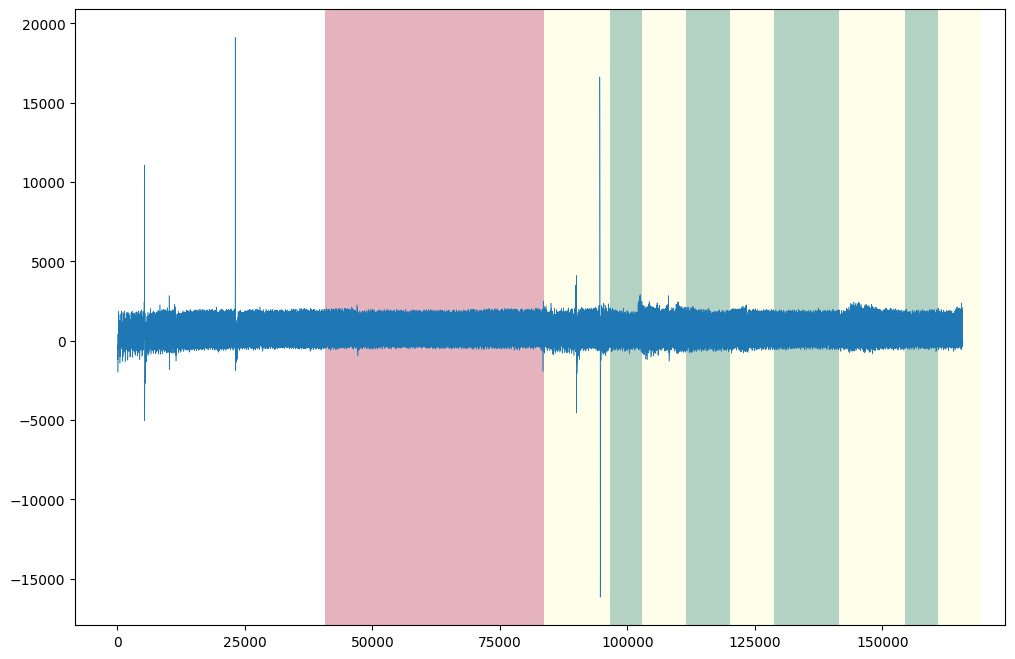

파일명: (M)105_20230611_085619_H10.csv
전체길이: 153665
    id             date protocol device                      start   
1  105  20230611_085619        M    H10 2023-06-11 08:56:19.700754  \

                         end                  total                       avg   
1 2023-06-11 09:16:02.267542 0 days 00:19:42.566788 0 days 00:00:00.007695745  \

           fs     mast_start_time     t  
1  129.954516 2023-06-11 09:00:00  9:05  
raw data:                         time     idx  sensor  marker  proc   
0       20230611085619700754       0     -67       0   NaN  \
1       20230611085619708446       1     -94       0   NaN   
2       20230611085619716138       2    -116       0   NaN   
3       20230611085619723831       3    -130       0   NaN   
4       20230611085619731523       4    -137       0   NaN   
...                      ...     ...     ...     ...   ...   
153660  20230611091602236773  153660    -169       0   NaN   
153661  20230611091602244465  153661    -169       0   Na

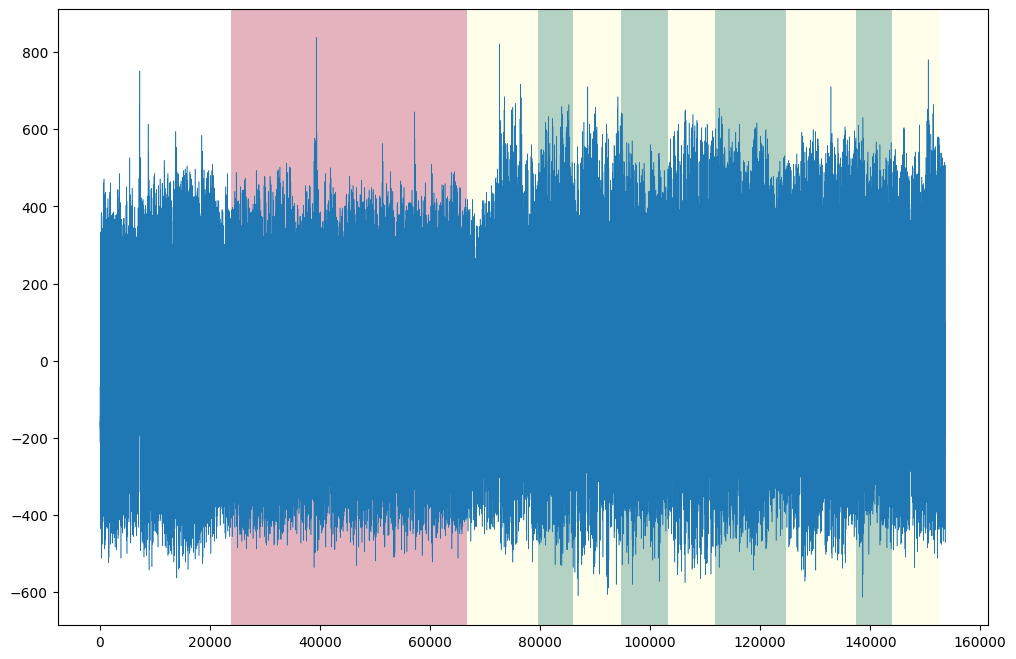

파일명: (M)106_20230611_100111_H10.csv
전체길이: 113515
    id             date protocol device                      start   
2  106  20230611_100111        M    H10 2023-06-11 10:01:11.473328  \

                         end                  total                       avg   
2 2023-06-11 10:15:45.065157 0 days 00:14:33.591829 0 days 00:00:00.007695827  \

           fs     mast_start_time      t  
2  129.954516 2023-06-11 10:00:00  10:05  
raw data:                         time     idx  sensor  marker  proc   
0       20230611100111473328       0     -33       0   NaN  \
1       20230611100111481020       1     -21       0   1.0   
2       20230611100111488712       2     -14       0   1.0   
3       20230611100111496405       3     -26       0   1.0   
4       20230611100111504097       4     -43       0   1.0   
...                      ...     ...     ...     ...   ...   
113510  20230611101545034388  113510    -232       0   NaN   
113511  20230611101545042080  113511    -232       0   

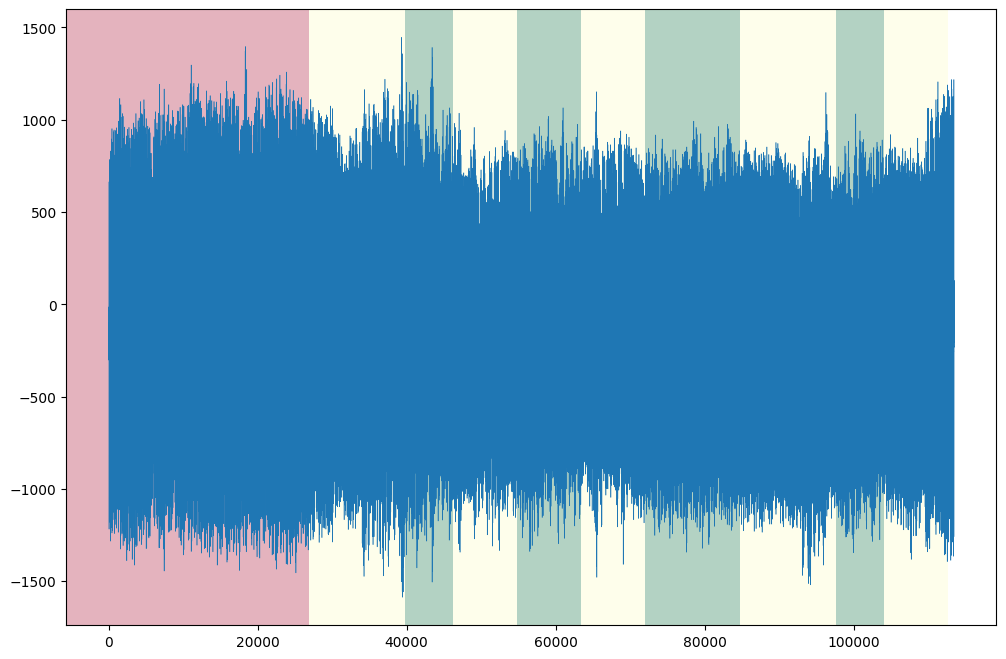

파일명: (M)107_20230611_100253_H10.csv
전체길이: 95849
    id             date protocol device                      start   
3  107  20230611_100253        M    H10 2023-06-11 10:02:53.794966  \

                         end                  total                       avg   
3 2023-06-11 10:15:11.430463 0 days 00:12:17.635497 0 days 00:00:00.007695807  \

           fs     mast_start_time      t  
3  129.954516 2023-06-11 10:00:00  10:05  
raw data:                        time    idx  sensor  marker  proc   
0      20230611100253794966      0      91       0   NaN  \
1      20230611100253802658      1    1279       0   1.0   
2      20230611100253810350      2    2237       0   1.0   
3      20230611100253818043      3    1223       0   1.0   
4      20230611100253825735      4    -597       0   1.0   
...                     ...    ...     ...     ...   ...   
95844  20230611101511399694  95844     -79       0   NaN   
95845  20230611101511407386  95845     -70       0   NaN   
95846  20230

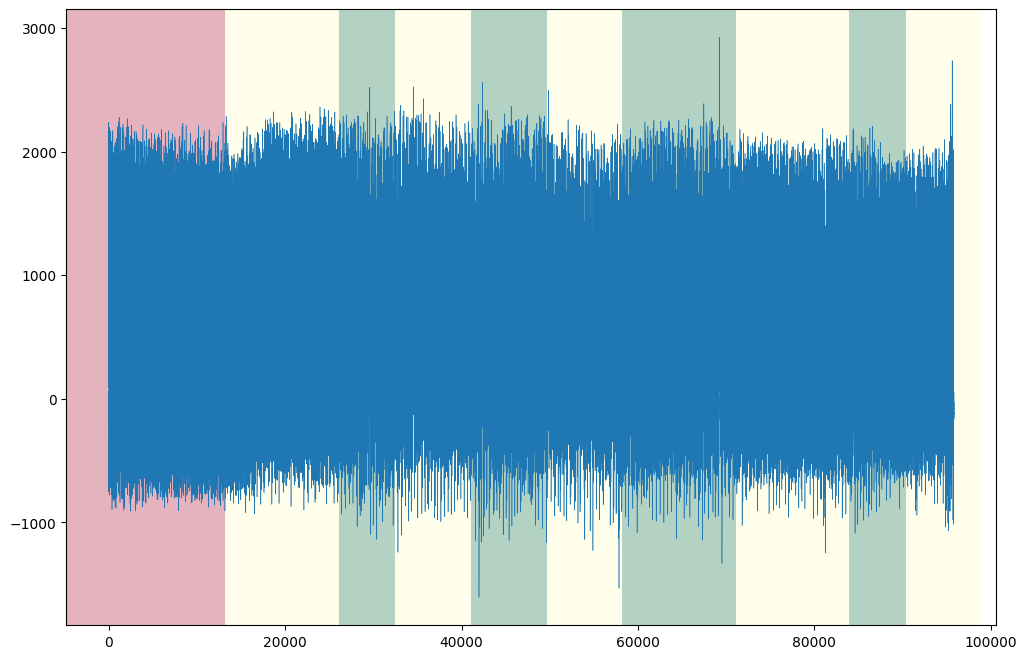

파일명: (M)108_20230611_093001_H10.csv
전체길이: 157315
    id             date protocol device                      start   
4  108  20230611_093001        M    H10 2023-06-11 09:30:01.834274  \

                         end                  total                       avg   
4 2023-06-11 09:50:12.447634 0 days 00:20:10.613360 0 days 00:00:00.007695473  \

           fs     mast_start_time     t  
4  129.954516 2023-06-11 09:35:00  9:40  
raw data:                         time     idx  sensor  marker  proc   
0       20230611093001834274       0    -125       0   NaN  \
1       20230611093001841966       1    -120       0   NaN   
2       20230611093001849658       2    -118       0   NaN   
3       20230611093001857351       3    -132       0   NaN   
4       20230611093001865043       4    -154       0   NaN   
...                      ...     ...     ...     ...   ...   
157310  20230611095012416865  157310     -55       0   NaN   
157311  20230611095012424557  157311     -70       0   Na

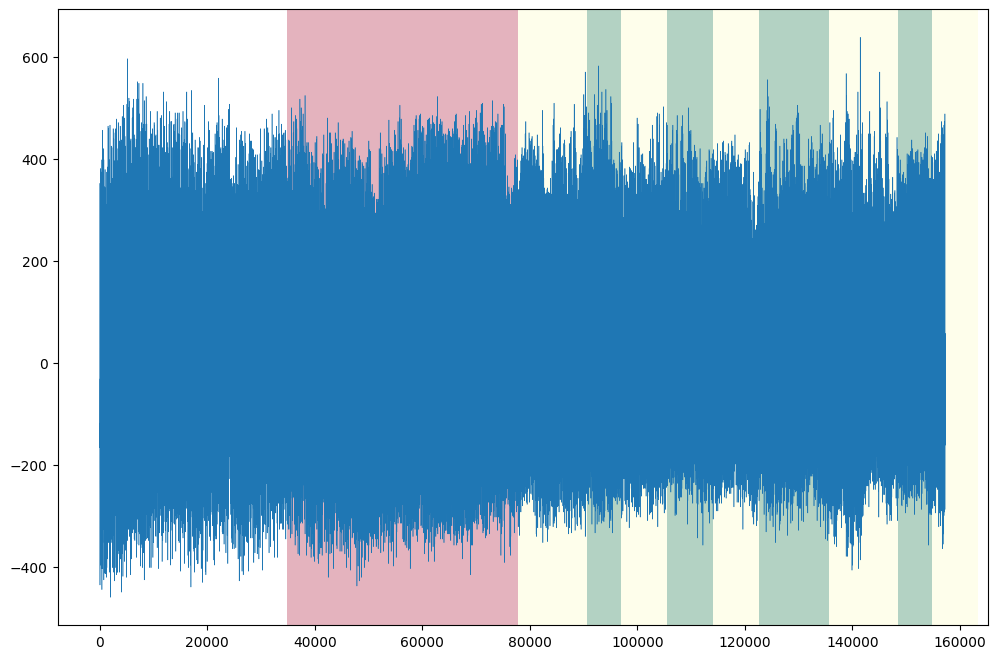

파일명: (M)109_20230611_085626_H10.csv
전체길이: 162279
    id             date protocol device                      start   
5  109  20230611_085626        M    H10 2023-06-11 08:56:26.455481  \

                         end                  total                       avg   
5 2023-06-11 09:17:15.491958 0 days 00:20:49.036477 0 days 00:00:00.007696846  \

          fs     mast_start_time     t  
5  129.93763 2023-06-11 09:02:00  9:07  
raw data:                         time     idx  sensor  marker  proc   
0       20230611085626455481       0      84       0   NaN  \
1       20230611085626463173       1      72       0   NaN   
2       20230611085626470865       2     100       0   NaN   
3       20230611085626478558       3     123       0   NaN   
4       20230611085626486250       4     114       0   NaN   
...                      ...     ...     ...     ...   ...   
162274  20230611091715461189  162274     133       0   NaN   
162275  20230611091715468881  162275      95       0   NaN 

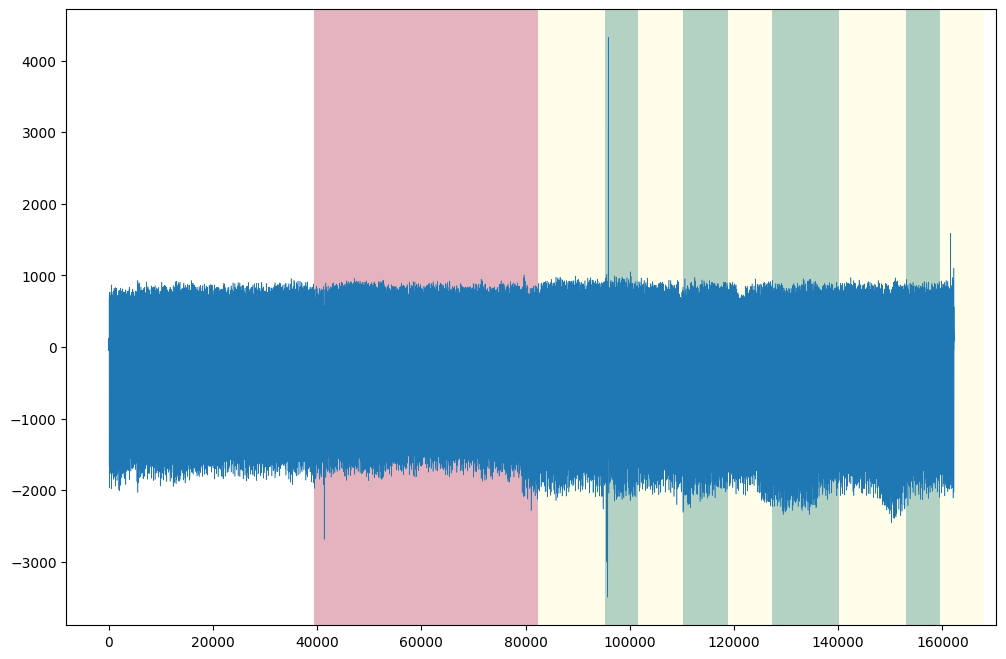

파일명: (M)110_20230611_085638_H10.csv
전체길이: 184836
    id             date protocol device                      start   
6  110  20230611_085638        M    H10 2023-06-11 08:56:38.363871  \

                         end                  total                       avg   
6 2023-06-11 09:20:25.079735 0 days 00:23:46.715864 0 days 00:00:00.007718820  \

           fs     mast_start_time     t  
6  129.567245 2023-06-11 09:02:00  9:07  
raw data:                         time     idx  sensor  marker  proc   
0       20230611085638363871       0    -565       0   NaN  \
1       20230611085638371563       1    -380       0   NaN   
2       20230611085638379255       2    -309       0   NaN   
3       20230611085638386948       3    -233       0   NaN   
4       20230611085638394640       4     -68       0   NaN   
...                      ...     ...     ...     ...   ...   
184831  20230611092025048966  184831    -165       0   NaN   
184832  20230611092025056658  184832    -168       0   Na

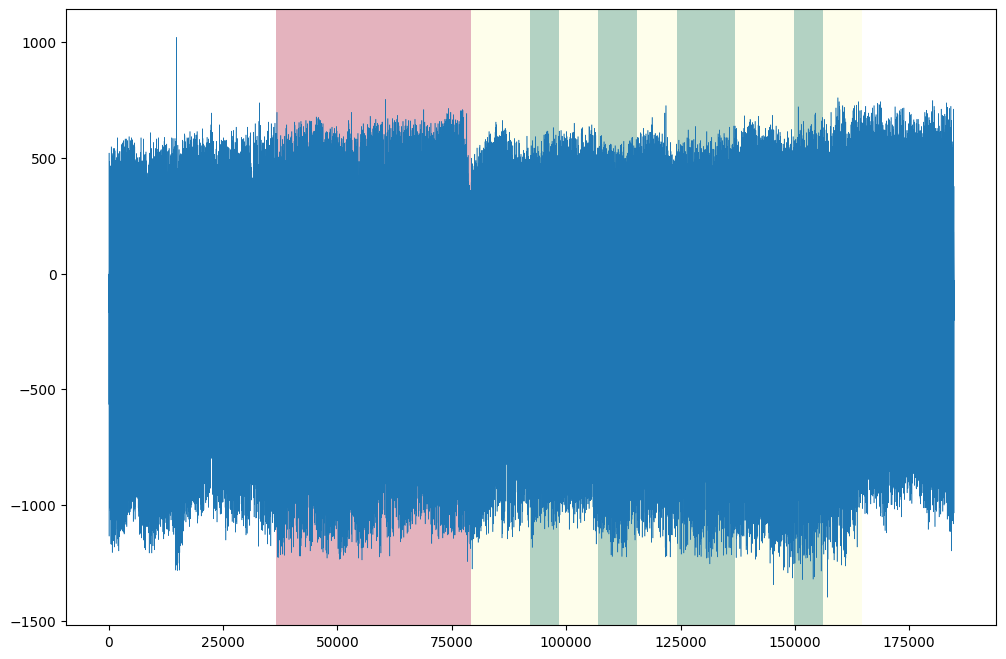

파일명: (M)111_20230611_100540_H10.csv
전체길이: 106580
    id             date protocol device                      start   
7  111  20230611_100540        M    H10 2023-06-11 10:05:40.158144  \

                         end                  total                       avg   
7 2023-06-11 10:19:22.845018 0 days 00:13:42.686874 0 days 00:00:00.007718961  \

           fs     mast_start_time         t  
7  129.567245 2023-06-11 10:00:52  10:05:52  
raw data:                         time     idx  sensor  marker  proc   
0       20230611100540158144       0     -97       0   NaN  \
1       20230611100540165836       1    -131       0   1.0   
2       20230611100540173528       2    -136       0   1.0   
3       20230611100540181221       3    -148       0   1.0   
4       20230611100540188913       4    -168       0   1.0   
...                      ...     ...     ...     ...   ...   
106575  20230611101922814249  106575     -82       0   NaN   
106576  20230611101922821941  106576    -107     

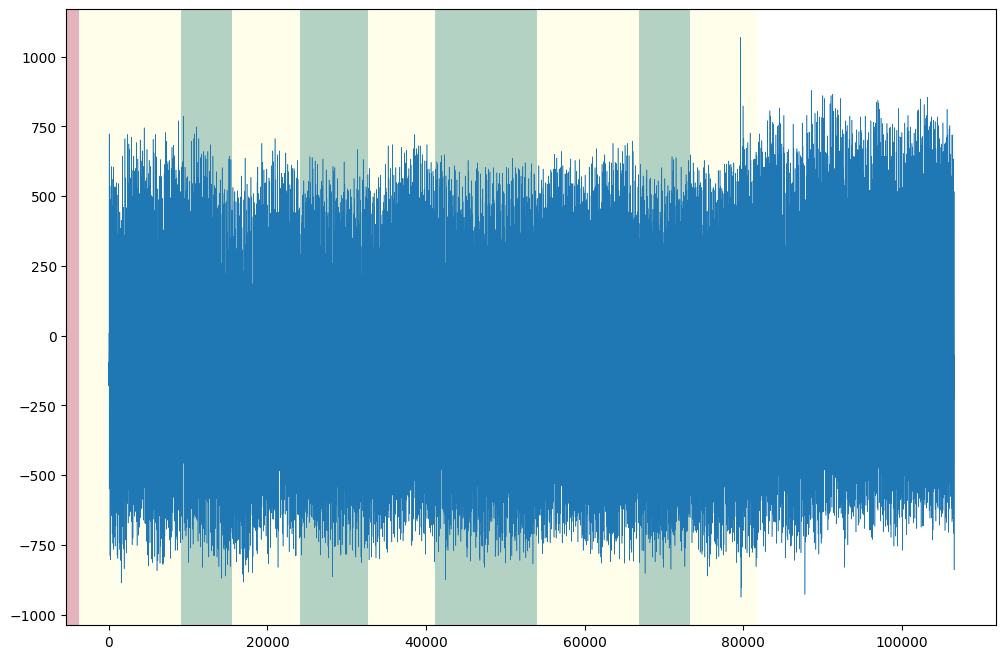

파일명: (M)112_20230611_092859_H10.csv
전체길이: 162279
    id             date protocol device                      start   
8  112  20230611_092859        M    H10 2023-06-11 09:28:59.757688  \

                         end                  total                       avg   
8 2023-06-11 09:49:48.752966 0 days 00:20:48.995278 0 days 00:00:00.007696592  \

          fs     mast_start_time     t  
8  129.93763 2023-06-11 09:34:00  9:39  
raw data:                         time     idx  sensor  marker  proc   
0       20230611092859757688       0    -249       0   NaN  \
1       20230611092859765380       1    -249       0   NaN   
2       20230611092859773072       2    -249       0   NaN   
3       20230611092859780765       3    -245       0   NaN   
4       20230611092859788457       4    -242       0   NaN   
...                      ...     ...     ...     ...   ...   
162274  20230611094948722197  162274    -149       0   NaN   
162275  20230611094948729889  162275    -149       0   NaN 

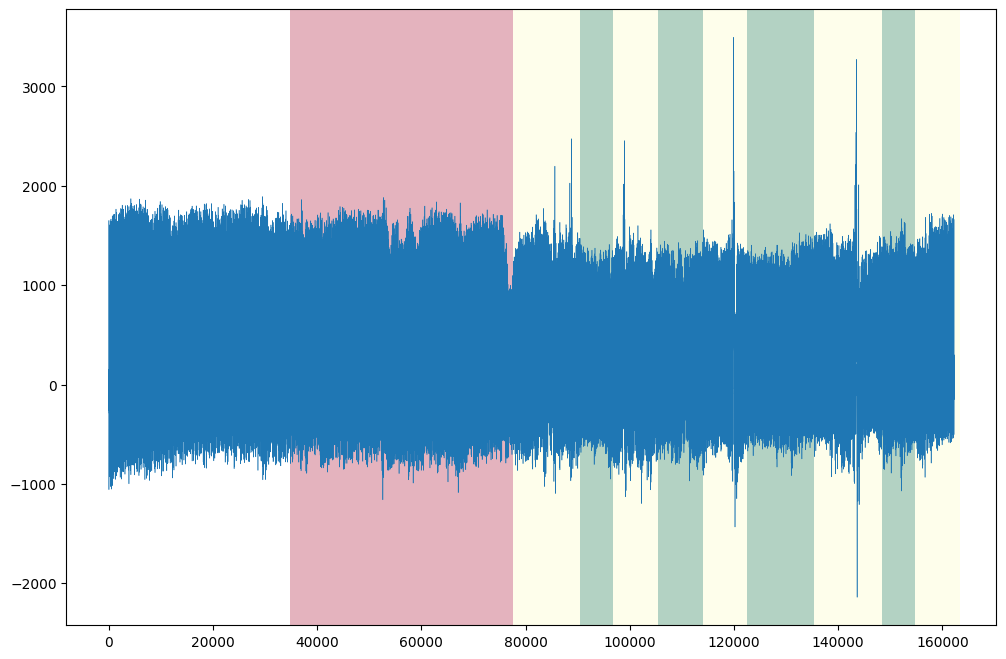

파일명: (M)113_20230611_093121_H10.csv
전체길이: 186369
    id             date protocol device                      start   
9  113  20230611_093121        M    H10 2023-06-11 09:31:21.951355  \

                         end                  total                       avg   
9 2023-06-11 09:55:20.512114 0 days 00:23:58.560759 0 days 00:00:00.007718884  \

           fs     mast_start_time     t  
9  129.567245 2023-06-11 09:37:00  9:42  
raw data:                         time     idx  sensor  marker  proc   
0       20230611093121951355       0    -187       0   NaN  \
1       20230611093121959047       1    -187       0   NaN   
2       20230611093121966739       2    -187       0   NaN   
3       20230611093121974432       3    -182       0   NaN   
4       20230611093121982124       4    -182       0   NaN   
...                      ...     ...     ...     ...   ...   
186364  20230611095520481345  186364    -153       0   NaN   
186365  20230611095520489037  186365    -155       0   Na

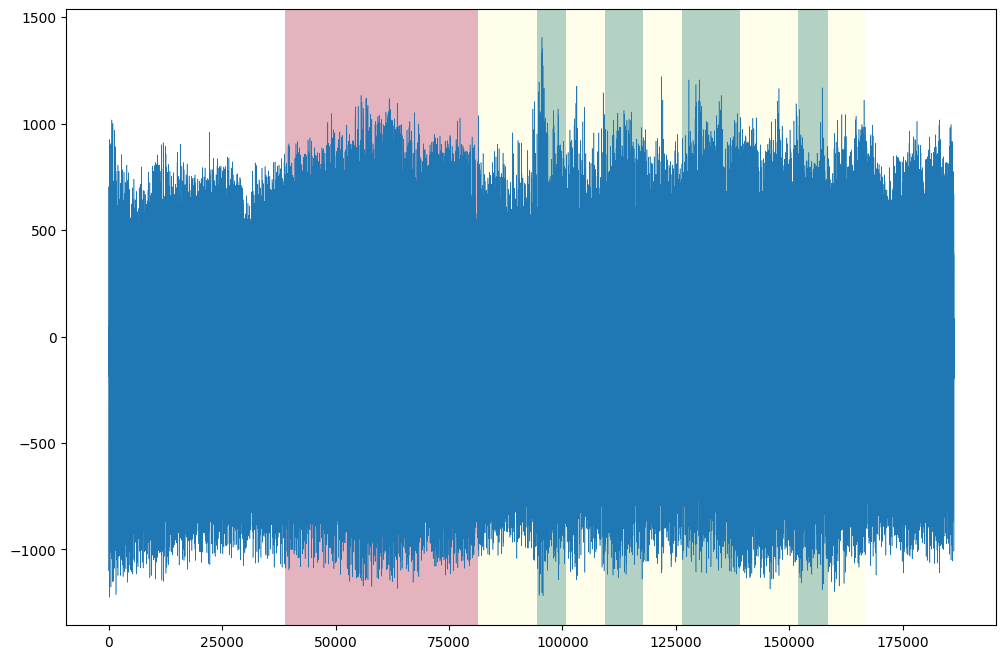

파일명: (M)114_20230611_102058_H10.csv
전체길이: 110960
     id             date protocol device                      start   
10  114  20230611_102058        M    H10 2023-06-11 10:20:58.672864  \

                          end                  total   
10 2023-06-11 10:35:12.612632 0 days 00:14:13.939768  \

                         avg          fs     mast_start_time      t  
10 0 days 00:00:00.007695924  129.954516 2023-06-11 10:20:00  10:25  
raw data:                         time     idx  sensor  marker  proc   
0       20230611102058672864       0    -280       0   NaN  \
1       20230611102058680556       1    -338       0   1.0   
2       20230611102058688248       2     -12       0   1.0   
3       20230611102058695941       3     684       0   1.0   
4       20230611102058703633       4    1114       0   1.0   
...                      ...     ...     ...     ...   ...   
110955  20230611103512581863  110955    -116       0   NaN   
110956  20230611103512589555  110956     -99     

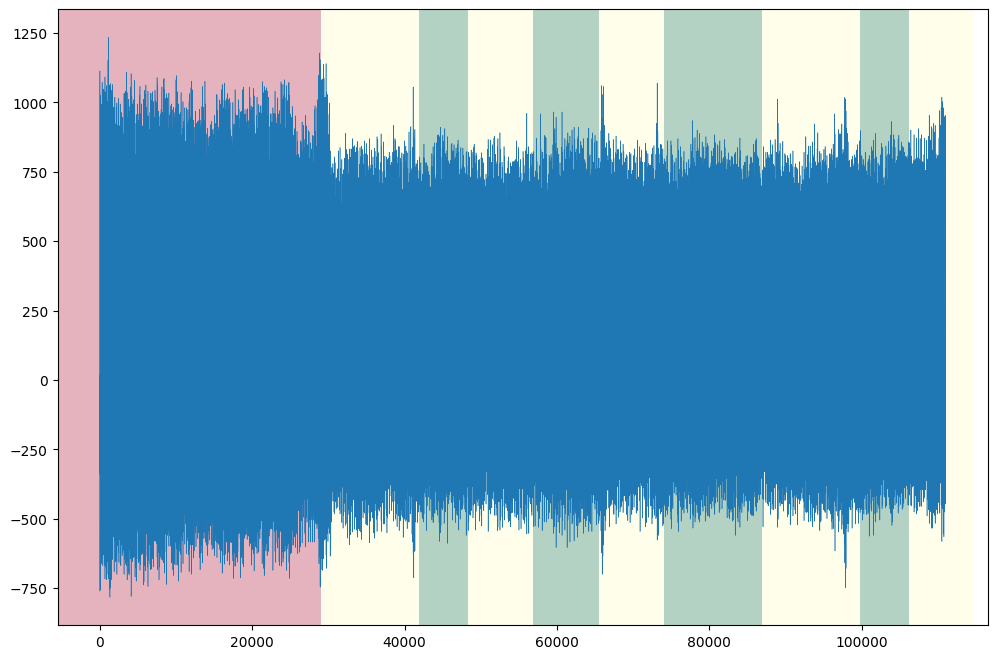

파일명: (M)115_20230611_102458_H10.csv
전체길이: 103879
     id             date protocol device                      start   
11  115  20230611_102458        M    H10 2023-06-11 10:24:58.564940  \

                          end                  total   
11 2023-06-11 10:38:20.374527 0 days 00:13:21.809587  \

                         avg          fs     mast_start_time      t  
11 0 days 00:00:00.007718687  129.567245 2023-06-11 10:20:00  10:25  
raw data:                         time     idx  sensor  marker  proc   
0       20230611102458564940       0    -248       0   NaN  \
1       20230611102458572632       1    -233       0   1.0   
2       20230611102458580324       2    -202       0   1.0   
3       20230611102458588017       3    -175       0   1.0   
4       20230611102458595709       4    -194       0   1.0   
...                      ...     ...     ...     ...   ...   
103874  20230611103820343758  103874    -119       0   NaN   
103875  20230611103820351450  103875    -121     

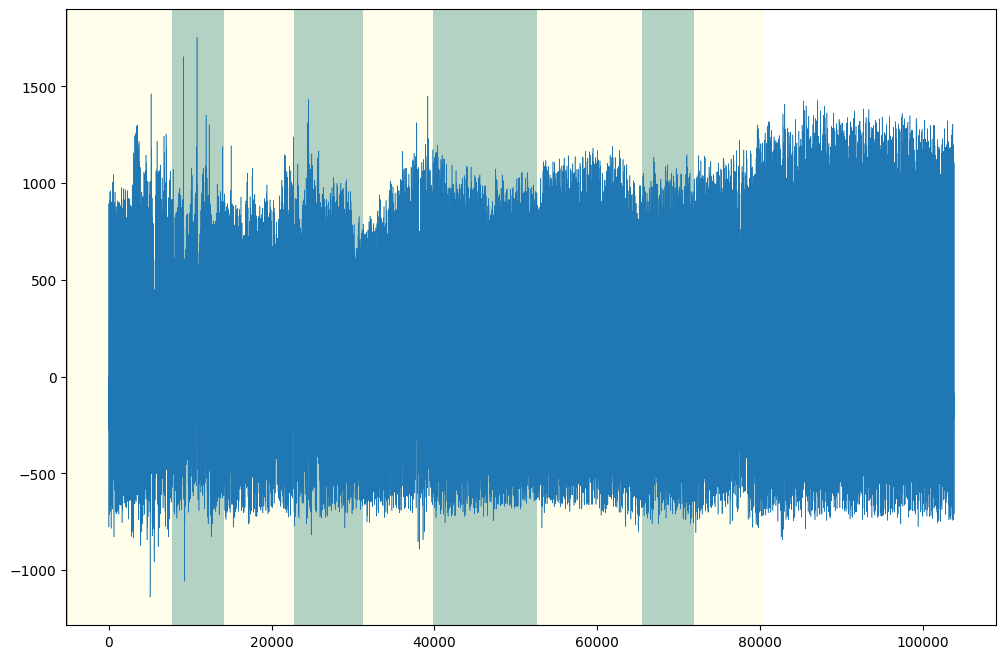

파일명: (M)116_20230611_102050_H10.csv
전체길이: 112639
     id             date protocol device                      start   
12  116  20230611_102050        M    H10 2023-06-11 10:20:50.670534  \

                          end                  total   
12 2023-06-11 10:35:17.469510 0 days 00:14:26.798976  \

                         avg          fs     mast_start_time      t  
12 0 days 00:00:00.007695371  129.954516 2023-06-11 10:20:00  10:25  
raw data:                         time     idx  sensor  marker  proc   
0       20230611102050670534       0     -44       0   NaN  \
1       20230611102050678226       1     -46       0   1.0   
2       20230611102050685918       2     -60       0   1.0   
3       20230611102050693611       3     -63       0   1.0   
4       20230611102050701303       4     -56       0   1.0   
...                      ...     ...     ...     ...   ...   
112634  20230611103517438741  112634      60       0   NaN   
112635  20230611103517446433  112635      84     

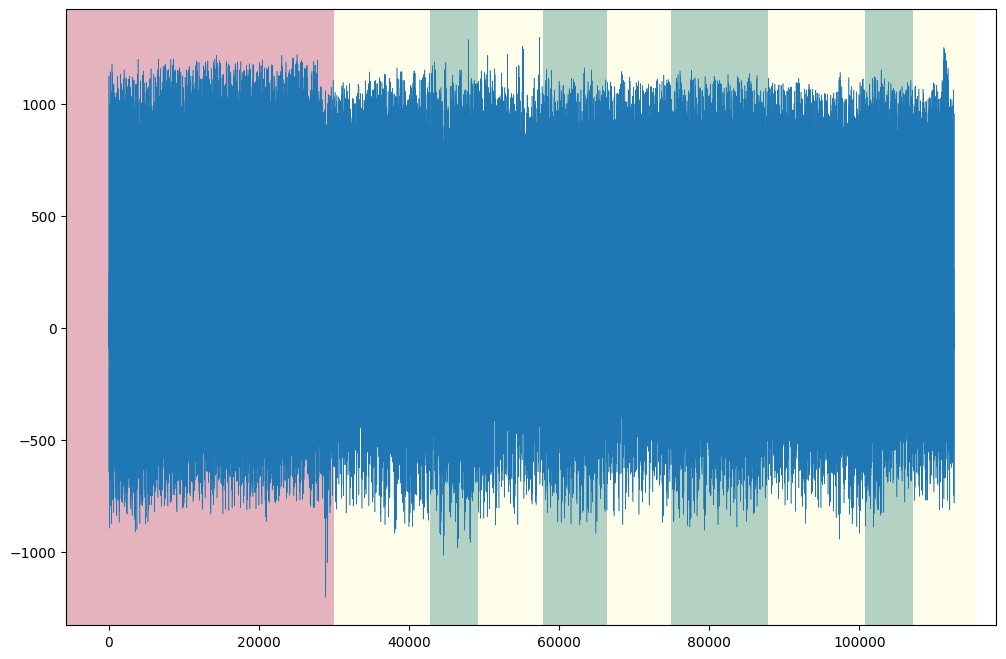

파일명: (M)117_20230611_120045_H10.csv
전체길이: 54157
     id             date protocol device                      start   
13  117  20230611_120045        M    H10 2023-06-11 12:00:45.356355  \

                          end                  total   
13 2023-06-11 12:07:42.128997 0 days 00:06:56.772642  \

                         avg          fs     mast_start_time      t  
13 0 days 00:00:00.007695637  129.954516 2023-06-11 12:05:00  12:10  
raw data:                        time    idx  sensor  marker  proc   
0      20230611120045356355      0    -111       0   NaN  \
1      20230611120045364047      1    -103       0   NaN   
2      20230611120045371739      2     -99       0   NaN   
3      20230611120045379432      3     -99       0   NaN   
4      20230611120045387124      4     -99       0   NaN   
...                     ...    ...     ...     ...   ...   
54152  20230611120742098228  54152     309       0   1.0   
54153  20230611120742105920  54153     734       0   1.0   
54154 

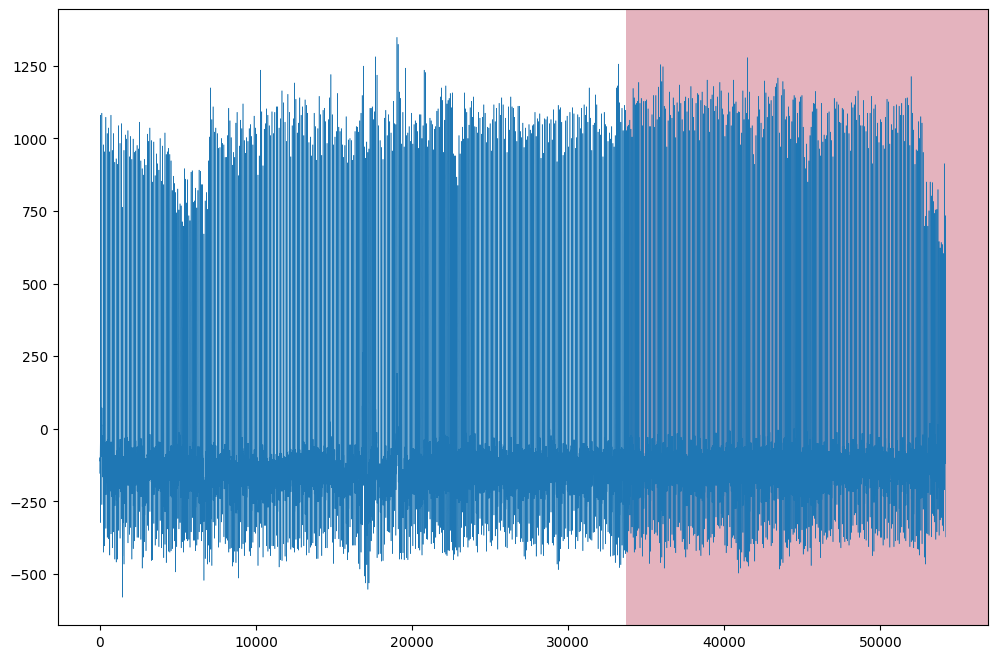

파일명: (M)117_20230611_122007_H10.csv
전체길이: 12337
     id             date protocol device                      start   
13  117  20230611_120045        M    H10 2023-06-11 12:00:45.356355  \

                          end                  total   
13 2023-06-11 12:07:42.128997 0 days 00:06:56.772642  \

                         avg          fs     mast_start_time      t  
13 0 days 00:00:00.007695637  129.954516 2023-06-11 12:05:00  12:10  
raw data:                        time    idx  sensor  marker  proc   
0      20230611122057121836      0     -41       0   NaN  \
1      20230611122057129528      1     -36       0   NaN   
2      20230611122057137220      2     -33       0   NaN   
3      20230611122057144913      3     -36       0   NaN   
4      20230611122057152605      4     -38       0   NaN   
...                     ...    ...     ...     ...   ...   
12332  20230611122232019691  12332     -12       0   NaN   
12333  20230611122232027383  12333    -186       0   NaN   
12334 

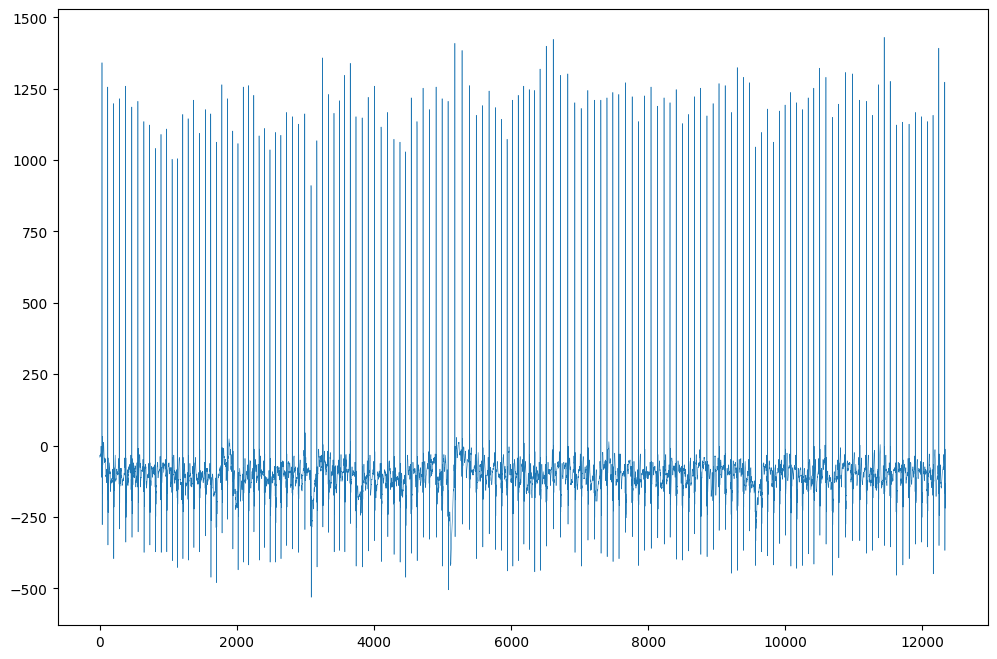

파일명: (M)118_20230611_104957_H10.csv
전체길이: 159067
     id             date protocol device                      start   
15  118  20230611_104957        M    H10 2023-06-11 10:49:57.880832  \

                          end                  total   
15 2023-06-11 11:10:22.029809 0 days 00:20:24.148977  \

                         avg          fs     mast_start_time      t  
15 0 days 00:00:00.007695807  129.954516 2023-06-11 10:55:00  11:00  
raw data:                         time     idx  sensor  marker  proc   
0       20230611104957880832       0    -132       0   NaN  \
1       20230611104957888524       1    -128       0   NaN   
2       20230611104957896216       2    -125       0   NaN   
3       20230611104957903909       3    -123       0   NaN   
4       20230611104957911601       4    -125       0   NaN   
...                      ...     ...     ...     ...   ...   
159062  20230611111021999040  159062    -123       0   NaN   
159063  20230611111022006732  159063    -106     

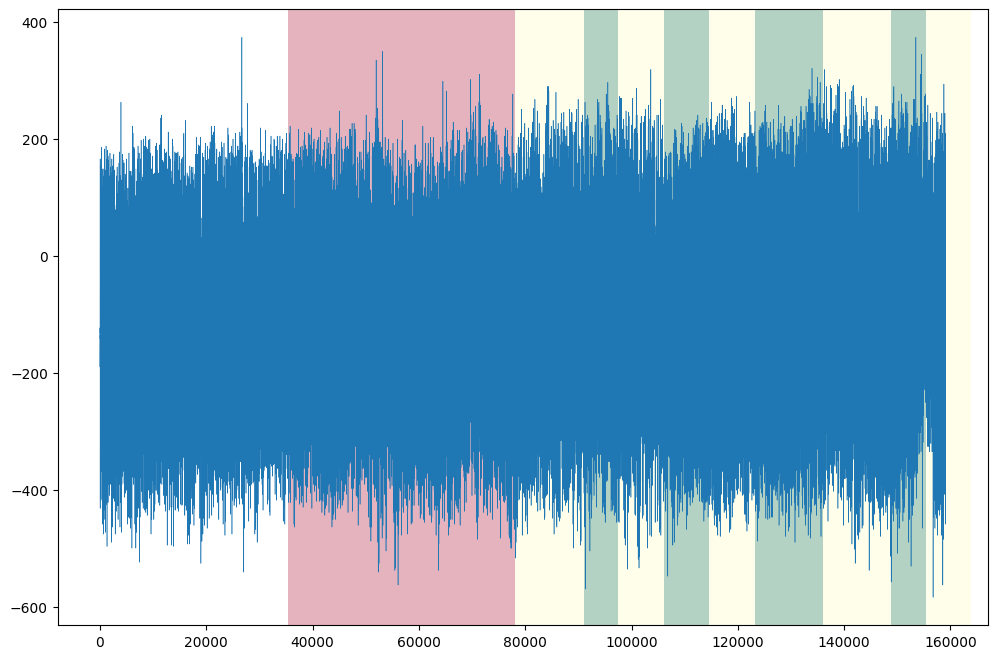

파일명: (M)119_20230611_105004_H10.csv
전체길이: 149650
     id             date protocol device                      start   
16  119  20230611_105004        M    H10 2023-06-11 10:50:04.716388  \

                          end                  total   
16 2023-06-11 11:09:16.288923 0 days 00:19:11.572535  \

                         avg          fs     mast_start_time      t  
16 0 days 00:00:00.007695105  129.954516 2023-06-11 10:54:00  10:59  
raw data:                         time     idx  sensor  marker  proc   
0       20230611105004716388       0    -562       0   NaN  \
1       20230611105004724080       1    -660       0   NaN   
2       20230611105004731772       2    -119       0   NaN   
3       20230611105004739465       3    -282       0   NaN   
4       20230611105004747157       4    -448       0   NaN   
...                      ...     ...     ...     ...   ...   
149645  20230611110916258154  149645    2330       0   NaN   
149646  20230611110916265846  149646    2408     

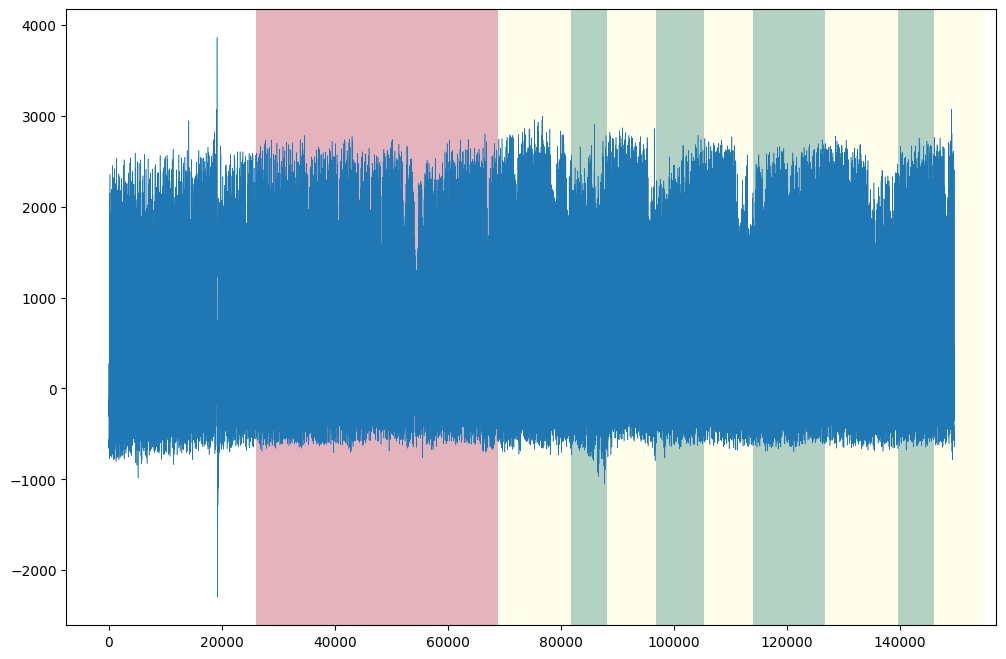

파일명: (M)120_20230611_112633_H10.csv
전체길이: 157315
     id             date protocol device                      start   
17  120  20230611_112633        M    H10 2023-06-11 11:26:33.316445  \

                          end                  total   
17 2023-06-11 11:46:43.975607 0 days 00:20:10.659162  \

                         avg          fs     mast_start_time      t  
17 0 days 00:00:00.007695764  129.954516 2023-06-11 11:30:00  11:35  
raw data:                         time     idx  sensor  marker  proc   
0       20230611112633316445       0     275       0   NaN  \
1       20230611112633324137       1     302       0   NaN   
2       20230611112633331829       2     302       0   NaN   
3       20230611112633339522       3     280       0   NaN   
4       20230611112633347214       4     246       0   NaN   
...                      ...     ...     ...     ...   ...   
157310  20230611114643944838  157310    -587       0   NaN   
157311  20230611114643952530  157311    -698     

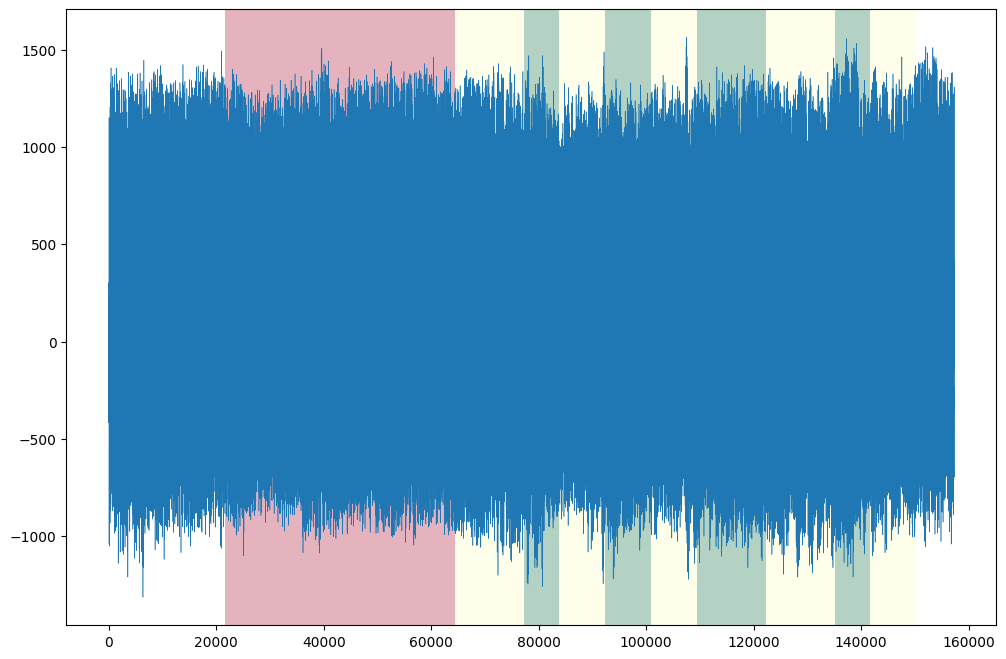

파일명: (M)121_20230611_105021_H10.csv
전체길이: 175638
     id             date protocol device                      start   
18  121  20230611_105021        M    H10 2023-06-11 10:50:21.090935  \

                          end                  total   
18 2023-06-11 11:12:57.052404 0 days 00:22:35.961469  \

                         avg          fs     mast_start_time      t  
18 0 days 00:00:00.007720205  129.533679 2023-06-11 10:55:00  11:00  
raw data:                         time     idx  sensor  marker  proc   
0       20230611105021090935       0     -90       0   NaN  \
1       20230611105021098627       1     -97       0   NaN   
2       20230611105021106319       2    -104       0   NaN   
3       20230611105021114012       3    -109       0   NaN   
4       20230611105021121704       4    -116       0   NaN   
...                      ...     ...     ...     ...   ...   
175633  20230611111257021635  175633      17       0   NaN   
175634  20230611111257029327  175634      14     

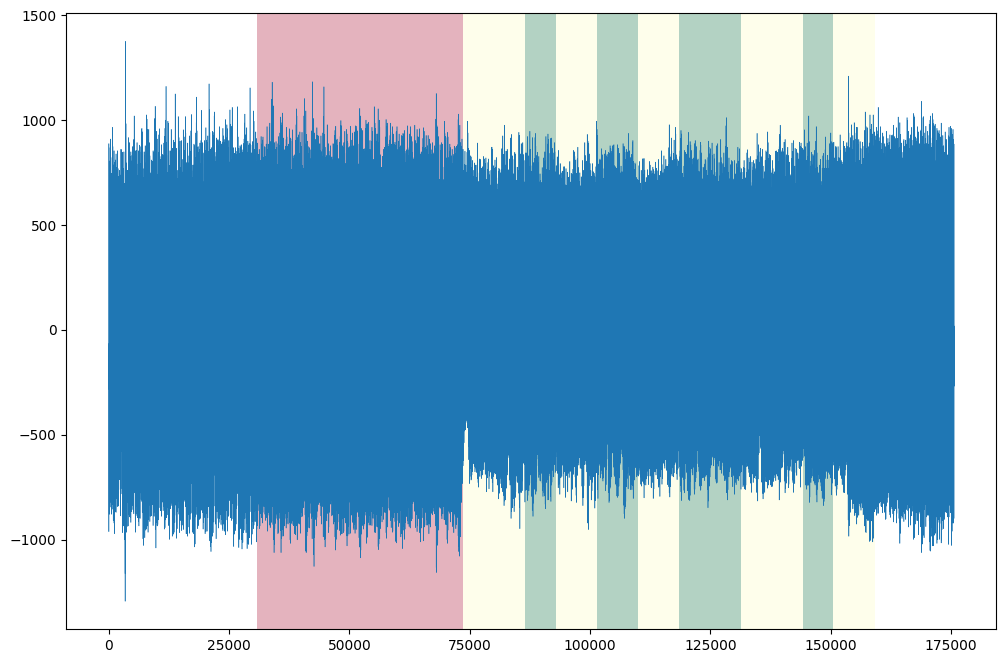

파일명: (M)122_20230611_122715_H10.csv
전체길이: 146219
     id             date protocol device                      start   
19  122  20230611_122715        M    H10 2023-06-11 12:27:15.439155  \

                          end                  total   
19 2023-06-11 12:46:00.586439 0 days 00:18:45.147284  \

                         avg          fs     mast_start_time      t  
19 0 days 00:00:00.007694945  129.971406 2023-06-11 11:31:00  11:36  
raw data:                         time     idx  sensor  marker  proc   
0       20230611122715439155       0     -28       0   NaN  \
1       20230611122715446847       1     -46       0   NaN   
2       20230611122715454539       2     -32       0   NaN   
3       20230611122715462232       3     -11       0   NaN   
4       20230611122715469924       4     -21       0   NaN   
...                      ...     ...     ...     ...   ...   
146214  20230611124600555670  146214     -39       0   NaN   
146215  20230611124600563362  146215     -32     

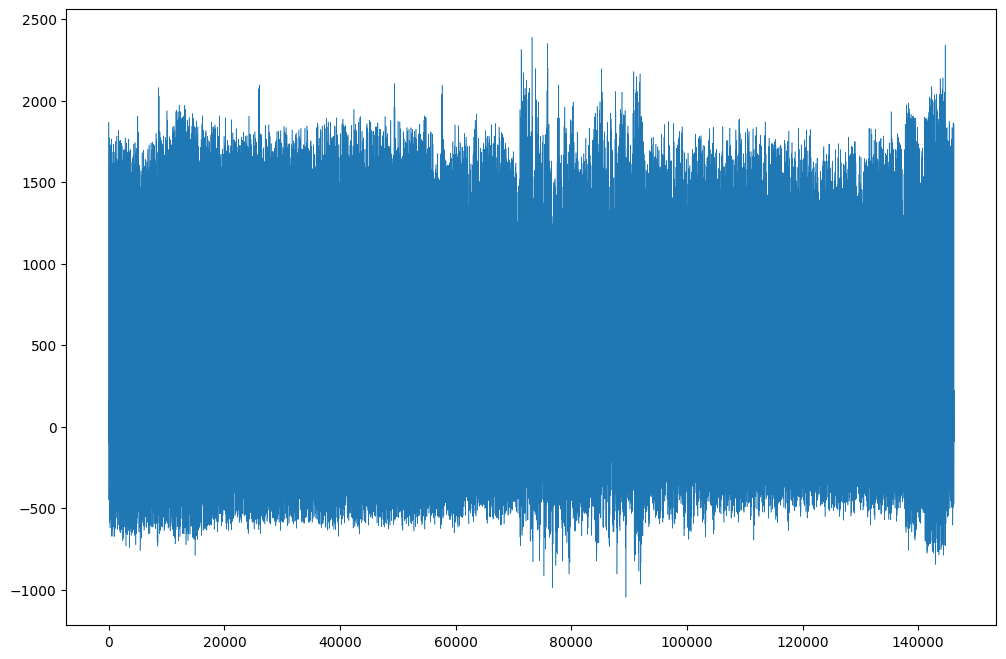

파일명: (M)123_20230611_122627_H10.csv
전체길이: 184544
     id             date protocol device                      start   
20  123  20230611_122627        M    H10 2023-06-11 12:26:27.531553  \

                          end                  total   
20 2023-06-11 12:50:12.277328 0 days 00:23:44.745775  \

                         avg          fs     mast_start_time      t  
20 0 days 00:00:00.007720358  129.533679 2023-06-11 12:32:00  12:37  
raw data:                         time     idx  sensor  marker  proc   
0       20230611122627531553       0    -207       0   NaN  \
1       20230611122627539245       1    -207       0   NaN   
2       20230611122627546937       2    -209       0   NaN   
3       20230611122627554630       3    -200       0   NaN   
4       20230611122627562322       4    -188       0   NaN   
...                      ...     ...     ...     ...   ...   
184539  20230611125012246559  184539     -87       0   NaN   
184540  20230611125012254251  184540     -89     

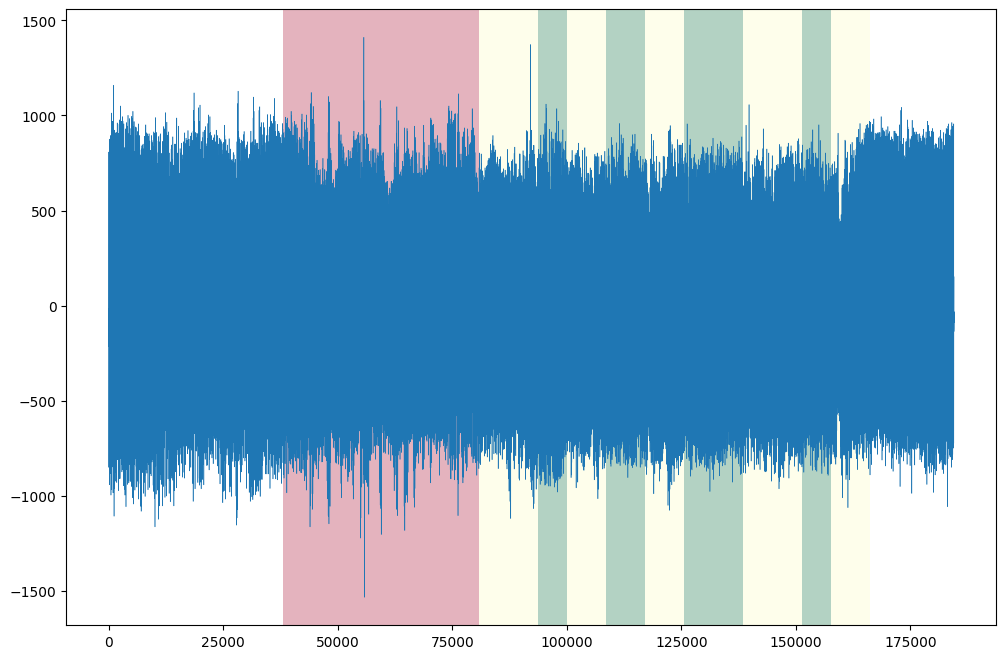

파일명: (M)124_20230611_112909_H10.csv
전체길이: 117092
     id             date protocol device                      start   
21  124  20230611_112909        M    H10 2023-06-11 11:29:09.379505  \

                          end                  total   
21 2023-06-11 11:44:10.374897 0 days 00:15:00.995392  \

                         avg          fs     mast_start_time      t  
21 0 days 00:00:00.007694764  129.971406 2023-06-11 11:29:00  11:34  
raw data:                         time     idx  sensor  marker  proc   
0       20230611112909379505       0     -14       0   NaN  \
1       20230611112909387197       1      -4       0   1.0   
2       20230611112909394889       2       0       0   1.0   
3       20230611112909402582       3       0       0   1.0   
4       20230611112909410274       4      16       0   1.0   
...                      ...     ...     ...     ...   ...   
117087  20230611114410344128  117087      49       0   NaN   
117088  20230611114410351820  117088     102     

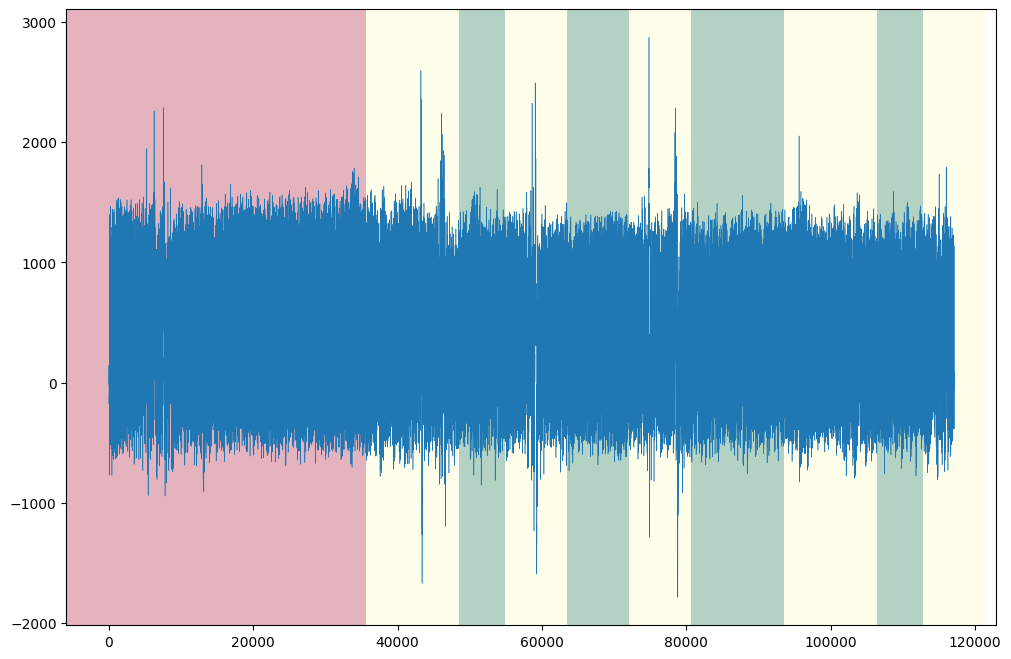

파일명: (M)125_20230611_112544_H10.csv
전체길이: 182573
     id             date protocol device                      start   
22  125  20230611_112544        M    H10 2023-06-11 11:25:44.815080  \

                          end                  total   
22 2023-06-11 11:49:14.439858 0 days 00:23:29.624778  \

                         avg          fs     mast_start_time      t  
22 0 days 00:00:00.007720883  129.533679 2023-06-11 11:31:00  11:36  
raw data:                         time     idx  sensor  marker  proc   
0       20230611112544815080       0    -185       0   NaN  \
1       20230611112544822772       1    -151       0   NaN   
2       20230611112544830464       2    -170       0   NaN   
3       20230611112544838157       3    -160       0   NaN   
4       20230611112544845849       4    -146       0   NaN   
...                      ...     ...     ...     ...   ...   
182568  20230611114914409089  182568     -94       0   NaN   
182569  20230611114914416781  182569    -108     

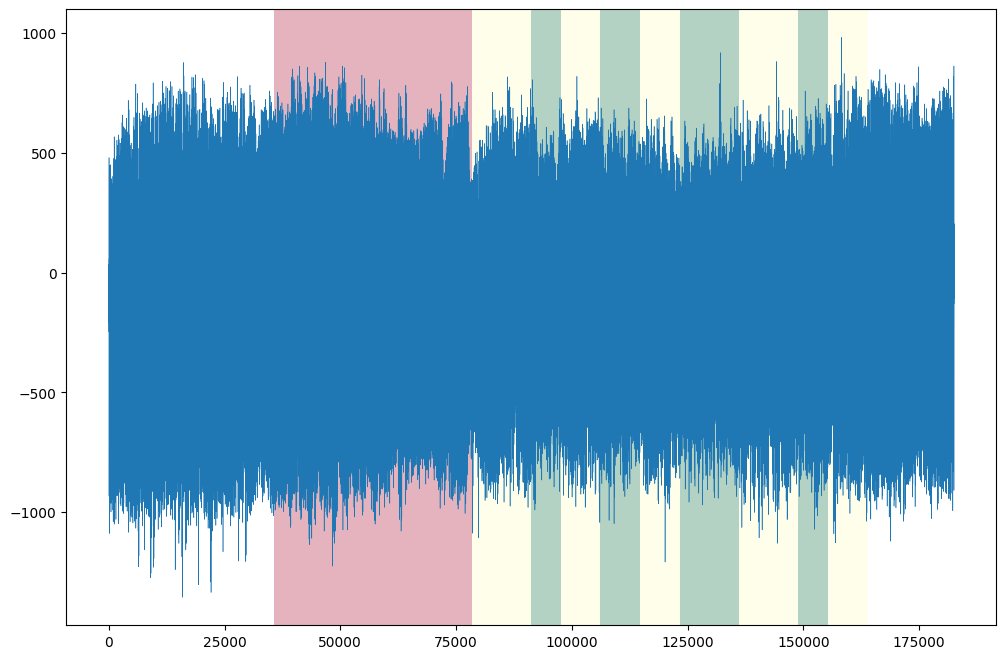

Verity
파일명: (M)065_20230611_115716_Verity_PPG.csv
전체길이: 69611
   id             date protocol      device                      start   
0  65  20230611_115716        M  Verity_PPG 2023-06-11 11:57:16.590299  \

                         end                  total                       avg   
0 2023-06-11 12:18:32.447423 0 days 00:21:15.857124 0 days 00:00:00.018328383  \

          fs     mast_start_time      t  
0  54.561327 2023-06-11 12:03:00  12:08  
raw data:                        time    idx   ppg0   ppg1   ppg2  ambient  marker   
0      20230611115716590299      0 -19431  26320  51604  -320468       0  \
1      20230611115716608580      1 -19392  26417  51736  -320500       0   
2      20230611115716626862      2 -19222  26597  51963  -320463       0   
3      20230611115716645143      3 -19134  26673  52083  -320470       0   
4      20230611115716663425      4 -19034  26877  52229  -320466       0   
...                     ...    ...    ...    ...    ...      ...     ...   


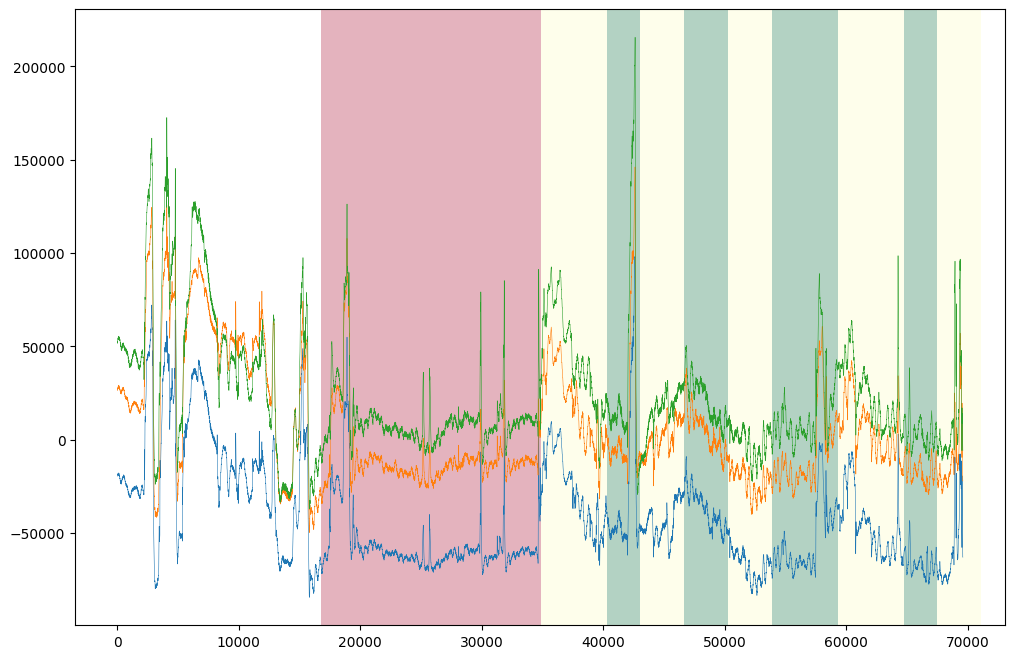

파일명: (M)105_20230611_085619_Verity_PPG.csv
전체길이: 65050
    id             date protocol      device                      start   
1  105  20230611_085619        M  Verity_PPG 2023-06-11 08:56:19.707637  \

                         end                  total                       avg   
1 2023-06-11 09:16:02.631456 0 days 00:19:42.923819 0 days 00:00:00.018184839  \

          fs     mast_start_time     t  
1  54.993401 2023-06-11 09:00:00  9:05  
raw data:                        time    idx   ppg0  ppg1   ppg2  ambient  marker  proc   
0      20230611085619707637      0 -11566 -1181  10385  -322589       0   NaN  \
1      20230611085619725918      1 -11724 -1393  10216  -322627       0   NaN   
2      20230611085619744200      2 -12149 -1832   9787  -322565       0   NaN   
3      20230611085619762481      3 -12805 -2433   9096  -322539       0   NaN   
4      20230611085619780763      4 -13467 -3152   8345  -322521       0   NaN   
...                     ...    ...    ...   ...    ..

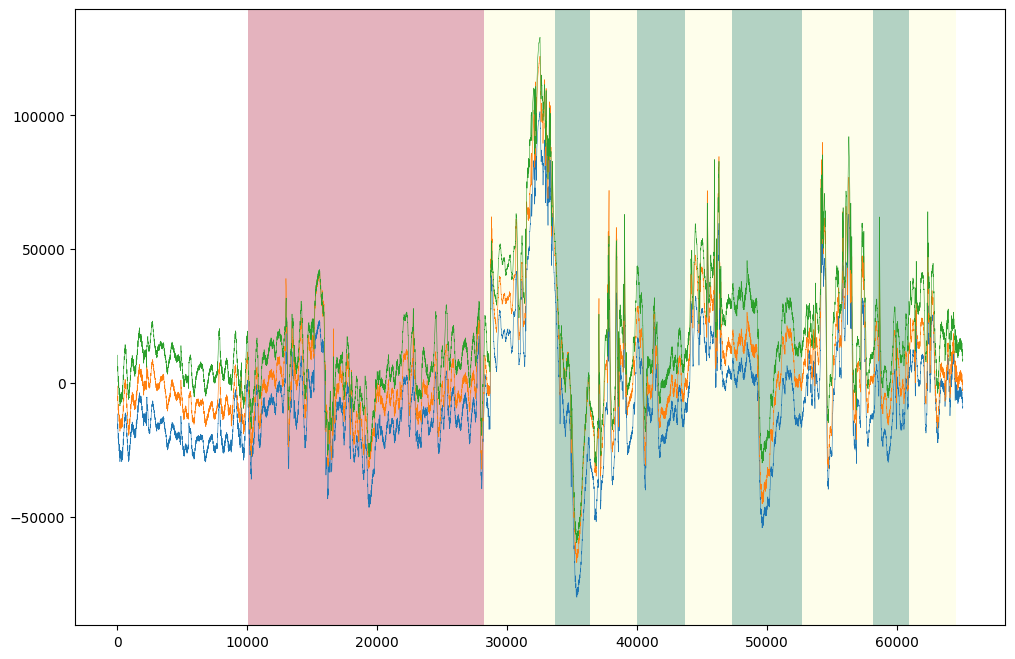

파일명: (M)106_20230611_100111_Verity_PPG.csv
전체길이: 48012
    id             date protocol      device                      start   
2  106  20230611_100111        M  Verity_PPG 2023-06-11 10:01:11.480186  \

                         end                  total                       avg   
2 2023-06-11 10:15:44.493937 0 days 00:14:33.013751 0 days 00:00:00.018183240  \

          fs     mast_start_time      t  
2  54.996425 2023-06-11 10:00:00  10:05  
raw data:                        time    idx    ppg0    ppg1    ppg2  ambient  marker   
0      20230611100111480186      0  216977  207744  247871    -1018       0  \
1      20230611100111498467      1  216926  207655  247734     -953       0   
2      20230611100111516749      2  216676  207501  247530    -1033       0   
3      20230611100111535030      3  216566  207337  247320    -1035       0   
4      20230611100111553312      4  216460  207267  247232    -1020       0   
...                     ...    ...     ...     ...     ...     

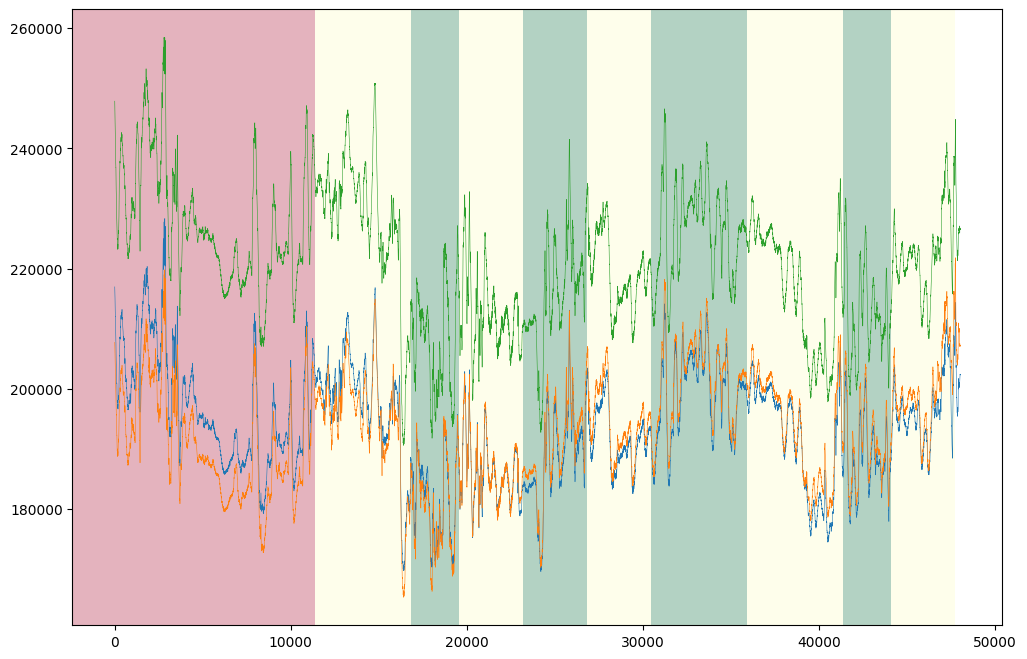

파일명: (M)107_20230611_100253_Verity_PPG.csv
전체길이: 40525
    id             date protocol      device                      start   
3  107  20230611_100253        M  Verity_PPG 2023-06-11 10:02:53.801681  \

                         end                  total                       avg   
3 2023-06-11 10:15:11.204094 0 days 00:12:17.402413 0 days 00:00:00.018196234  \

          fs     mast_start_time      t  
3  54.957133 2023-06-11 10:00:00  10:05  
raw data:                        time    idx    ppg0    ppg1    ppg2  ambient  marker   
0      20230611100253801681      0 -283714 -260032 -275696  -505001       0  \
1      20230611100253819963      1 -283622 -259914 -275603  -505085       0   
2      20230611100253838244      2 -283434 -259685 -275400  -505012       0   
3      20230611100253856526      3 -283303 -259533 -275280  -505091       0   
4      20230611100253874807      4 -283094 -259326 -275038  -505059       0   
...                     ...    ...     ...     ...     ...     

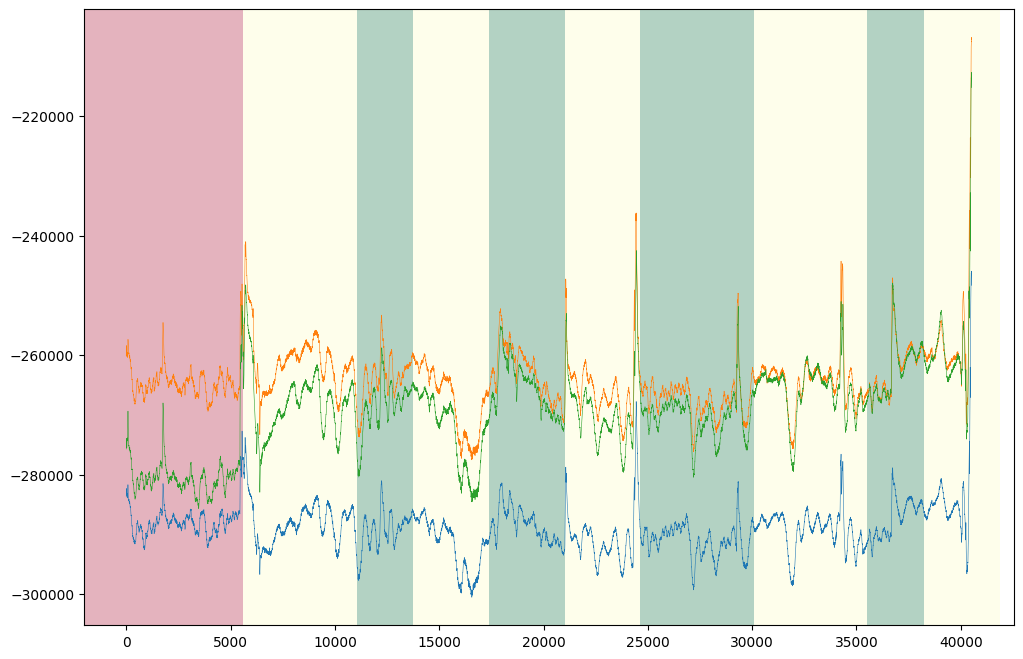

파일명: (M)108_20230611_093001_Verity_PPG.csv
전체길이: 66558
    id             date protocol      device                      start   
4  108  20230611_093001        M  Verity_PPG 2023-06-11 09:30:01.840628  \

                         end                  total                       avg   
4 2023-06-11 09:50:12.105625 0 days 00:20:10.264997 0 days 00:00:00.018183614  \

          fs     mast_start_time     t  
4  54.996425 2023-06-11 09:35:00  9:40  
raw data:                        time    idx    ppg0    ppg1    ppg2  ambient  marker   
0      20230611093001840628      0 -415021 -425911 -269240  -691158       0  \
1      20230611093001858910      1 -415226 -426084 -269562  -691150       0   
2      20230611093001877191      2 -415390 -426217 -269776  -691154       0   
3      20230611093001895473      3 -415596 -426407 -270047  -691131       0   
4      20230611093001913754      4 -415758 -426554 -270297  -691148       0   
...                     ...    ...     ...     ...     ...      .

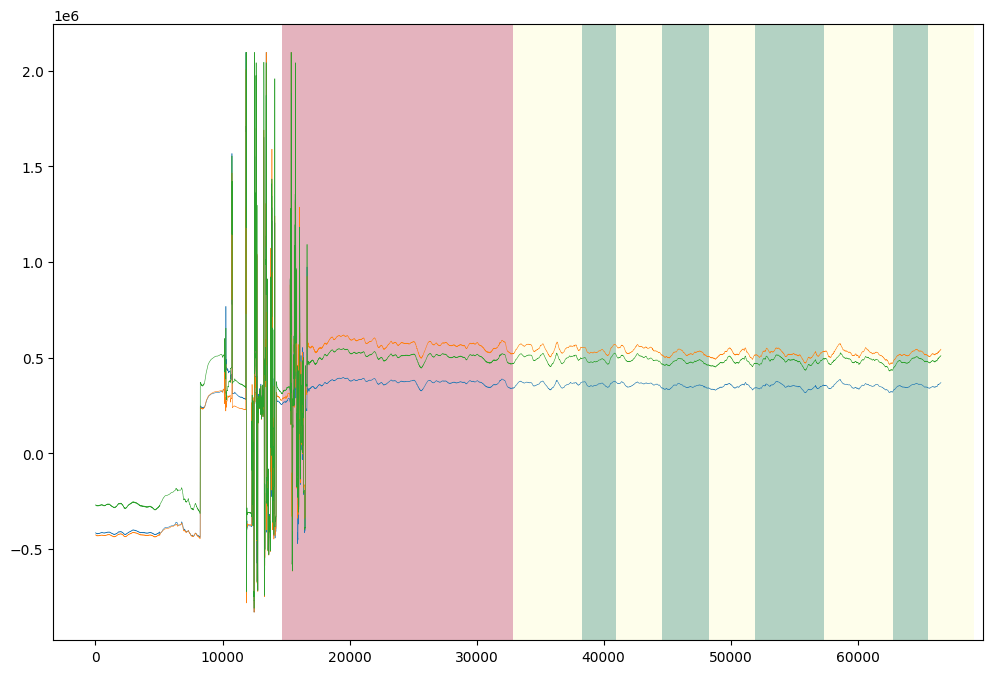

파일명: (M)109_20230611_085626_Verity_PPG.csv
전체길이: 68564
    id             date protocol      device                      start   
5  109  20230611_085626        M  Verity_PPG 2023-06-11 08:56:26.462563  \

                         end                  total                       avg   
5 2023-06-11 09:17:14.966567 0 days 00:20:48.504004 0 days 00:00:00.018209322  \

          fs     mast_start_time     t  
5  54.917898 2023-06-11 09:02:00  9:07  
raw data:                        time    idx    ppg0    ppg1    ppg2  ambient  marker   
0      20230611085626462563      0  581603  708878  661503   185241       0  \
1      20230611085626480845      1  581606  708880  661442   185307       0   
2      20230611085626499126      2  581531  708844  661329   185265       0   
3      20230611085626517408      3  581491  708740  661278   185261       0   
4      20230611085626535689      4  581457  708743  661184   185273       0   
...                     ...    ...     ...     ...     ...      .

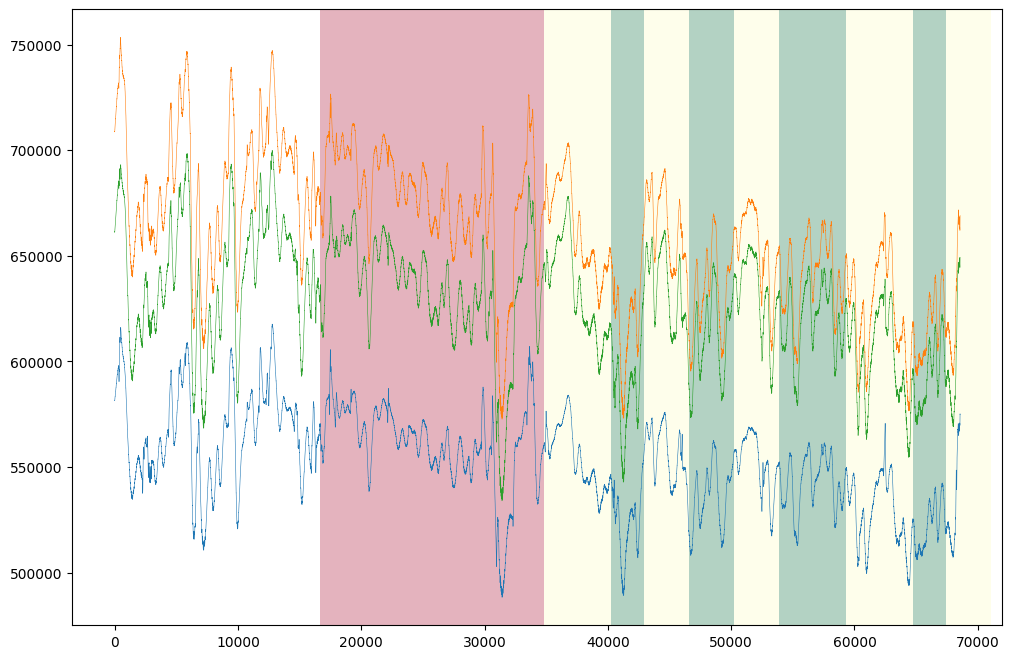

파일명: (M)110_20230611_085638_Verity_PPG.csv
전체길이: 78219
    id             date protocol      device                      start   
6  110  20230611_085638        M  Verity_PPG 2023-06-11 08:56:38.370862  \

                         end                  total                       avg   
6 2023-06-11 09:20:25.435863 0 days 00:23:47.065001 0 days 00:00:00.018244480  \

          fs     mast_start_time     t  
6  54.812541 2023-06-11 09:02:00  9:07  
raw data:                        time    idx    ppg0    ppg1    ppg2  ambient  marker   
0      20230611085638370862      0  285469  298053  256379   -91859       0  \
1      20230611085638389144      1  285414  297957  256323   -91897       0   
2      20230611085638407426      2  285436  297866  256342   -91828       0   
3      20230611085638425707      3  285346  297778  256290   -91837       0   
4      20230611085638443989      4  285373  297800  256329   -91817       0   
...                     ...    ...     ...     ...     ...      .

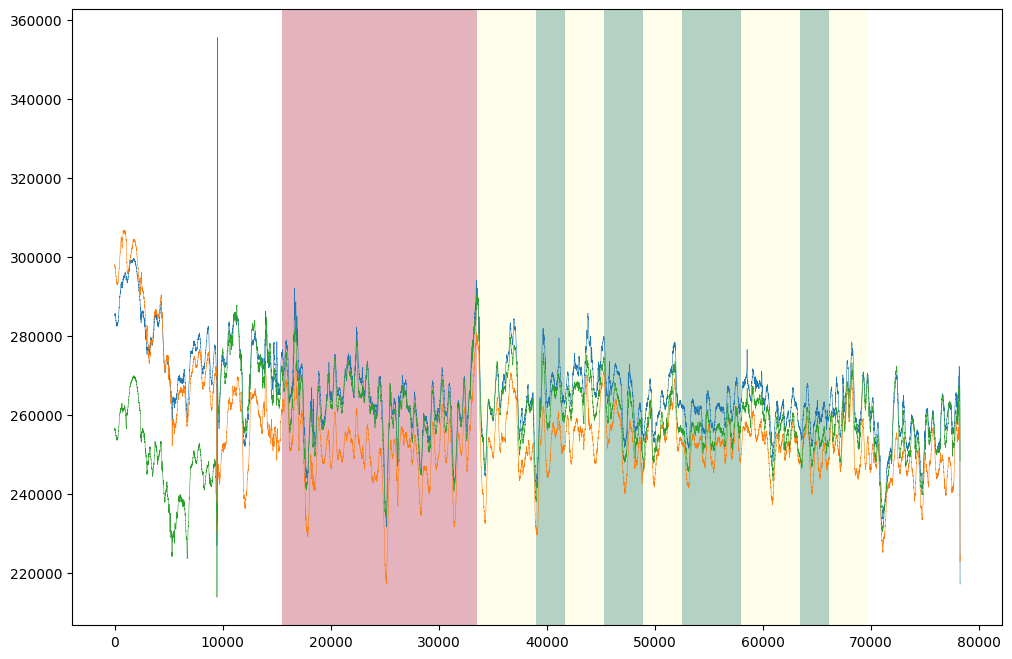

파일명: (M)111_20230611_100540_Verity_PPG.csv
전체길이: 45085
    id             date protocol      device                      start   
7  111  20230611_100540        M  Verity_PPG 2023-06-11 10:05:40.165069  \

                         end                  total                       avg   
7 2023-06-11 10:19:22.635746 0 days 00:13:42.470677 0 days 00:00:00.018242667  \

          fs     mast_start_time         t  
7  54.818551 2023-06-11 10:00:52  10:05:52  
raw data:                        time    idx    ppg0    ppg1    ppg2  ambient  marker   
0      20230611100540165069      0 -399543 -378044 -363227  -506685       0  \
1      20230611100540183351      1 -399522 -378049 -363217  -506686       0   
2      20230611100540201632      2 -399607 -378091 -363280  -506725       0   
3      20230611100540219914      3 -399594 -378115 -363316  -506662       0   
4      20230611100540238195      4 -399544 -378103 -363252  -506661       0   
...                     ...    ...     ...     ...     ..

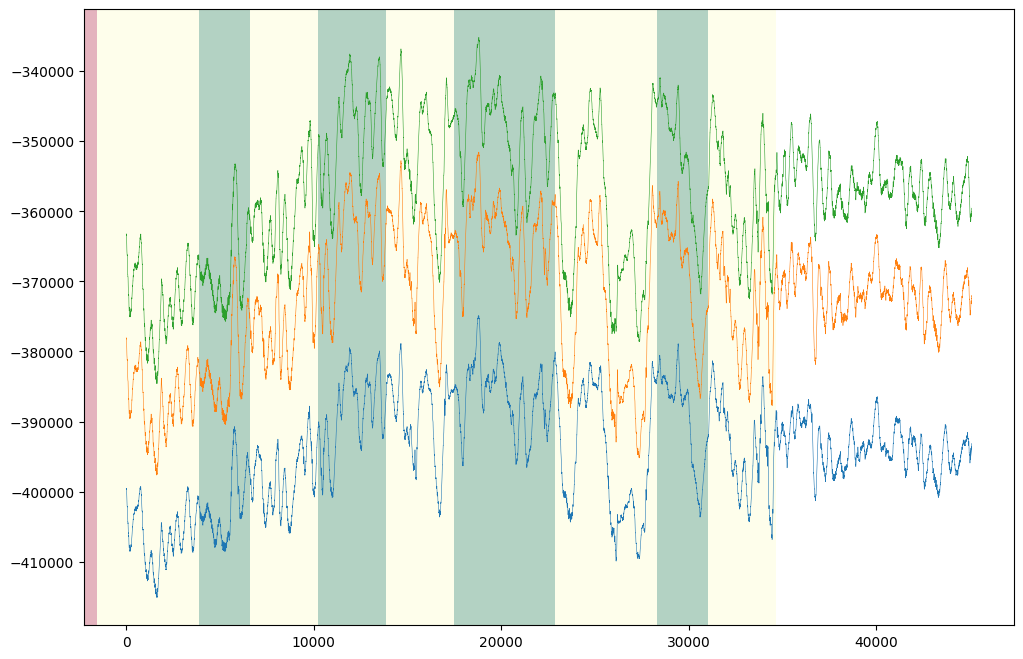

파일명: (M)112_20230611_092859_Verity_PPG.csv
전체길이: 68634
    id             date protocol      device                      start   
8  112  20230611_092859        M  Verity_PPG 2023-06-11 09:28:59.764633  \

                         end                  total                       avg   
8 2023-06-11 09:49:48.554061 0 days 00:20:48.789428 0 days 00:00:00.018194909  \

          fs     mast_start_time     t  
8  54.963175 2023-06-11 09:34:00  9:39  
raw data:                        time    idx    ppg0    ppg1    ppg2  ambient  marker   
0      20230611092859764633      0   36439   34829   71055  -252197       0  \
1      20230611092859782915      1   36653   35059   71274  -252153       0   
2      20230611092859801196      2   36780   35222   71438  -252160       0   
3      20230611092859819478      3   36951   35340   71581  -252217       0   
4      20230611092859837759      4   37162   35532   71853  -252175       0   
...                     ...    ...     ...     ...     ...      .

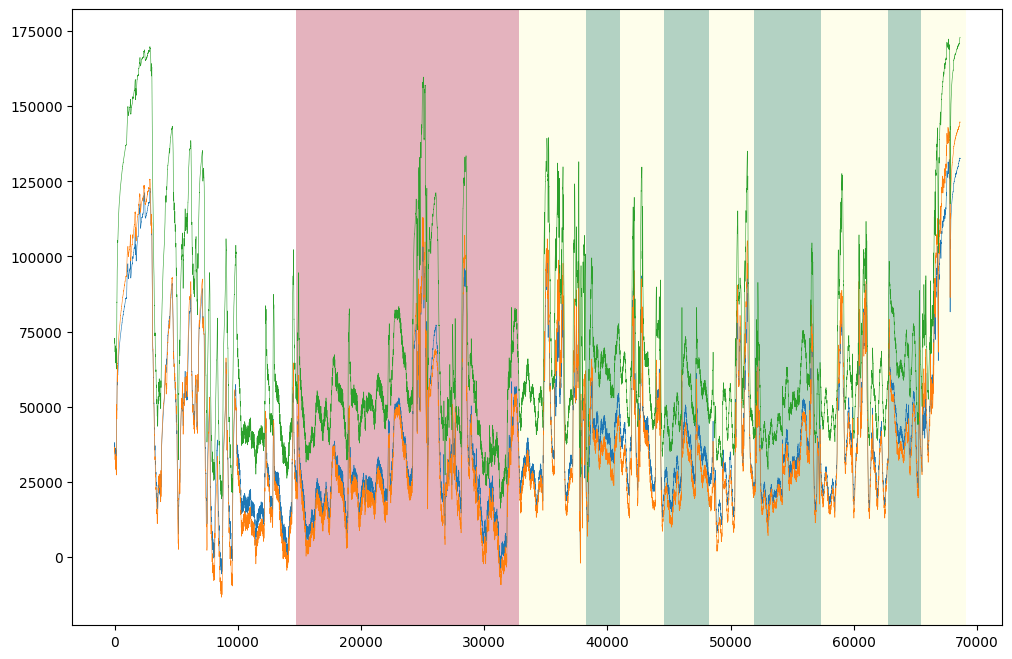

파일명: (M)113_20230611_093121_Verity_PPG.csv
전체길이: 78842
    id             date protocol      device                      start   
9  113  20230611_093121        M  Verity_PPG 2023-06-11 09:31:21.958542  \

                         end                  total                       avg   
9 2023-06-11 09:55:20.371147 0 days 00:23:58.412605 0 days 00:00:00.018244242  \

          fs     mast_start_time     t  
9  54.812541 2023-06-11 09:37:00  9:42  
raw data:                        time    idx    ppg0    ppg1    ppg2  ambient  marker   
0      20230611093121958542      0  237059  215136  181171  -183021       0  \
1      20230611093121976824      1  236761  214917  180999  -183027       0   
2      20230611093121995105      2  236499  214569  180761  -182927       0   
3      20230611093122013387      3  236271  214438  180592  -182992       0   
4      20230611093122031668      4  236094  214192  180408  -182990       0   
...                     ...    ...     ...     ...     ...      .

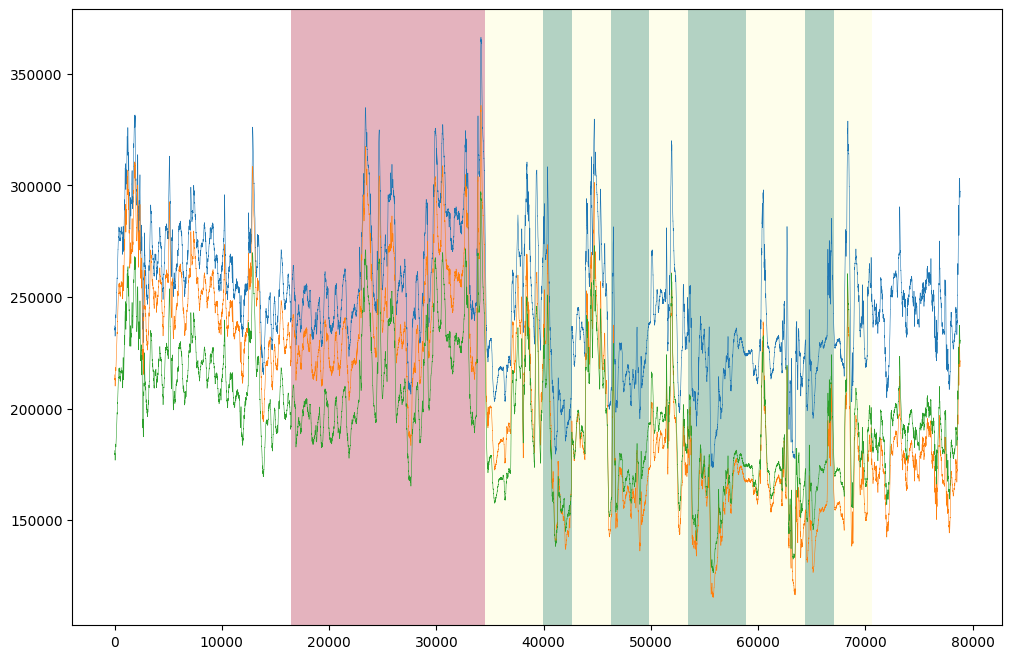

파일명: (M)114_20230611_102058_Verity_PPG.csv
전체길이: 46967
     id             date protocol      device                      start   
10  114  20230611_102058        M  Verity_PPG 2023-06-11 10:20:58.679158  \

                          end                  total   
10 2023-06-11 10:35:12.730333 0 days 00:14:14.051175  \

                         avg         fs     mast_start_time      t  
10 0 days 00:00:00.018184069  54.993401 2023-06-11 10:20:00  10:25  
raw data:                        time    idx    ppg0    ppg1    ppg2  ambient  marker   
0      20230611102058679158      0  474774  440468  457392   182793       0  \
1      20230611102058697440      1  474828  440423  457433   182802       0   
2      20230611102058715721      2  474805  440488  457412   182746       0   
3      20230611102058734003      3  474827  440547  457445   182744       0   
4      20230611102058752284      4  474926  440631  457554   182757       0   
...                     ...    ...     ...     ...     ..

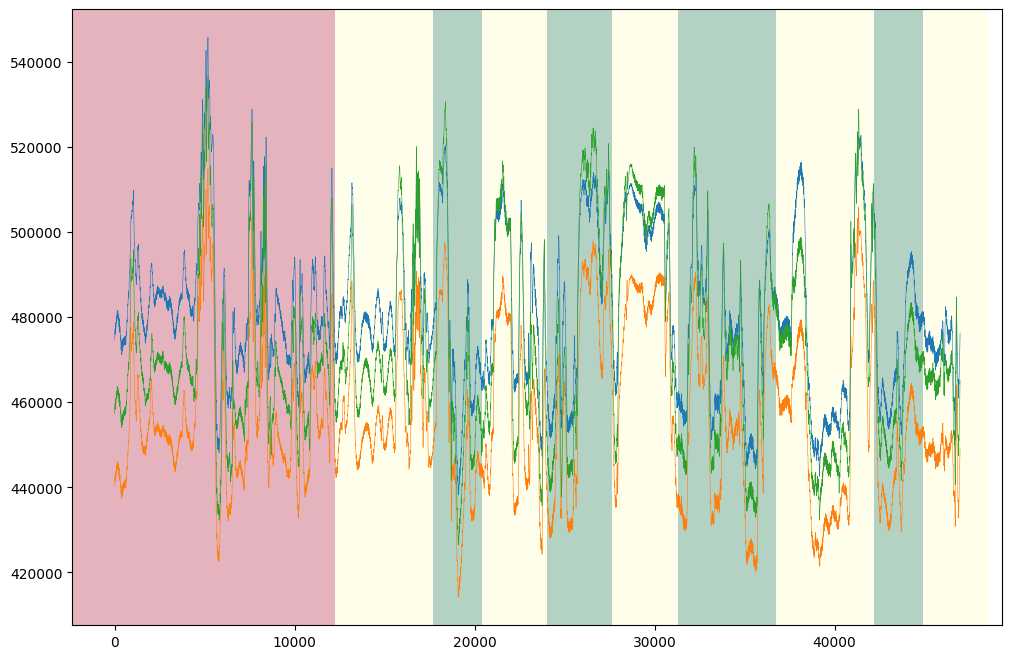

파일명: (M)115_20230611_102458_Verity_PPG.csv
전체길이: 43955
     id             date protocol      device                      start   
11  115  20230611_102458        M  Verity_PPG 2023-06-11 10:24:58.571783  \

                          end                  total   
11 2023-06-11 10:38:20.528488 0 days 00:13:21.956705  \

                         avg         fs     mast_start_time      t  
11 0 days 00:00:00.018244948  54.812541 2023-06-11 10:20:00  10:25  
raw data:                        time    idx    ppg0    ppg1    ppg2  ambient  marker   
0      20230611102458571783      0 -364215 -387511 -385865  -506743       0  \
1      20230611102458590065      1 -364150 -387379 -385765  -506676       0   
2      20230611102458608346      2 -364138 -387418 -385721  -506706       0   
3      20230611102458626628      3 -364104 -387346 -385777  -506721       0   
4      20230611102458644909      4 -364161 -387376 -385788  -506730       0   
...                     ...    ...     ...     ...     ..

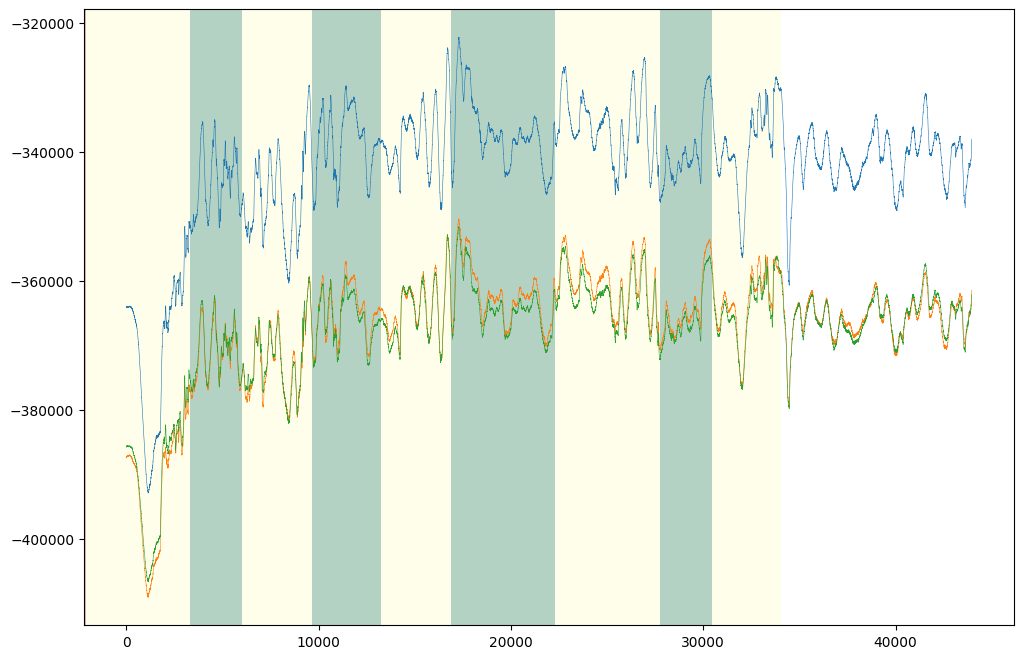

파일명: (M)116_20230611_102050_Verity_PPG.csv
전체길이: 47497
     id             date protocol      device                      start   
12  116  20230611_102050        M  Verity_PPG 2023-06-11 10:20:50.678053  \

                          end                  total   
12 2023-06-11 10:35:17.099795 0 days 00:14:26.421742  \

                         avg         fs     mast_start_time      t  
12 0 days 00:00:00.018241609  54.821556 2023-06-11 10:20:00  10:25  
raw data:                        time    idx    ppg0    ppg1   ppg2  ambient  marker   
0      20230611102050678053      0 -124041 -115640 -98497  -504172       0  \
1      20230611102050696334      1 -123887 -115426 -98301  -504172       0   
2      20230611102050714616      2 -123679 -115172 -98040  -504201       0   
3      20230611102050732897      3 -123419 -114844 -97783  -504161       0   
4      20230611102050751179      4 -123027 -114458 -97433  -504142       0   
...                     ...    ...     ...     ...    ...      

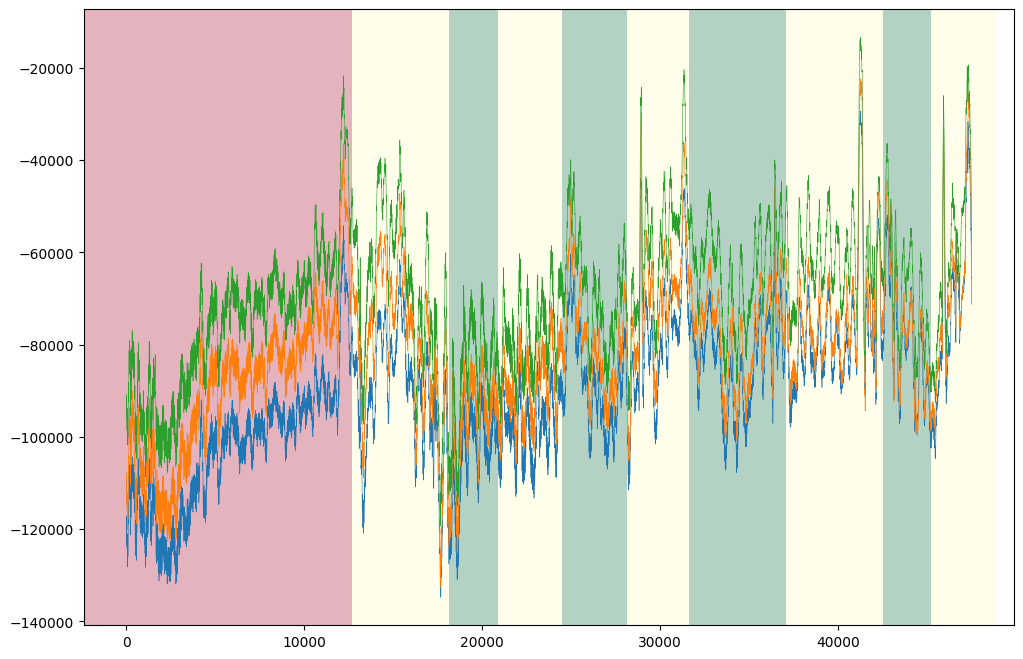

파일명: (M)117_20230611_120045_Verity_PPG.csv
전체길이: 23011
     id             date protocol      device                      start   
13  117  20230611_120045        M  Verity_PPG 2023-06-11 12:00:45.362562  \

                          end                  total   
13 2023-06-11 12:07:43.779329 0 days 00:06:58.416767  \

                         avg         fs     mast_start_time      t  
13 0 days 00:00:00.018183336  54.996425 2023-06-11 12:05:00  12:10  
raw data:                        time    idx    ppg0    ppg1    ppg2  ambient  marker   
0      20230611120045362562      0  224044  234140  272204    -1204       0  \
1      20230611120045380844      1  224074  234083  272134    -1164       0   
2      20230611120045399125      2  223998  234033  272044    -1197       0   
3      20230611120045417407      3  223755  233894  271824    -1241       0   
4      20230611120045435688      4  223575  233758  271613    -1217       0   
...                     ...    ...     ...     ...     ..

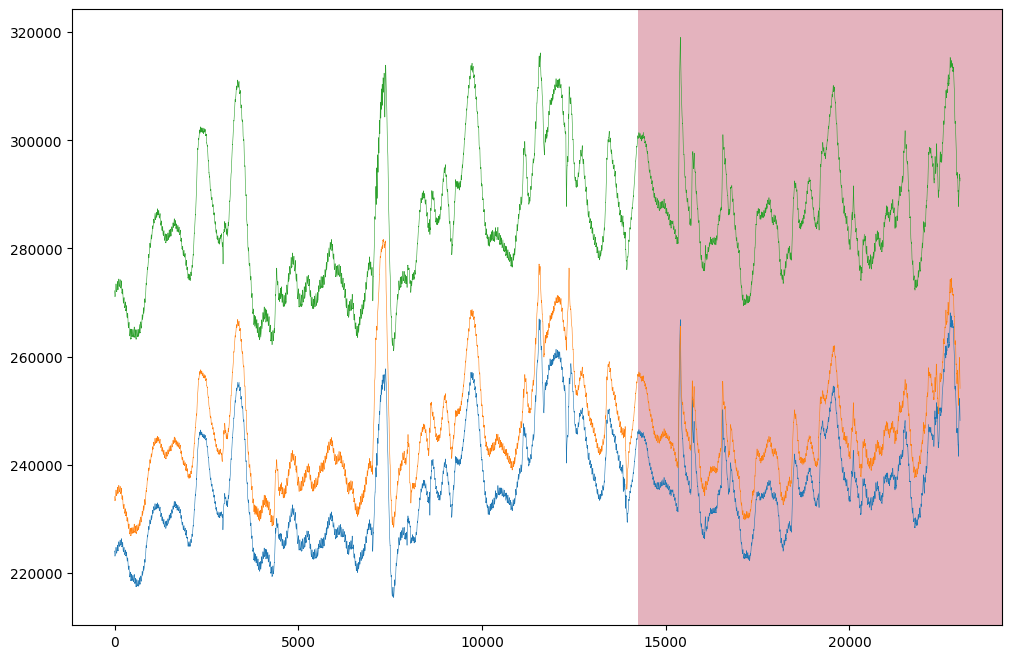

파일명: (M)117_20230611_122007_Verity_PPG.csv
전체길이: 6280
     id             date protocol      device                      start   
13  117  20230611_120045        M  Verity_PPG 2023-06-11 12:00:45.362562  \

                          end                  total   
13 2023-06-11 12:07:43.779329 0 days 00:06:58.416767  \

                         avg         fs     mast_start_time      t  
13 0 days 00:00:00.018183336  54.996425 2023-06-11 12:05:00  12:10  
raw data:                       time   idx    ppg0    ppg1    ppg2  ambient  marker   
0     20230611122007509395     0  257477  266561  301927    -1198       0  \
1     20230611122007527676     1  256991  266127  301423    -1227       0   
2     20230611122007545958     2  256613  265771  301054    -1243       0   
3     20230611122007564239     3  256257  265379  300710    -1170       0   
4     20230611122007582521     4  255903  265111  300369    -1215       0   
...                    ...   ...     ...     ...     ...      ...     

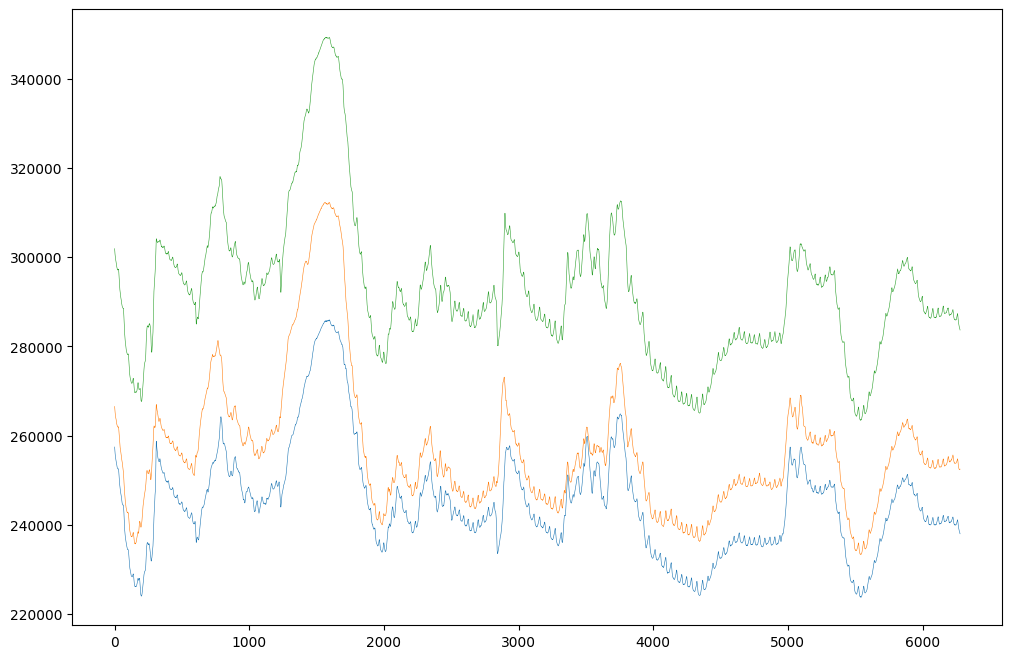

파일명: (M)118_20230611_104957_Verity_PPG.csv
전체길이: 67353
     id             date protocol      device                      start   
15  118  20230611_104957        M  Verity_PPG 2023-06-11 10:49:57.887075  \

                          end                  total   
15 2023-06-11 11:10:22.600970 0 days 00:20:24.713895  \

                         avg         fs     mast_start_time      t  
15 0 days 00:00:00.018183509  54.996425 2023-06-11 10:55:00  11:00  
raw data:                        time    idx    ppg0    ppg1    ppg2  ambient  marker   
0      20230611104957887075      0 -229605 -253541  -40168  -691158       0  \
1      20230611104957905357      1 -229511 -253469  -40100  -691178       0   
2      20230611104957923638      2 -229452 -253494  -40005  -691148       0   
3      20230611104957941920      3 -229392 -253476  -39954  -691139       0   
4      20230611104957960201      4 -229472 -253449  -39910  -691236       0   
...                     ...    ...     ...     ...     ..

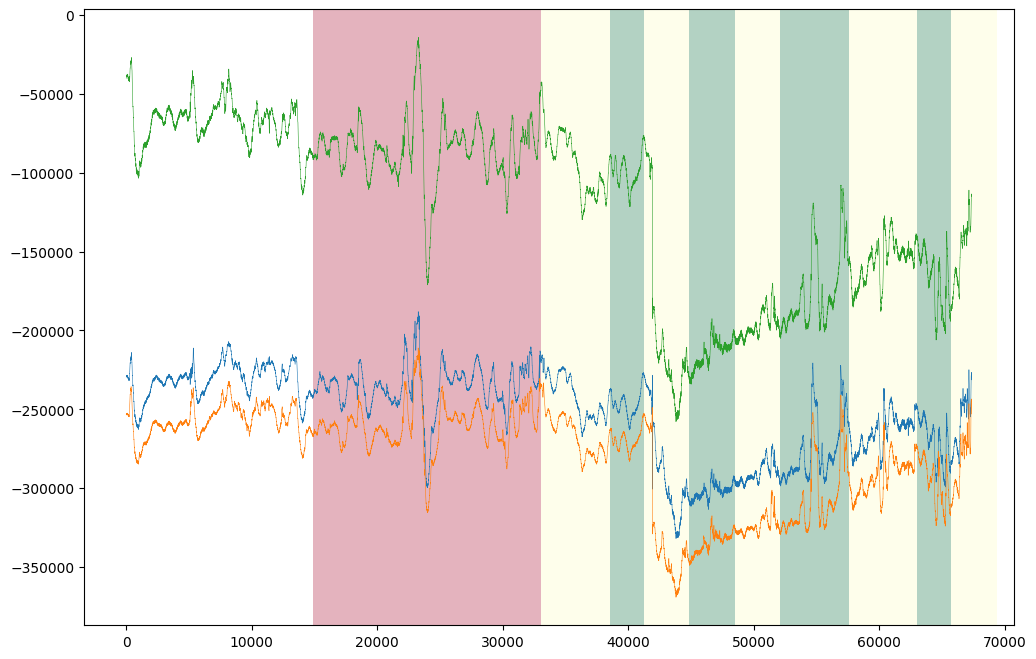

파일명: (M)119_20230611_105004_Verity_PPG.csv
전체길이: 63249
     id             date protocol      device                      start   
16  119  20230611_105004        M  Verity_PPG 2023-06-11 10:50:04.723202  \

                          end                  total   
16 2023-06-11 11:09:15.754061 0 days 00:19:11.030859  \

                         avg         fs     mast_start_time      t  
16 0 days 00:00:00.018198404  54.951094 2023-06-11 10:54:00  10:59  
raw data:                        time    idx   ppg0    ppg1   ppg2  ambient  marker   
0      20230611105004723202      0 -39942 -118673  49682  -504883       0  \
1      20230611105004741484      1 -39956 -118763  49593  -504872       0   
2      20230611105004759765      2 -40082 -118865  49386  -504857       0   
3      20230611105004778047      3 -40152 -118998  49254  -504877       0   
4      20230611105004796328      4 -40271 -119020  49107  -504923       0   
...                     ...    ...    ...     ...    ...      ...    

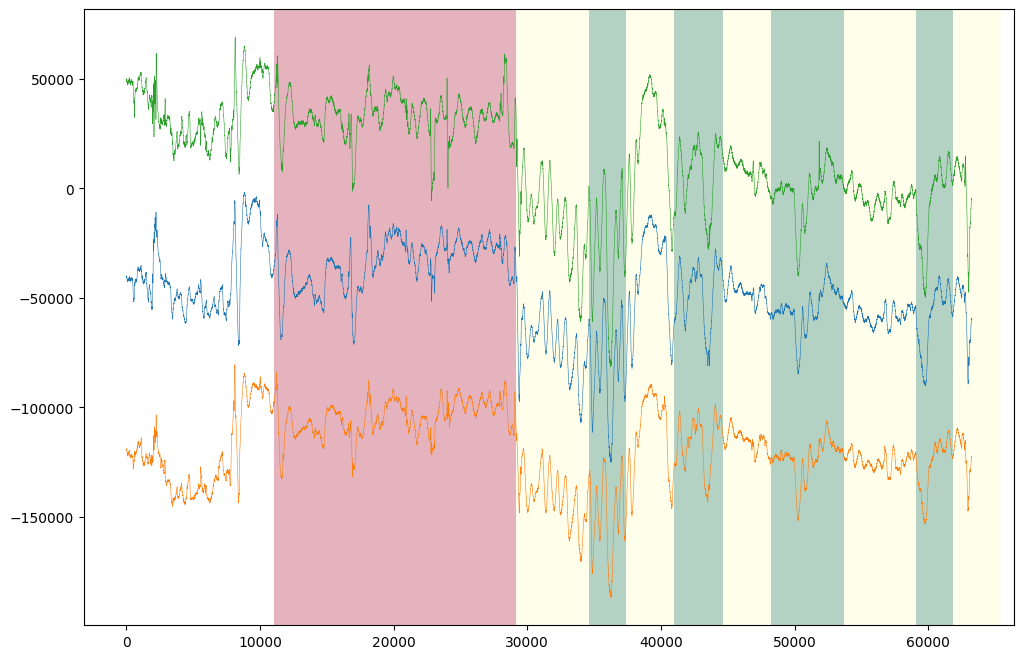

파일명: (M)120_20230611_112633_Verity_PPG.csv
전체길이: 66583
     id             date protocol      device                      start   
17  120  20230611_112633        M  Verity_PPG 2023-06-11 11:26:33.323136  \

                          end                  total   
17 2023-06-11 11:46:43.993248 0 days 00:20:10.670112  \

                         avg        fs     mast_start_time      t  
17 0 days 00:00:00.018182871  54.99945 2023-06-11 11:30:00  11:35  
raw data:                        time    idx    ppg0   ppg1    ppg2  ambient  marker   
0      20230611112633323136      0   99229  82661  156300  -185066       0  \
1      20230611112633341418      1   99654  83050  156663  -185047       0   
2      20230611112633359699      2   99889  83235  156863  -185094       0   
3      20230611112633377981      3  100199  83666  156963  -185102       0   
4      20230611112633396262      4  100639  84227  157304  -185160       0   
...                     ...    ...     ...    ...     ...      ..

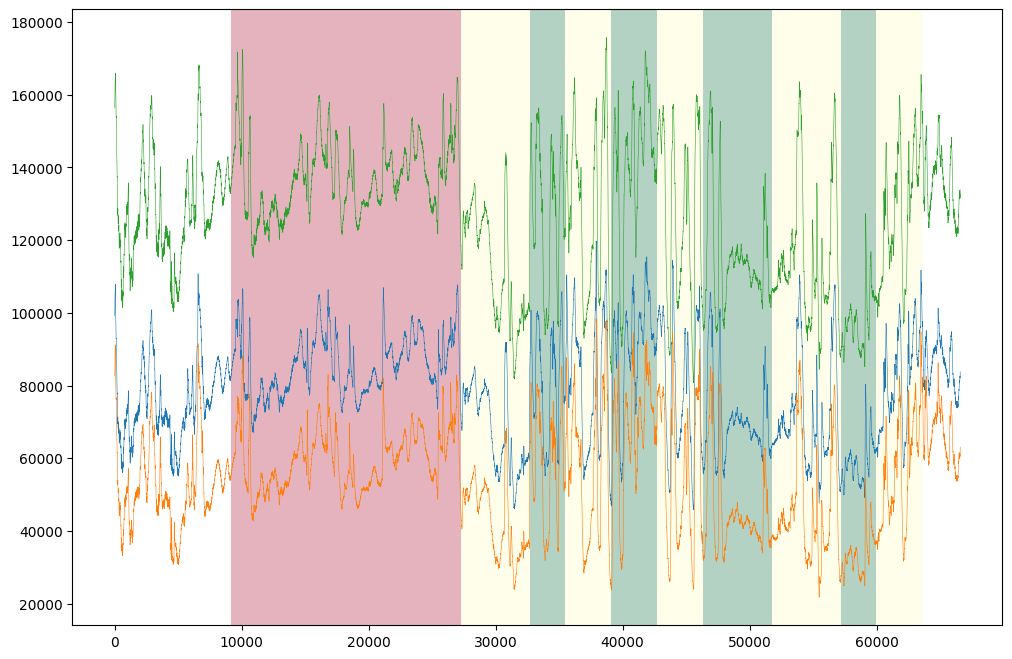

파일명: (M)121_20230611_105021_Verity_PPG.csv
전체길이: 74316
     id             date protocol      device                      start   
18  121  20230611_105021        M  Verity_PPG 2023-06-11 10:50:21.098065  \

                          end                  total   
18 2023-06-11 11:12:57.037035 0 days 00:22:35.938970  \

                         avg         fs     mast_start_time      t  
18 0 days 00:00:00.018245586  54.809537 2023-06-11 10:55:00  11:00  
raw data:                        time    idx    ppg0    ppg1    ppg2  ambient  marker   
0      20230611105021098065      0  153489  321855  152343  -321760       0  \
1      20230611105021116347      1  153623  322065  152492  -321740       0   
2      20230611105021134628      2  153940  322334  152738  -321619       0   
3      20230611105021152910      3  154193  322447  152875  -321610       0   
4      20230611105021171191      4  154375  322615  152971  -321667       0   
...                     ...    ...     ...     ...     ..

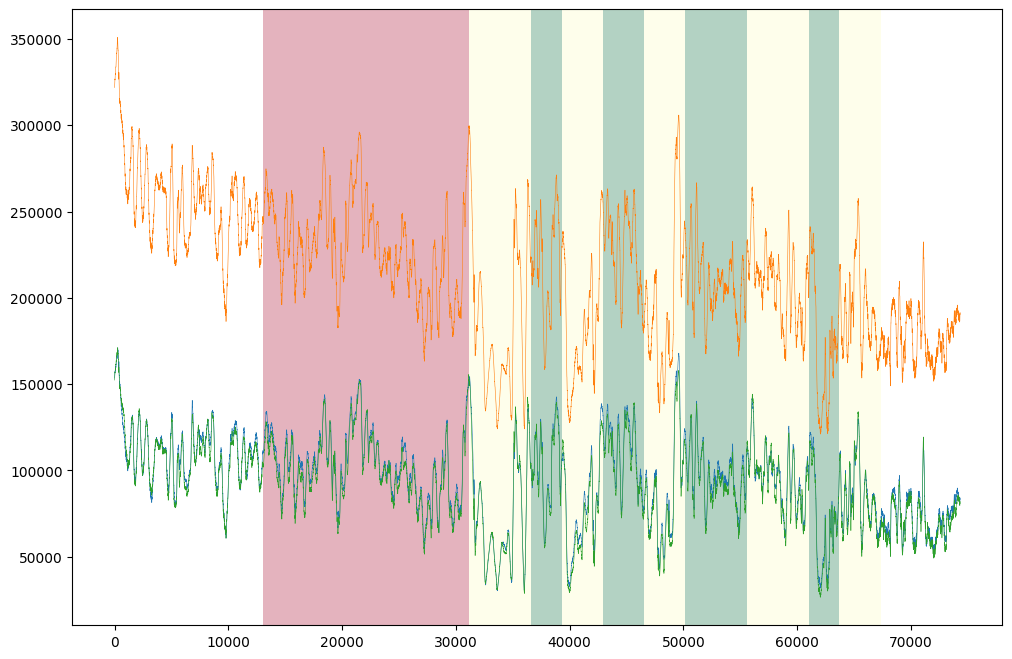

파일명: (M)122_20230611_122715_Verity_PPG.csv
전체길이: 61853
     id             date protocol      device                      start   
19  122  20230611_122715        M  Verity_PPG 2023-06-11 12:27:15.446508  \

                          end                  total   
19 2023-06-11 12:46:00.833755 0 days 00:18:45.387247  \

                         avg         fs     mast_start_time      t  
19 0 days 00:00:00.018194545  54.963175 2023-06-11 11:31:00  11:36  
raw data:                        time    idx    ppg0    ppg1    ppg2  ambient  marker   
0      20230611122715446508      0  177979  111923  119148  -159592       0  \
1      20230611122715464790      1  177547  111601  118781  -159637       0   
2      20230611122715483071      2  177199  111218  118548  -159646       0   
3      20230611122715501353      3  176894  111063  118319  -159628       0   
4      20230611122715519634      4  176558  110745  118070  -159618       0   
...                     ...    ...     ...     ...     ..

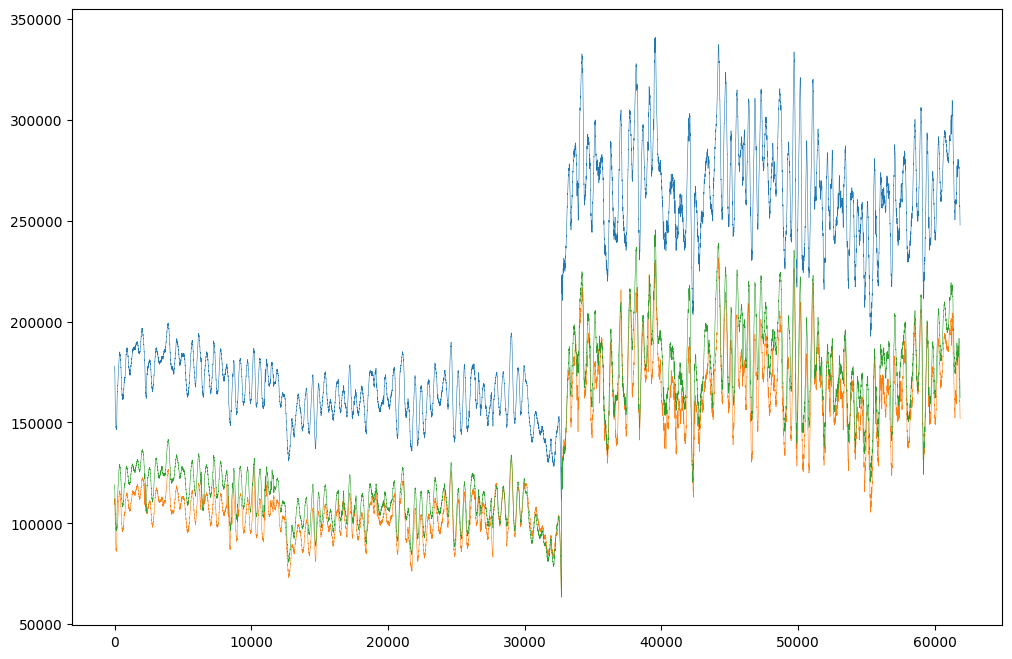

파일명: (M)123_20230611_122627_Verity_PPG.csv
전체길이: 78099
     id             date protocol      device                      start   
20  123  20230611_122627        M  Verity_PPG 2023-06-11 12:26:27.538500  \

                          end                  total   
20 2023-06-11 12:50:11.950648 0 days 00:23:44.412148  \

                         avg         fs     mast_start_time      t  
20 0 days 00:00:00.018238545  54.830574 2023-06-11 12:32:00  12:37  
raw data:                        time    idx    ppg0   ppg1   ppg2  ambient  marker   
0      20230611122627538500      0  122133  72846  92326  -322279       0  \
1      20230611122627556782      1  122190  72801  92381  -322300       0   
2      20230611122627575063      2  122214  72764  92379  -322296       0   
3      20230611122627593345      3  122179  72703  92337  -322266       0   
4      20230611122627611626      4  122011  72579  92178  -322241       0   
...                     ...    ...     ...    ...    ...      ...    

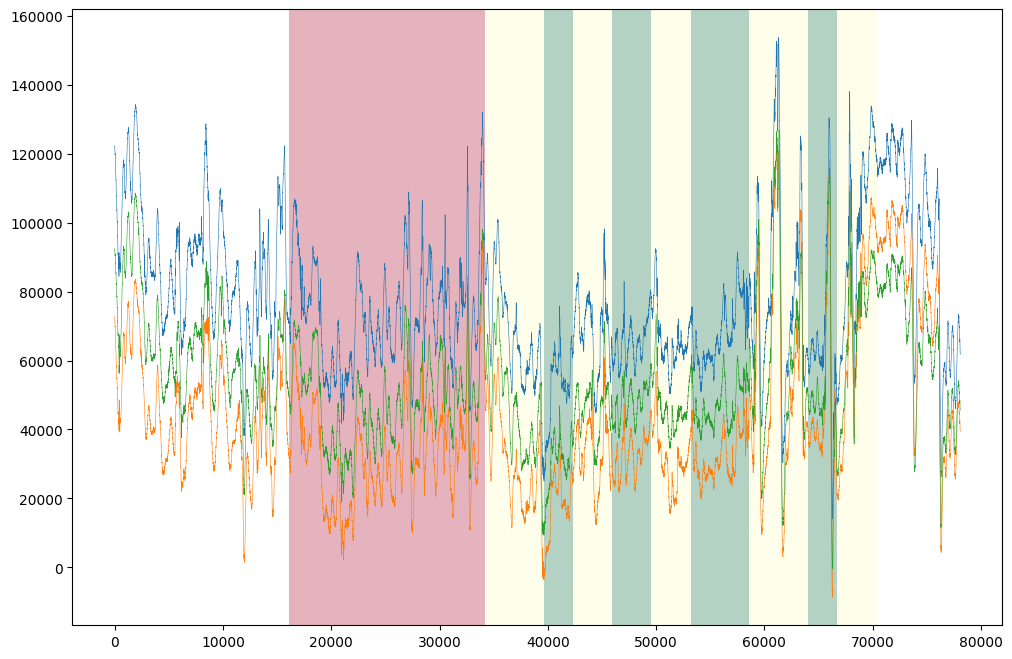

파일명: (M)124_20230611_112909_Verity_PPG.csv
전체길이: 49497
     id             date protocol      device                      start   
21  124  20230611_112909        M  Verity_PPG 2023-06-11 11:29:09.386238  \

                          end                  total   
21 2023-06-11 11:44:09.785499 0 days 00:15:00.399261  \

                         avg         fs     mast_start_time      t  
21 0 days 00:00:00.018190986  54.975261 2023-06-11 11:29:00  11:34  
raw data:                        time    idx    ppg0    ppg1    ppg2  ambient  marker   
0      20230611112909386238      0  118995  292151  114867  -320479       0  \
1      20230611112909404519      1  119000  291926  114674  -320446       0   
2      20230611112909422801      2  118926  291720  114568  -320409       0   
3      20230611112909441082      3  118789  291582  114389  -320483       0   
4      20230611112909459364      4  118755  291405  114341  -320467       0   
...                     ...    ...     ...     ...     ..

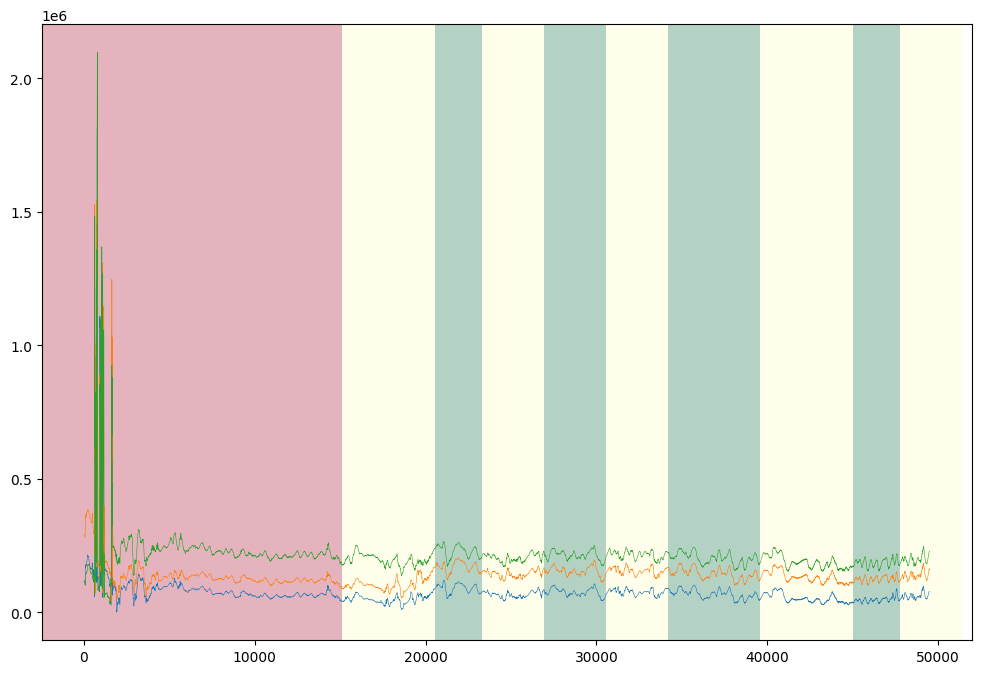

파일명: (M)125_20230611_112544_Verity_PPG.csv
전체길이: 77295
     id             date protocol      device                      start   
22  125  20230611_112544        M  Verity_PPG 2023-06-11 11:25:44.822096  \

                          end                  total   
22 2023-06-11 11:49:14.900818 0 days 00:23:30.078722  \

                         avg         fs     mast_start_time      t  
22 0 days 00:00:00.018242819  54.818551 2023-06-11 11:31:00  11:36  
raw data:                        time    idx   ppg0   ppg1   ppg2  ambient  marker   
0      20230611112544822096      0  50697  32951  34392  -322121       0  \
1      20230611112544840378      1  50578  32782  34424  -322070       0   
2      20230611112544858659      2  50463  32627  34447  -322161       0   
3      20230611112544876941      3  50376  32504  34464  -322120       0   
4      20230611112544895222      4  50324  32436  34479  -322113       0   
...                     ...    ...    ...    ...    ...      ...     ...   

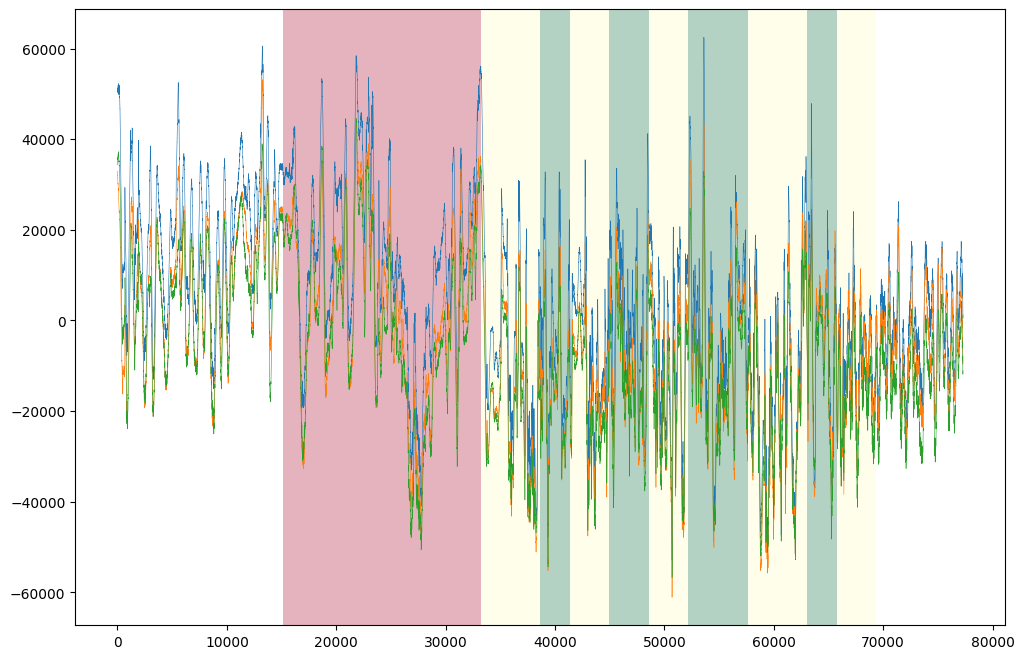

In [54]:
def mast_data_lebel_protocol(data):
    '''
    0615
    proc phase label
    mast data only
    labeled data plot with lebel
    save labeled raw data plot image
    input
        mast_date_dict_list = {device: dataframe(name = raw columns)}
        participants_time_df = user time task table
    output
        png image : labeled raw data plot image
    '''

    for i in data:
        print('파일명:', i)
        cid = int(i[3:6])

        # 데이터 정상성 확인
        print('전체길이:',len(data[i]))
                    
        #길이가 짧으면 다음 cid로 넘어감
        if len(data[i]) <= 100:
            print('Data is too short')
            print('-'*60)
            continue

        #start 시간은 마스트 시작 시간 5분 전
        target_part = participants_time_df[(participants_time_df['id'] == cid) & (participants_time_df['device'].str.contains(d))]
        
        # 2번 이상 측정 시, 잘못된 케이스 제거
        if len(target_part) >= 2:
            target_part = target_part[target_part['total'] == target_part['total'].max()]
        print(target_part)

        start_time = target_part.iloc[0]['mast_start_time']
        print('raw data:', data[i])

        # 시작 인덱스 설정
        try:
            start_index = \
                data[i][data[i]['times'] >= start_time]\
                .min().idx
        except:
            print('unknown error')
            start_index = 0
            pass

        print('시작 시간:', start_time)
        print('시작 인덱스 값:', start_index)
        
        #시작 시간 init
        period= start_time
        period_ls = [start_time] # [휴식, HIT, N, HIT ...]
        #sector init
        period_sector = [start_index] # 마커 리스트
        part_len = [] # 각 파트 길이
        tmp =  start_index # 길이 계산용
        
        #MAST_TIME_TABLE에 따라서 설정
        for s in MAST_TIME_TABLE:
            #시작 시간 + 섹션 길이
            period += datetime.timedelta(seconds = s)
            # 기간 리스트에 추가
            period_ls.append(period) 
        print('기간 리스트:',period_ls)

        #기간 리스트에 따라서 길이 계산   
        for j in range(len(period_ls)-1):
            #n-1 ~ n 기간 길이 계산 
            period_length = len(data[i][data[i].times.between(period_ls[j], period_ls[j+1]) == True])
            #부분 인덱스 길이 리스트에 추가 
            part_len.append(period_length)

            #전체 인덱스 길이 계산 즉 이게 마커
            tmp += period_length
            #섹터 리스트에 추가 마커 리스트
            period_sector.append(tmp)
        print('각 섹터 길이:',part_len)
        print('각 섹터:', period_sector)
        
        # 프로토콜 번호 지정
        for j in range(len(period_sector)-1):
            if period_sector[j] < period_sector[j+1]:
                data[i].loc[period_sector[j]+1:period_sector[j+1], 'proc'] = MAST_PROTOCOL[j]
                
            else:
                break


        # 그림 그리는 파트
        fig = plt.figure(figsize=(12,8), facecolor='white')
        if 'Verity' in target_part['device'].iloc[0]:
            axes = data[i]['ppg0'].plot(linewidth = 0.4)
            axes = data[i]['ppg1'].plot(linewidth = 0.4)
            axes = data[i]['ppg2'].plot(linewidth = 0.4)       
        elif target_part['device'].iloc[0] == 'H10':
            axes = data[i]['sensor'].plot(linewidth = 0.4)
        cmap = mpl.colormaps.get_cmap('Set3')
        axes.pcolorfast(axes.get_xlim(), axes.get_ylim(), data[i]['proc'].values[np.newaxis],
                cmap='RdYlGn', alpha=0.3)
        plt.savefig(f"./images/raw/{i}.png", dpi=150)
        plt.show()
    return

# 지금은 기기별로 입력하게 되어 있는데 이걸 전체에 작동하도록 수정
for d in mast_date_dict_list:
    print(d)
    with gzip.open(f'./pkl/{d}_mast_{today}.pickle','rb') as f:
        participants_time_df = pickle.load(f)

    mast_data_lebel_protocol(mast_date_dict_list[d])

In [ ]:
# 안쓰는 plot code

def not_use_plot():

    for i in mast_Verity_dict:
        print(i)
        cid = int(i[3:6])
        # print(mast_Verity_dict[i][mast_Verity_dict[i]['times'] >= (df[df['id'] == cid].iloc[0]['mast_start_time'])].head())
        
        #start 시간은 마스트 시작 시간 5분 전
        print(df[df['id'] == cid])
        start_time = df[df['id'] == cid].iloc[0]['mast_start_time']

        try:
            start_index = mast_Verity_dict[i][Verity_dict[i]['times'] >= start_time].min().idx
        except:
            print('unknown error')
            start_index = 0
            
        print('전체길이:',len(Verity_dict[i]))
        print('시작 시간:', start_time)
        print('시작 인덱스 값:', start_index)
        
        #시작 시간 init
        period= start_time
        period_ls = [start_time] # [휴식, HIT, N, HIT ...]
        
        #sector init
        period_sector = [start_index] # 마커 리스트
        part_len = [] # 각 파트 길이
        tmp =  start_index # 길이 계산용
        
        
        #MAST_TIME_TABLE에 따라서 설정
        for s in MAST_TIME_TABLE:
            #시작 시간 + 섹션 길이
            period += datetime.timedelta(seconds = s)
            # 기간 리스트에 추가
            period_ls.append(period) 
        print('기간 리스트:',period_ls)

        #기간 리스트에 따라서 길이 계산   
        for j in range(len(period_ls)-1):
            #n-1 ~ n 기간 길이 계산 
            period_length = len(Verity_dict[i][Verity_dict[i].times.between(period_ls[j], period_ls[j+1]) == True])
            #부분 인덱스 길이 리스트에 추가 
            part_len.append(period_length)

            #전체 인덱스 길이 계산 즉 이게 마커
            tmp += period_length
            #섹터 리스트에 추가 마커 리스트
            period_sector.append(tmp)
        
        print('각 섹터 길이:',part_len)
        print('각 섹터:', period_sector)
        # 프로토콜 번호 지정
        for j in range(len(period_sector)-1):
            if period_sector[j] < period_sector[j+1]:
                mast_Verity_dict[i].loc[period_sector[j]+1:period_sector[j+1], 'proc'] = MAST_PROTOCOL[j]
                
            else:
                break

        fig = plt.figure(figsize=(12,8), facecolor='white')
        axes = mast_Verity_dict[i]['ppg0'].plot(linewidth = 0.4)
        axes = mast_Verity_dict[i]['ppg1'].plot(linewidth = 0.4)
        axes = mast_Verity_dict[i]['ppg2'].plot(linewidth = 0.4)
        
        cmap = mpl.colormaps.get_cmap('Set3')
        axes.pcolorfast(axes.get_xlim(), axes.get_ylim(), mast_Verity_dict[i]['proc'].values[np.newaxis],
                cmap='RdYlGn', alpha=0.3)
        plt.show()
        

        def mast_data_lebel_protocol(data):
    '''
    0615
    proc phase label
    mast data only
    labeled data plot with lebel
    save labeled raw data plot image
    input
        mast_date_dict_list = {device: dataframe(name = raw columns)}
        participants_time_df = user time task table
    output
        png image : labeled raw data plot image
    '''

    for i in data:
        print('파일명:', i)
        cid = int(i[3:6])

        # 데이터 정상성 확인
        print('전체길이:',len(data[i]))
                    
        #길이가 짧으면 다음 cid로 넘어감
        if len(data[i]) <= 100:
            print('Data is too short')
            print('-'*60)
            continue

        #start 시간은 마스트 시작 시간 5분 전
        target_part = participants_time_df[(participants_time_df['id'] == cid) & (participants_time_df['device'].str.contains(d))]
        
        # 2번 이상 측정 시, 잘못된 케이스 제거
        if len(target_part) >= 2:
            target_part = target_part[target_part['total'] == target_part['total'].max()]
        print(target_part)

        start_time = target_part.iloc[0]['mast_start_time']
        print('raw data:', data[i])

        # 시작 인덱스 설정
        try:
            start_index = \
                data[i][data[i]['times'] >= start_time]\
                .min().idx
        except:
            print('unknown error')
            start_index = 0
            pass

        print('시작 시간:', start_time)
        print('시작 인덱스 값:', start_index)
        
        #시작 시간 init
        period= start_time
        period_ls = [start_time] # [휴식, HIT, N, HIT ...]
        #sector init
        period_sector = [start_index] # 마커 리스트
        part_len = [] # 각 파트 길이
        tmp =  start_index # 길이 계산용
        
        #MAST_TIME_TABLE에 따라서 설정
        for s in MAST_TIME_TABLE:
            #시작 시간 + 섹션 길이
            period += datetime.timedelta(seconds = s)
            # 기간 리스트에 추가
            period_ls.append(period) 
        print('기간 리스트:',period_ls)

        #기간 리스트에 따라서 길이 계산   
        for j in range(len(period_ls)-1):
            #n-1 ~ n 기간 길이 계산 
            period_length = len(data[i][data[i].times.between(period_ls[j], period_ls[j+1]) == True])
            #부분 인덱스 길이 리스트에 추가 
            part_len.append(period_length)

            #전체 인덱스 길이 계산 즉 이게 마커
            tmp += period_length
            #섹터 리스트에 추가 마커 리스트
            period_sector.append(tmp)
        print('각 섹터 길이:',part_len)
        print('각 섹터:', period_sector)
        
        # 프로토콜 번호 지정
        for j in range(len(period_sector)-1):
            if period_sector[j] < period_sector[j+1]:
                data[i].loc[period_sector[j]+1:period_sector[j+1], 'proc'] = MAST_PROTOCOL[j]
                
            else:
                break


        # 그림 그리는 파트
        fig = plt.figure(figsize=(12,8), facecolor='white')
        if 'Verity' in target_part['device'].iloc[0]:
            axes = data[i]['ppg0'].plot(linewidth = 0.4)
            axes = data[i]['ppg1'].plot(linewidth = 0.4)
            axes = data[i]['ppg2'].plot(linewidth = 0.4)       
        elif target_part['device'].iloc[0] == 'H10':
            axes = data[i]['sensor'].plot(linewidth = 0.4)
        cmap = mpl.colormaps.get_cmap('Set3')
        axes.pcolorfast(axes.get_xlim(), axes.get_ylim(), data[i]['proc'].values[np.newaxis],
                cmap='RdYlGn', alpha=0.3)
        plt.savefig(f"./images/raw/{i}.png", dpi=150)
        plt.show()
    return

    # 지금은 기기별로 입력하게 되어 있는데 이걸 전체에 작동하도록 수정
    for d in mast_date_dict_list:
        print(d)
        with gzip.open(f'./pkl/{d}_mast_{today}.pickle','rb') as f:
            participants_time_df = pickle.load(f)

        # id 별 라벨링
        for i in mast_date_dict_list[d]:
            print('파일명:', i)
            cid = int(i[3:6])

            # 데이터 정상성 확인
            print('전체길이:',len(mast_date_dict_list[d][i]))
                        
            #길이가 짧으면 다음 cid로 넘어감
            if len(mast_date_dict_list[d][i]) <= 100:
                print('Data is too short')
                print('-'*60)
                continue

            #start 시간은 마스트 시작 시간 5분 전
            target_part = participants_time_df[(participants_time_df['id'] == cid) & (participants_time_df['device'].str.contains(d))]
            
            # 2번 이상 측정 시, 잘못된 케이스 제거
            if len(target_part) >= 2:
                target_part = target_part[target_part['total'] == target_part['total'].max()]
            print(target_part)

            start_time = target_part.iloc[0]['mast_start_time']
            print('raw data:', mast_date_dict_list[d][i])

            # 시작 인덱스 설정
            try:
                start_index = \
                    mast_date_dict_list[d][i][mast_date_dict_list[d][i]['times'] >= start_time]\
                    .min().idx
            except:
                print('unknown error')
                start_index = 0
                pass

            print('시작 시간:', start_time)
            print('시작 인덱스 값:', start_index)
            
            #시작 시간 init
            period= start_time
            period_ls = [start_time] # [휴식, HIT, N, HIT ...]
            #sector init
            period_sector = [start_index] # 마커 리스트
            part_len = [] # 각 파트 길이
            tmp =  start_index # 길이 계산용
            
            #MAST_TIME_TABLE에 따라서 설정
            for s in MAST_TIME_TABLE:
                #시작 시간 + 섹션 길이
                period += datetime.timedelta(seconds = s)
                # 기간 리스트에 추가
                period_ls.append(period) 
            print('기간 리스트:',period_ls)

            #기간 리스트에 따라서 길이 계산   
            for j in range(len(period_ls)-1):
                #n-1 ~ n 기간 길이 계산 
                period_length = len(mast_date_dict_list[d][i][mast_date_dict_list[d][i].times.between(period_ls[j], period_ls[j+1]) == True])
                #부분 인덱스 길이 리스트에 추가 
                part_len.append(period_length)

                #전체 인덱스 길이 계산 즉 이게 마커
                tmp += period_length
                #섹터 리스트에 추가 마커 리스트
                period_sector.append(tmp)
            print('각 섹터 길이:',part_len)
            print('각 섹터:', period_sector)
            
            # 프로토콜 번호 지정
            for j in range(len(period_sector)-1):
                if period_sector[j] < period_sector[j+1]:
                    mast_date_dict_list[d][i].loc[period_sector[j]+1:period_sector[j+1], 'proc'] = MAST_PROTOCOL[j]
                    
                else:
                    break


            # 그림 그리는 파트
            fig = plt.figure(figsize=(12,8), facecolor='white')
            if 'Verity' in target_part['device'].iloc[0]:
                axes = mast_date_dict_list[d][i]['ppg0'].plot(linewidth = 0.4)
                axes = mast_date_dict_list[d][i]['ppg1'].plot(linewidth = 0.4)
                axes = mast_date_dict_list[d][i]['ppg2'].plot(linewidth = 0.4)       
            elif target_part['device'].iloc[0] == 'H10':
                axes = mast_date_dict_list[d][i]['sensor'].plot(linewidth = 0.4)
            cmap = mpl.colormaps.get_cmap('Set3')
            axes.pcolorfast(axes.get_xlim(), axes.get_ylim(), mast_date_dict_list[d][i]['proc'].values[np.newaxis],
                    cmap='RdYlGn', alpha=0.3)
            plt.savefig(f"./images/raw/{i}.png", dpi=150)
            plt.show()
    

In [ ]:
# index to time 사실 필요없고 오히려 방해됨... 수정 필수
# mast_H10 = mast_H10.set_index('times')
# mast_Verity = mast_Verity.set_index('times')
# sns.set(rc={'figure.figsize':(11, 4)})

In [ ]:
# rolling mean으로 제거해보고자 했던 것 별 의미 없었다

def compare_verity_nomalization_rollmean(date_dict_list, window = 55):
    '''
    롤링 평균으로 평준화 하는 과정
    window가 너무 넓으면 와핑되는 대신 트렌드가 살고
    window가 너무 좁으면 전체 트렌드가 죽음
    verity hz인 55를 default 사용 중
    사실 dc 제거에 큰 의미가 없는 것으로 보인다
    outlier 날리고 땡[]
    input:
        date_dict_list
    output:
        compare image
    '''

    Verity_dict = date_dict_list['Verity']
    for i in Verity_dict:
        print(i)
        fig, axs = plt.subplots(3)
        fig.suptitle('rolling mean')
        plt.figure(figsize=(15, 10), dpi=80)

        signal_rollmean_nomal = pd.DataFrame(Verity_dict[i][['ppg0']]).rolling(window).mean() 
        signal_raw = Verity_dict[i][['ppg0']]
        signal_ma = signal_raw - signal_rollmean_nomal
        axs[0].plot(signal_raw)
        axs[1].plot(signal_rollmean_nomal)
        axs[2].plot(signal_ma)
        plt.show()
    return 

compare_verity_nomalization_rollmean(mast_date_dict_list, 55)
compare_verity_nomalization_rollmean(resting_date_dict_list, 55)

    # for p in Verity_dict[i]['proc'].unique():
    #     if np.isnan(p):
    #         print('Value is nan')
    #         pass
    #     else:
    #         print(p)
    #         print('프로토콜:', p, MAST_PROTOCOL_NAME[p])
               
    #         signals = Verity_dict[i][Verity_dict[i]['proc'] == p][['ppg0', 'ppg1', 'ppg2']]
    #         ambient = Verity_dict[i][Verity_dict[i]['proc'] == p]['ambient']    

    #         try:
    #             for j in signals:
   
    #                 fig, axs = plt.subplots(3)
    #                 fig.suptitle('rolling mean')
    #                 plt.figure(figsize=(15, 10), dpi=80)

    #                 axs[1].plot(pd.DataFrame(signals[j]).rolling(window = 60).mean())
    #                 axs[2].plot(pd.DataFrame(signals[j]).rolling(window = 360).mean())
    #                 axs[0].plot(signals[j])
    #                 plt.show()
    #         except:
    #             print(' VALUE ERROR')
    #             print('-'*30)
    #             pass

# skewness와 kurtosis 뭔가 걸러 내기에는 애매함



In [ ]:
# pd.set_option('display.max_row', None)
# pd.set_option('display.max_columns', None)

(H)126_20230610_090807_Verity_PPG.csv
                ppg0
count   22374.000000
mean   190097.821445
std     11666.750322
min    164124.000000
25%    181692.250000
50%    188869.500000
75%    198192.750000
max    237331.000000
ppg0    0.400147
dtype: float64
ppg0    0.105687
dtype: float64


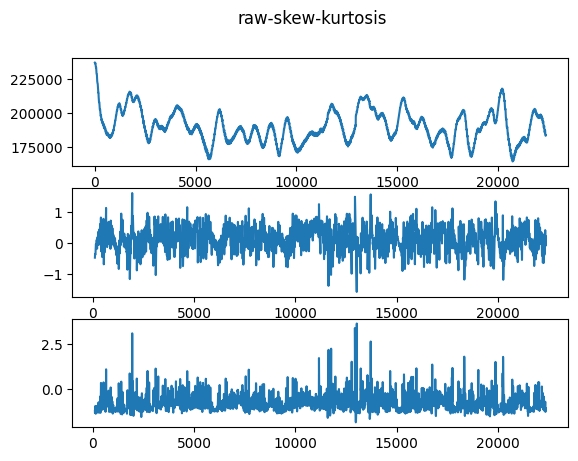

<Figure size 1200x800 with 0 Axes>

(H)128_20230610_093001_Verity_PPG.csv
               ppg0
count  23174.000000
mean  -40447.772158
std    14896.860345
min   -76770.000000
25%   -49889.000000
50%   -38825.500000
75%   -29641.250000
max     7998.000000
ppg0   -0.178376
dtype: float64
ppg0   -0.120674
dtype: float64


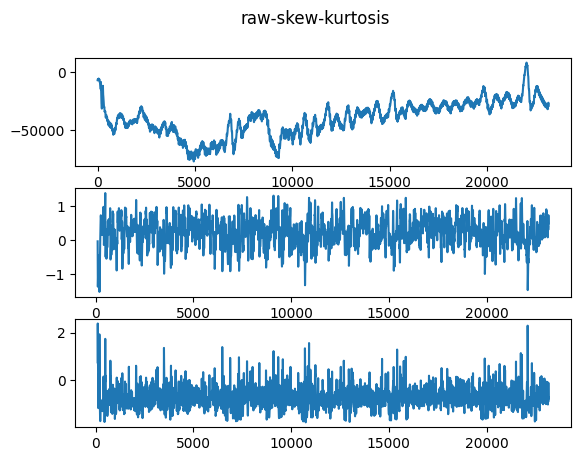

<Figure size 1200x800 with 0 Axes>

(H)129_20230610_090941_Verity_PPG.csv
                ppg0
count   23576.000000
mean   224922.445623
std      6598.696249
min    204684.000000
25%    220766.000000
50%    225415.000000
75%    228720.500000
max    261108.000000
ppg0    0.16603
dtype: float64
ppg0    1.454968
dtype: float64


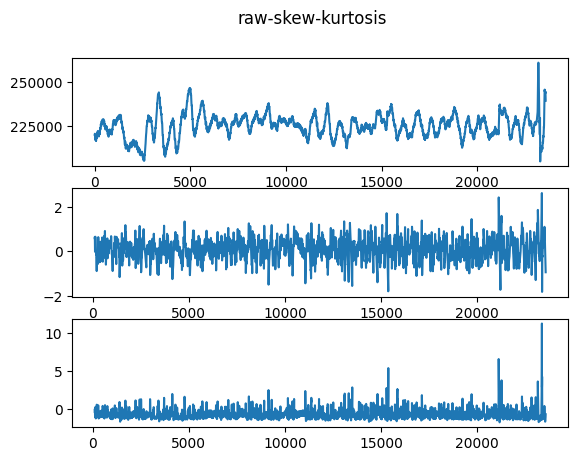

<Figure size 1200x800 with 0 Axes>

(H)130_20230610_094124_Verity_PPG.csv
                ppg0
count   23102.000000
mean   307418.526621
std      4246.909863
min    292138.000000
25%    305905.000000
50%    308202.000000
75%    309756.750000
max    319708.000000
ppg0   -1.065618
dtype: float64
ppg0    2.294391
dtype: float64


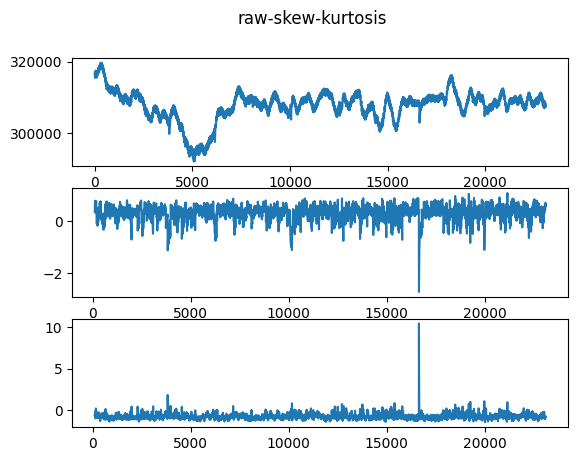

<Figure size 1200x800 with 0 Axes>

(H)131_20230610_101529_Verity_PPG.csv
                ppg0
count   23085.000000
mean  -315652.020360
std     12462.056346
min   -350319.000000
25%   -324334.000000
50%   -316029.000000
75%   -307887.000000
max   -279718.000000
ppg0    0.216858
dtype: float64
ppg0   -0.208168
dtype: float64


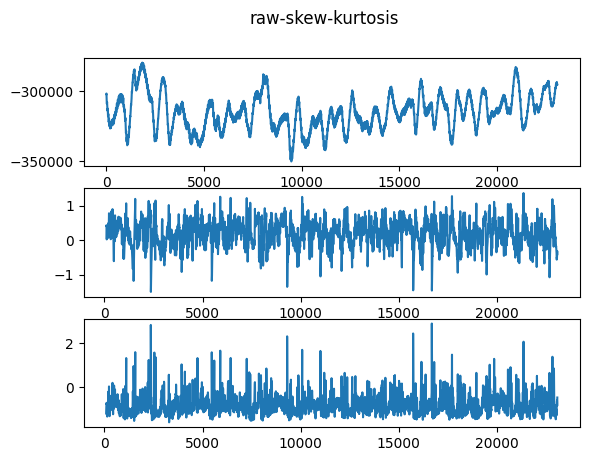

<Figure size 1200x800 with 0 Axes>

(H)132_20230610_103626_Verity_PPG.csv
                ppg0
count   23266.000000
mean   499511.413909
std      4569.104411
min    490317.000000
25%    496486.250000
50%    498935.500000
75%    501735.000000
max    527424.000000
ppg0    1.530176
dtype: float64
ppg0    5.281716
dtype: float64


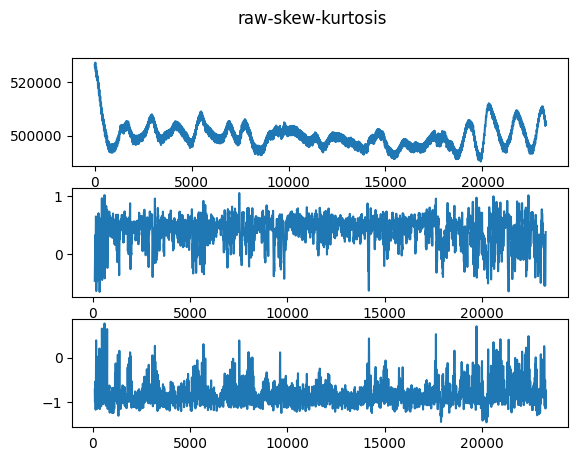

<Figure size 1200x800 with 0 Axes>

(H)133_20230610_100124_Verity_PPG.csv
                ppg0
count   23584.000000
mean    73614.455012
std      7400.954069
min     55573.000000
25%     69281.000000
50%     73018.500000
75%     76925.000000
max    134109.000000
ppg0    2.036031
dtype: float64
ppg0    11.147279
dtype: float64


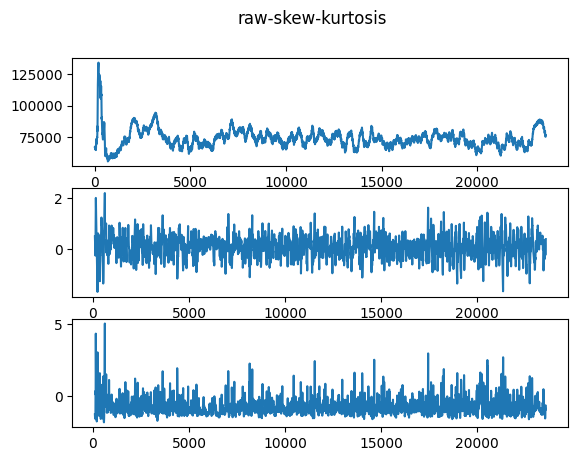

<Figure size 1200x800 with 0 Axes>

(H)134_20230610_104142_Verity_PPG.csv
                ppg0
count   23294.000000
mean   160302.778441
std     11312.808249
min    132883.000000
25%    152003.250000
50%    158745.000000
75%    167154.000000
max    192471.000000
ppg0    0.46125
dtype: float64
ppg0   -0.279338
dtype: float64


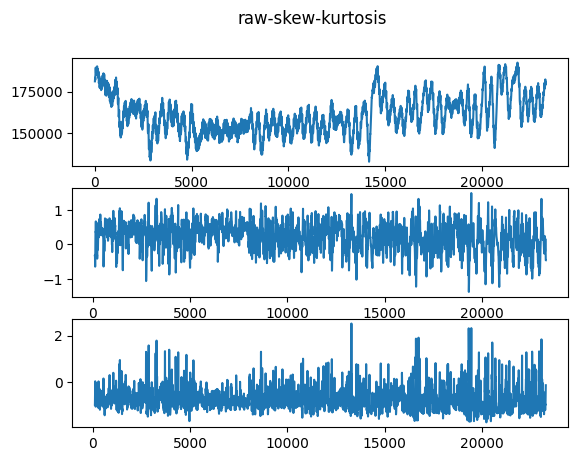

<Figure size 1200x800 with 0 Axes>

(H)135_20230610_100831_Verity_PPG.csv
                ppg0
count   23285.000000
mean  -432036.358385
std      5888.645422
min   -446592.000000
25%   -436408.000000
50%   -432902.000000
75%   -429278.000000
max   -414892.000000
ppg0    0.618425
dtype: float64
ppg0   -0.019191
dtype: float64


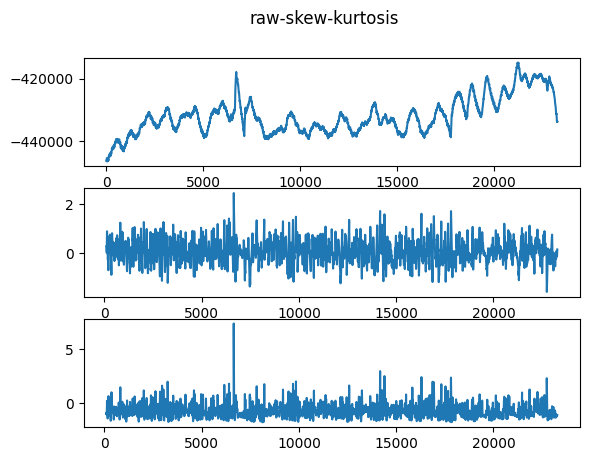

<Figure size 1200x800 with 0 Axes>

(H)136_20230610_103656_Verity_PPG.csv
                ppg0
count   23220.000000
mean  -242298.104823
std      4560.636115
min   -259887.000000
25%   -245139.250000
50%   -243100.000000
75%   -240938.000000
max   -221900.000000
ppg0    0.920905
dtype: float64
ppg0    1.771749
dtype: float64


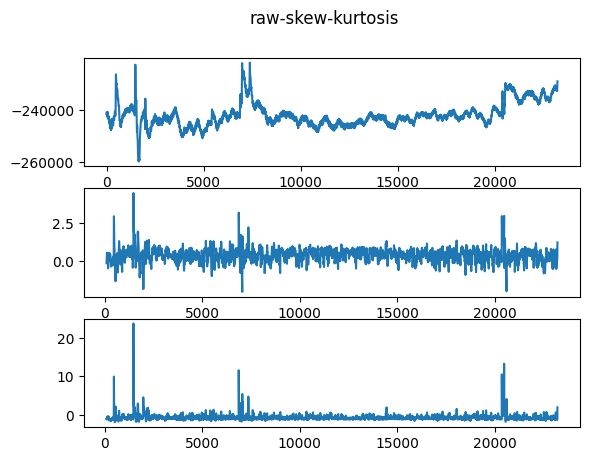

<Figure size 1200x800 with 0 Axes>

(H)137_20230610_111136_Verity_PPG.csv
                ppg0
count   23142.000000
mean  -223299.792110
std      7960.960808
min   -247606.000000
25%   -227898.750000
50%   -222200.000000
75%   -217516.250000
max   -204582.000000
ppg0   -0.617051
dtype: float64
ppg0   -0.043269
dtype: float64


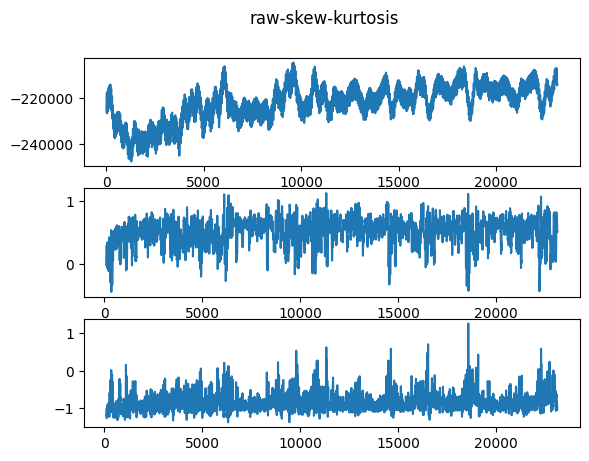

<Figure size 1200x800 with 0 Axes>

(H)138_20230610_114239_Verity_PPG.csv
                ppg0
count   23150.000000
mean  -164382.954471
std      7804.307450
min   -180015.000000
25%   -169202.750000
50%   -165944.000000
75%   -161013.000000
max   -124739.000000
ppg0    1.757868
dtype: float64
ppg0    5.765874
dtype: float64


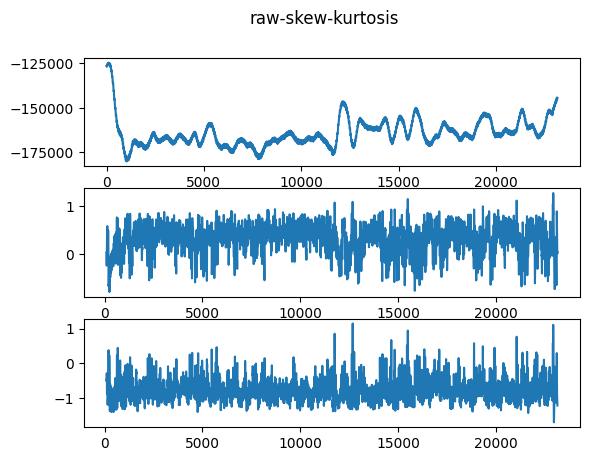

<Figure size 1200x800 with 0 Axes>

(H)139_20230610_111424_Verity_PPG.csv
                ppg0
count   16549.000000
mean  -141886.082422
std     13111.193599
min   -201710.000000
25%   -148987.000000
50%   -140586.000000
75%   -133196.000000
max   -109245.000000
ppg0   -1.029326
dtype: float64
ppg0    2.3424
dtype: float64


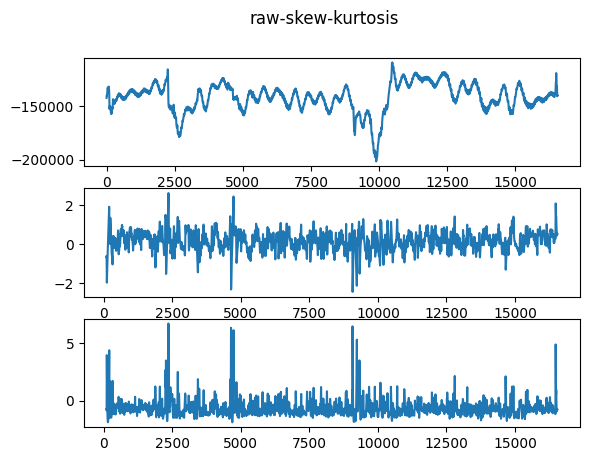

<Figure size 1200x800 with 0 Axes>

(H)140_20230610_113921_Verity_PPG.csv
                ppg0
count   23288.000000
mean   685020.571668
std     12680.830521
min    644883.000000
25%    676155.500000
50%    683680.000000
75%    693792.750000
max    720212.000000
ppg0    0.211148
dtype: float64
ppg0   -0.115118
dtype: float64


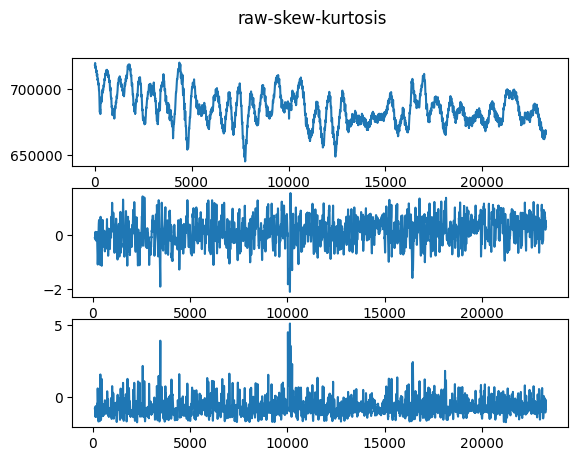

<Figure size 1200x800 with 0 Axes>

(H)141_20230610_112553_Verity_PPG.csv
               ppg0
count  23111.000000
mean  -35466.299900
std     6866.111385
min   -51379.000000
25%   -39150.500000
50%   -35943.000000
75%   -32835.000000
max    26873.000000
ppg0    3.243713
dtype: float64
ppg0    22.166718
dtype: float64


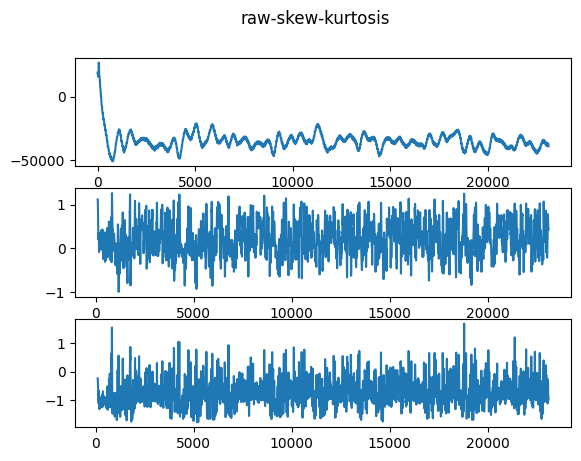

<Figure size 1200x800 with 0 Axes>

(H)142_20230610_114610_Verity_PPG.csv
                ppg0
count   23712.000000
mean  -186189.822706
std     10541.132445
min   -206862.000000
25%   -193989.250000
50%   -186803.000000
75%   -179559.250000
max   -158431.000000
ppg0    0.265758
dtype: float64
ppg0   -0.548791
dtype: float64


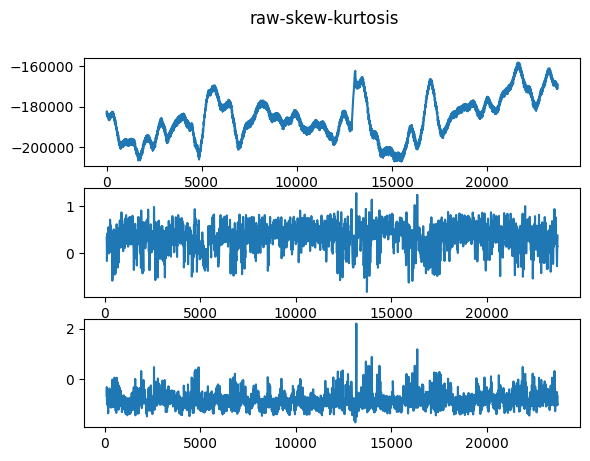

<Figure size 1200x800 with 0 Axes>

(H)143_20230610_120724_Verity_PPG.csv
                ppg0
count   23102.000000
mean  -267461.148645
std      7981.344041
min   -285930.000000
25%   -271157.750000
50%   -266307.000000
75%   -261030.000000
max   -253170.000000
ppg0   -0.661191
dtype: float64
ppg0   -0.475333
dtype: float64


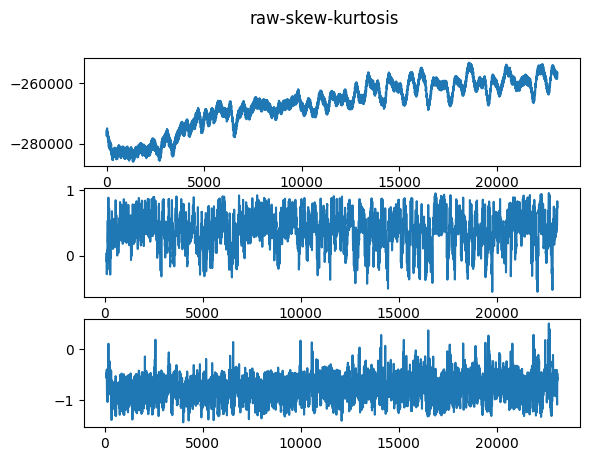

<Figure size 1200x800 with 0 Axes>

(H)144_20230610_122913_Verity_PPG.csv
                ppg0
count   23134.000000
mean  -220171.120515
std      8817.538237
min   -237505.000000
25%   -226681.750000
50%   -222125.500000
75%   -215325.000000
max   -182257.000000
ppg0    0.998535
dtype: float64
ppg0    1.056284
dtype: float64


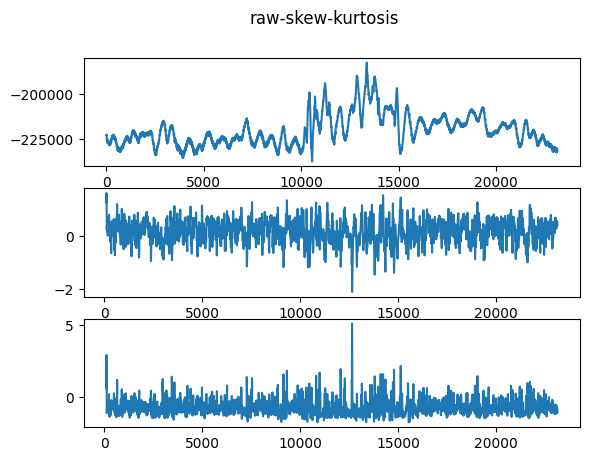

<Figure size 1200x800 with 0 Axes>

(H)145_20230610_120903_Verity_PPG.csv
                ppg0
count   23462.000000
mean   424721.721209
std     18520.403283
min    362626.000000
25%    414032.000000
50%    424861.000000
75%    435011.750000
max    500639.000000
ppg0    0.258215
dtype: float64
ppg0    0.89541
dtype: float64


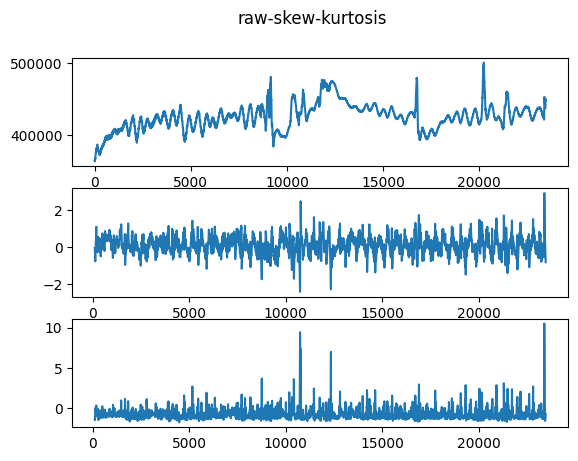

<Figure size 1200x800 with 0 Axes>

(H)146_20230610_122910_Verity_PPG.csv
                ppg0
count   23238.000000
mean  -274437.844823
std     39085.803487
min   -327067.000000
25%   -285014.250000
50%   -277918.000000
75%   -271820.250000
max    622408.000000
ppg0    14.110785
dtype: float64
ppg0    264.43922
dtype: float64


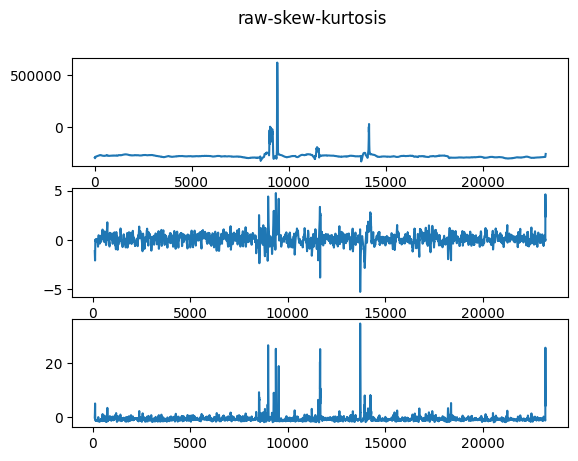

<Figure size 1200x800 with 0 Axes>

(H)147_20230610_121258_Verity_PPG.csv
                ppg0
count   23562.000000
mean  -141021.032086
std      8509.788983
min   -161727.000000
25%   -147089.000000
50%   -142458.000000
75%   -134832.750000
max    -99838.000000
ppg0    0.581692
dtype: float64
ppg0    0.639096
dtype: float64


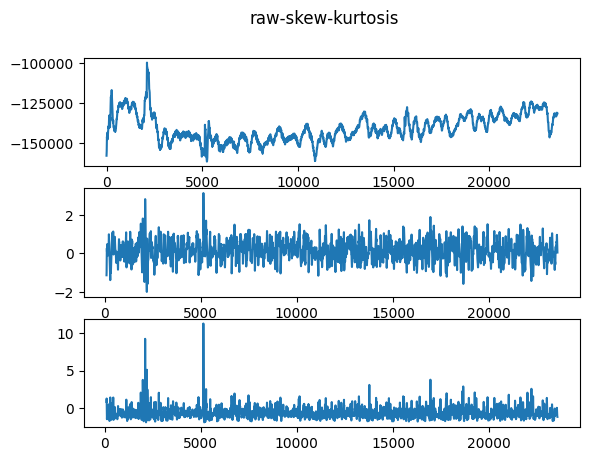

<Figure size 1200x800 with 0 Axes>

(H)148_20230610_123627_Verity_PPG.csv
                ppg0
count   23210.000000
mean  -246540.268893
std      5191.591089
min   -259703.000000
25%   -249957.000000
50%   -246044.500000
75%   -243467.000000
max   -230660.000000
ppg0    0.005977
dtype: float64
ppg0    0.164401
dtype: float64


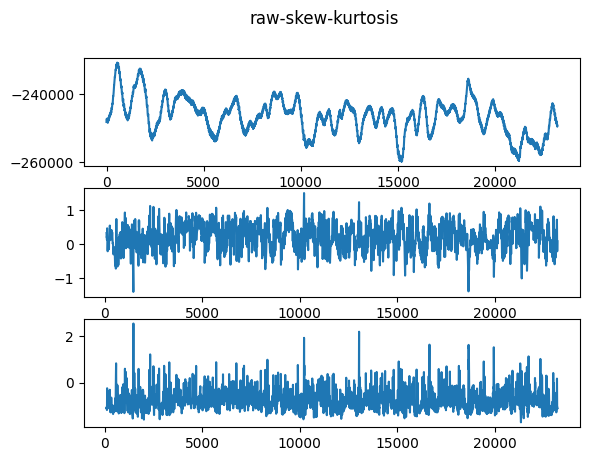

<Figure size 1200x800 with 0 Axes>

In [62]:
def skew_kurto_data(date_dict_list, window = 55):
    '''
    skewness와 kurtosis를 보기 위한 코드
    input:
        verity data
    output:
        kurtosis & skewness
    '''
    Verity_dict = date_dict_list['Verity']
    for i in Verity_dict:
        print(i)

        fig, axs = plt.subplots(3)
        fig.suptitle('raw-skew-kurtosis')
        plt.figure(figsize=(15, 10), dpi=80)

        signal = Verity_dict[i][['ppg0']]
        print(signal.describe())
        print(signal.skew())
        print(signal.kurt())

        axs[0].plot(signal)
        axs[1].plot(signal.rolling(window).skew())
        axs[2].plot(signal.rolling(window).kurt())

        plt.show()
        
        # for p in Verity_dict[i]['proc'].unique():
        #     if np.isnan(p):
        #         print('Value is nan')
        #         pass
        #     else:
        #         print(p)
        #         # print('프로토콜:', p, MAST_PROTOCOL_NAME[p])
                
        #         signals = Verity_dict[i][Verity_dict[i]['proc'] == p][['ppg0', 'ppg1', 'ppg2']]
        #         ambient = Verity_dict[i][Verity_dict[i]['proc'] == p]['ambient']    

        #         try:
        #             for j in signals:
        #                 print(j, '- skew', scipy.stats.skew(signals[j]))
        #                 print(j, '- kutosis', scipy.stats.kurtosis(signals[j]))
        #                 fig, axs = plt.subplots(3)
        #                 fig.suptitle('raw-skew-kurtosis')
        #                 plt.figure(figsize=(15, 10), dpi=80)

        #                 axs[1].plot(pd.DataFrame(signals[j]).rolling(window).skew())
        #                 axs[2].plot(pd.DataFrame(signals[j]).rolling(window).kurt())
        #                 axs[0].plot(signals[j])
        #                 plt.show()
        #         except:
        #             print(' VALUE ERROR')
        #             print('-'*30)
        #             pass

    return

skew_kurto_data(resting_date_dict_list, 100)

In [ ]:
for i in mast_Verity_dict:
    print(i)

    fig, axs = plt.subplots(3)
    fig.suptitle('raw-skew-kurtosis')
    plt.figure(figsize=(15, 10), dpi=80)

    axs[1].plot(pd.DataFrame(mast_Verity_dict[i][['ppg0', 'ppg1', 'ppg2']]).rolling(window = 55).skew())
    axs[2].plot(pd.DataFrame(mast_Verity_dict[i][['ppg0', 'ppg1', 'ppg2']]).rolling(window = 55).kurt())
    axs[0].plot(mast_Verity_dict[i][['ppg0', 'ppg1', 'ppg2']])
    plt.show()
    
    for p in mast_Verity_dict[i]['proc'].unique():
        if np.isnan(p):
            print('Value is nan')
            pass
        else:
            print(p)
            print('프로토콜:', p, MAST_PROTOCOL_NAME[p])
               
            signals = mast_Verity_dict[i][mast_Verity_dict[i]['proc'] == p][['ppg0', 'ppg1', 'ppg2']]
            ambient = mast_Verity_dict[i][mast_Verity_dict[i]['proc'] == p]['ambient']    

            try:
                for j in signals:
                    print(j, '- skew', scipy.stats.skew(signals[j]))
                    print(j, '- kutosis', scipy.stats.kurtosis(signals[j]))
                    fig, axs = plt.subplots(3)
                    fig.suptitle('raw-skew-kurtosis')
                    plt.figure(figsize=(15, 10), dpi=80)

                    axs[1].plot(pd.DataFrame(signals[j]).rolling(window = 55).skew())
                    axs[2].plot(pd.DataFrame(signals[j]).rolling(window = 55).kurt())
                    axs[0].plot(signals[j])
                    plt.show()
            except:
                print(' VALUE ERROR')
                print('-'*30)
                pass

In [63]:
mast_Verity_dict = mast_date_dict_list['Verity']

for i in mast_Verity_dict:
    
    print(i)
    cid = int(i[3:6])
    # print(mast_Verity_dict[i][mast_Verity_dict[i]['times'] >= (df[df['id'] == cid].iloc[0]['mast_start_time'])].head())
    
    #start 시간은 마스트 시작 시간 5분 전
    print(df[df['id'] == cid])
    start_time = df[df['id'] == cid].iloc[0]['mast_start_time']

    try:
        start_index = mast_Verity_dict[i][mast_Verity_dict[i]['times'] >= start_time].min().idx
    except:
        print('unknown error')
        start_index = 0
        
    print('전체길이:',len(mast_Verity_dict[i]))
    print('시작 시간:', start_time)
    print('시작 인덱스 값:', start_index)
    
    #시작 시간 init
    period= start_time
    period_ls = [start_time] # [휴식, HIT, N, HIT ...]
    
    #sector init
    period_sector = [start_index] # 마커 리스트
    part_len = [] # 각 파트 길이
    tmp =  start_index # 길이 계산용
    
    
    #MAST_TIME_TABLE에 따라서 설정
    for s in MAST_TIME_TABLE:
        #시작 시간 + 섹션 길이
        period += datetime.timedelta(seconds = s)
        # 기간 리스트에 추가
        period_ls.append(period) 
    print('기간 리스트:',period_ls)

    #기간 리스트에 따라서 길이 계산   
    for j in range(len(period_ls)-1):
        #n-1 ~ n 기간 길이 계산 
        period_length = len(mast_Verity_dict[i][mast_Verity_dict[i].times.between(period_ls[j], period_ls[j+1]) == True])
        #부분 인덱스 길이 리스트에 추가 
        part_len.append(period_length)

        #전체 인덱스 길이 계산 즉 이게 마커
        tmp += period_length
        #섹터 리스트에 추가 마커 리스트
        period_sector.append(tmp)
    
    print('각 섹터 길이:',part_len)
    print('각 섹터:', period_sector)
    # 프로토콜 번호 지정
    for j in range(len(period_sector)-1):
        if period_sector[j] < period_sector[j+1]:
            mast_Verity_dict[i].loc[period_sector[j]+1:period_sector[j+1], 'proc'] = MAST_PROTOCOL[j]
            
        else:
            break

    fig = plt.figure(figsize=(12,8), facecolor='white')
    axes = mast_Verity_dict[i]['ppg0'].plot(linewidth = 0.4)
    axes = mast_Verity_dict[i]['ppg1'].plot(linewidth = 0.4)
    axes = mast_Verity_dict[i]['ppg2'].plot(linewidth = 0.4)
    
    cmap = mpl.colormaps.get_cmap('Set3')
    axes.pcolorfast(axes.get_xlim(), axes.get_ylim(), mast_Verity_dict[i]['proc'].values[np.newaxis],
            cmap='RdYlGn', alpha=0.3)
    plt.show()
    

(M)065_20230611_115716_Verity_PPG.csv


NameError: name 'df' is not defined

In [71]:
import pywt

def madev(d, axis=None):
    """ Mean absolute deviation of a signal """
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

def wavelet_denoising(x, wavelet='db4', level=1):
    coeff = pywt.wavedec(x, wavelet, mode="per")
    sigma = (1/0.6745) * madev(coeff[-level])
    uthresh = sigma * np.sqrt(2 * np.log(len(x)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])
    print('=-=-'*30)
    return pywt.waverec(coeff, wavelet, mode='per')


def signal_sermentation(data):
    import statsmodels.api as sm
    size = 2 ** np.ceil(np.log2(2*len(data) - 1)).astype('int')
    var = np.var(data)
    lenghth = len(data)
    lag = VERITY_FS*3
    
    # 실패 이유, 시작 점이 주기의 시작 지점이 아니라는걸 망각, 그말은 즉 앞을 찾으면 사용 가능 ㅋ

    # #ac function 3 [most fast & effective]
    acf = sm.tsa.acf(data, nlags = lag)

    v = [] # velly idx list
    n = [] # peak idx list
    mue = [] # step size list 

    v.append(np.where(acf == acf.min())[0][0]) #v1
    n.append(v[0]+ np.where(acf[v[0]:] == acf[v[0]:].max())[0][0]) #n1
    mue.append(n[0]) 

    print(v,n,mue)
    try:
        for i in range(len(acf)):
            max_range = int(np.ceil(v[i] + mue[i]+ (mue[i]/3)))
            v.append(n[i]+ np.where(acf[n[i]:max_range] == acf[n[i]:max_range].min())[0][0])
            mue.append(v[i+1] - v[i])
            n.append(n[i] + mue[i+1])
            print(v, n, mue)
    except:
        pass
    
    plt.plot(data[:lag])
    plt.plot(v, [data[data.keys()[0]][i+1] for i in v], 'ro')
    plt.plot(n, [data[data.keys()[0]][i+1] for i in n], 'bx')
    plt.show()

    return acf

def madr(data, method = 'statistical'):
    '''
    Moving Artifact Detect & Remove method
    Condition: no refer/ synthetic refer/ acc refer
    ** on this no refer & synthetic refer
    first, no refer data approach
    1. statistical method
    2. variable frequency complex demodulation
    3. DWT
    4. ICA : 다양한 신호 잡음이 있을 때 사용하면 잡을 수 있는데, ppg는 잡음이 있는 것이 아니라 moving artifact에 의해 날아가는거라서 의미가 없더라.
    '''
    # output
    denoised = None

    # seg_data = signal_sermentation(data)
    from sklearn.decomposition import FastICA
    if method == 'statistical': # skew, kurtosis로 계산
        print('madr start')
        

    elif method == 'DWT': #이산 변환으로 추출 제거
        print('madr start')
        from skimage.restoration import denoise_wavelet

        denoised = denoise_wavelet(data, method='BayesShrink', mode='soft', wavelet_levels=3, wavelet='sym8', rescale_sigma='True')

        for wav in pywt.wavelist():
            try:
                denoised = wavelet_denoising(data, wavelet=wav, level=1)
            except:
                pass
            fig, axs = plt.subplots(2)
            fig.tight_layout()
            plt.figure(figsize=(15, 10), dpi=80)
            axs[0].set_title('Raw')
            axs[0].plot(data)

            axs[1].set_title(f"DWT Denoising with {wav} Wavelet", size=15)
            axs[1].plot(denoised, label='Filtered', linewidth = 0.4)
            plt.show()


    elif method == 'demodulation':
        print('madr start')



    elif method == 'ICA': #independant component analysis
        print('ICA madr start')
        ica = FastICA(
            n_components=3, 
            # whiten= False
            whiten = 'unit-variance'
            # whiten="arbitrary-variance"

            )
        denosed = ica.fit_transform(data)  # Reconstruct signals
        A_ = ica.mixing_  # Get estimated mixing matrix
        print(denosed)
        # assert np.allclose(X, np.dot(S_, A_.T) + ica.mean_)

        # plt.figure()
        colors = ["red", "steelblue", "orange"]
        fig, axs = plt.subplots(2)
        fig.tight_layout()
        plt.figure(figsize=(15, 10), dpi=80)
        axs[0].set_title('Raw')
        axs[0].plot(data)

        axs[1].set_title("ICA recovered signals")
        for sig, color in zip(denosed.T, colors):
            axs[1].plot(sig, linewidth = 0.4, color = color)
        plt.show()

    elif method == 'ANC': # Adaptive Nose Cancellation
        print('madr start')

    elif method == 'FSA': # Fourier Series Analysis
        print('madr start')
    
    else:
        print('method is not exist')
    

    return denoised

def GridSearchCV_SVM(model):
    from sklearn.model_selection import GridSearchCV
    hyperparameters = {
    "nu": [0.01, 0.05, 0.1],
    "kernel": ["linear", "rbf"],
    }
    return GridSearchCV(model, hyperparameters, cv=5)

def anomaly_detect(data, method):
    '''
        Use pyod
        isolation Forest
        One class SVM
    '''
    import pyod.models as modesl
    import pyod.models.ocsvm as ocsvm
    import pyod.models.iforest as iforest
    import pyod.models.deep_svdd as dsvdd
    import pyod.models.anogan as anogan
    import pyod.models.auto_encoder as ae_anomaly_detect

    print('anomaly model searching...')

    if method == 'iForest':
        print('iForest anomaly detect start')

    elif method == 'OCSVM':
        print('OCSVM anomaly detect start')

        model = ocsvm()
        grid_search = GridSearchCV_SVM(model)
        grid_search.fit(data)
        print(grid_search.best_params_)

        

    elif method == 'anoGAN':
        print('anoGAN anomaly detect start')

    elif method == 'deep_svdd':
        print('deep_svdd anomaly detect start')
    elif method == 'AE':
        print('AE anomaly detect start')

    return



In [74]:
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.decomposition import FastICA

for i in mast_Verity_dict:
    print(i)
    print('raw 길이:', len(mast_Verity_dict[i]))
    mast_Verity_dict[i]['signal_0'] = mast_Verity_dict[i]['ppg0'] - mast_Verity_dict[i]['ambient']
    
    mast_Verity_dict[i]['signal_0_ffty'] = signal.detrend(mast_Verity_dict[i]['ppg0'])
    mast_Verity_dict[i]['signal_0_filtered_signal'] = signal.sosfilt(sos, mast_Verity_dict[i]['signal_0_ffty'])
    mast_Verity_dict[i]['signal_0_filtered_hp']  = hp.filter_signal(mast_Verity_dict[i]['signal_0_ffty'], [1.5, 3.5], sample_rate=VERITY_FS, order=2, filtertype='bandpass')
 
    # target = mast_Verity_dict[i]['signal_0_filtered_signal'][1000:].reset_index().drop('index', axis = 1)
    # target = mast_Verity_dict[i]['signal_0_filtered_hp']
    target = mast_Verity_dict[i][['ppg0']]
    print(target)

    denosed_target = madr(target, 'DWT')
    print(denosed_target)


    # target = mast_Verity_dict[i]['signal_0_filtered_signal']
    # target = hp.remove_baseline_wander(target, VERITY_FS)
    # print(target)
    # draw_ppg(target, VERITY_FS)
    # pd.plotting.lag_plot(target)
    # plot_acf(target)
    # seg_data = signal_sermentation(target)


    # fig, axs = plt.subplots(6)
    # fig.tight_layout()
    # plt.figure(figsize=(15, 10), dpi=80)
    
    # axs[0].set_title('Raw')
    # axs[0].plot(mast_Verity_dict[i]['ppg0'])

    # axs[1].set_title('detrend')
    # axs[1].plot(mast_Verity_dict[i]['signal_0_ffty'])
    
    # axs[2].set_title('detrend + butterworth')
    # axs[2].plot(mast_Verity_dict[i]['signal_0_filtered_signal'])

    # axs[3].set_title('detrend + butterworth')
    # axs[3].plot(mast_Verity_dict[i]['signal_0_filtered_signal'][1000:2000]) 

    # axs[4].set_title('hp_bandpass filters')
    # axs[4].plot(mast_Verity_dict[i]['signal_0_filtered_hp']) 

    # axs[5].set_title('hp_bandpass filters')
    # axs[5].plot(mast_Verity_dict[i]['signal_0_filtered_hp'][1000:2000]) 

    # plt.show()


## 윈도우 사이즈에 따라서 분할

    # target_mast = mast_Verity_dict[i][mast_Verity_dict[i]['proc'].notna()]
    # time_window = 1024
    
    # for p in target_mast['proc'].unique():
    #     print('MAST 프로토콜:',p, MAST_PROTOCOL_NAME[p])
    #     task_data = mast_Verity_dict[i][mast_Verity_dict[i]['proc'] == p]
        
    #     if len(task_data) > time_window:
    #         splited_target_data = np.array_split(task_data, len(task_data) // time_window)
    #     else:
    #         break
        
    #     print('xxxxxxxx',len(splited_target_data))
    #     for df in splited_target_data:
    #         target = df.reset_index(drop=True).signal_0_filtered1
            
    #         print('-'*30)
                        
    #        draw_ppg(target, VERITY_FS)


## 지정 범위에 따라서 분할

    # resampled = resample( mast_Verity_dict[i]['signal_0_filtered_signal'], len( mast_Verity_dict[i]['signal_0_filtered_signal']) * 10)
    #don't forget to compute the new sampling rate
    # new_sample_rate = VERITY_FS * 10

    # draw_ppg(mast_Verity_dict[i]['signal_0_filtered_signal'], VERITY_FS)

    # for s in [[0, 1000], [1000, 2000], [2000, 3000], [3000, 4000], [4000, 5000]]:
        # draw_ppg(filtered_signal_0[s[0]:s[1]], VERITY_FS) 

(M)065_20230611_115716_Verity_PPG.csv
raw 길이: 69611


ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [ ]:
sample_rate = VERITY_FS
# motion artifact detection ad reduction in ppg signals based on statistics analysis(2023)
band_pass_filter_pass_band = [0.5, 0.6]

for i in mast_Verity_dict:
    print(i)
    print('인덱스 길이:',len(mast_Verity_dict[i]))
    
    print(mast_Verity_dict[i].keys())


    signal_0 = mast_Verity_dict[i]['ppg0']
    # signal_1 = mast_Verity_dict[i]['ppg1']
    # signal_2 = mast_Verity_dict[i]['ppg2']
    
    # enhanced_signal_0 = hp.enhance_peaks(signal_0, iterations=2)
    # enhanced_signal_1 = hp.enhance_peaks(signal_1, iterations=2)
    # enhanced_signal_2 = hp.enhance_peaks(signal_2, iterations=2)

    # signal_0 = outlier_drop(signal_0)

    filtered_signal_0 = hp.filter_signal(signal_0, band_pass_filter_pass_band, sample_rate=VERITY_FS, 
                                         order=2, filtertype='bandpass')
    # filtered_signal_1 = hp.filter_signal(signal_1, band_pass_filter_pass_band, sample_rate=VERITY_FS, 
    #                                      order=2, filtertype='bandpass')
    # filtered_signal_2 = hp.filter_signal(signal_2, band_pass_filter_pass_band, sample_rate=VERITY_FS, 
    #                                      order=2, filtertype='bandpass')

    


    # plt.plot(filtered_signal_0)
    # plt.show()

    # resampled = resample(filtered_signal_0, len(filtered_signal_0) * 10)

    # #don't forget to compute the new sampling rate
    # new_sample_rate = sample_rate * 10
    # wd, m = hp.process(filtered_signal_0, sample_rate = sample_rate, 
    #                 high_precision=True, clean_rr=True)
    # hp.plotter(wd, m, title = 'zoomed in section', figsize=(12,6))
    # hp.plot_poincare(wd, m)
    # plt.show()
    # for measure in m.keys():
    #     print('%s: %f' %(measure, m[measure]))
    # # for s in [[0, 1000], [1000, 2000], [2000, 3000], [3000, 4000], [4000, 5000]]:
    #     wd, m = hp.process(filtered_signal_0[s[0]:s[1]], sample_rate = sample_rate, 
    #                        high_precision=True, clean_rr=True)
    #     hp.plotter(wd, m, title = 'zoomed in section', figsize=(12,6))
    #     hp.plot_poincare(wd, m)
    #     plt.show()
    #     for measure in m.keys():
    #         print('%s: %f' %(measure, m[measure]))